<a href="https://colab.research.google.com/github/MariiaKalinina/RPM/blob/main/RPM_FRAMEWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt

In [2]:
!pip install GitPython

In [3]:
from git import Repo
!git clone https://github.com/MariiaKalinina/RPM.git

fatal: destination path 'RPM' already exists and is not an empty directory.


# Data Preparation

In [4]:
input_data = pd.read_csv(
    '/content/RPM/Input data/INPUT_DATA.csv',
    sep=None,
    decimal=',',
    na_values=['NaN', ''],
    engine='python'
)
input_data = input_data.dropna(how='all')  # Drop rows where ALL columns are NaN

input_data['Phase'] = input_data['Phase'].ffill()  # Fill NaN with the previous non-NaN value
input_data = input_data.reset_index(drop=True)

In [5]:
input_data

,Phase,Component type,Thermal Conductivity,Volume/Porosity,Aspect Ratio,Anisotropy,Hierarchy of component
0,Solid Phase,Calcite,3.00,70.0,1.000,NaN,1.0
1,Solid Phase,Quartz,7.60,5.0,1.000,NaN,1.0
2,Solid Phase,Dolomite,2.80,25.0,0.800,NaN,1.0
3,Fluid Phase,Pore 1,0.60,10.0,0.100,NaN,1.0
4,Fluid Phase,Pore 2,0.13,4.0,0.500,NaN,1.0
5,Fluid Phase,Cracks,0.13,0.8,0.001,Yes,2.0


# Models


*   Likhteneker model
*   Wiener bounds
*   Hashin-Strikman bounds
*   Maxwell-Garnet
*   Bruggeman EMA
*   GSA








In [6]:
# def validate_inputs(volume_fractions, thermal_conductivities):
#     """Validate volume fractions and thermal conductivities."""
#     if not np.isclose(np.sum(volume_fractions), 1.0, atol=1e-6):
#         raise ValueError("Volume fractions must sum to 1.0.")
#     if np.any(thermal_conductivities <= 0):
#         raise ValueError("Thermal conductivities must be positive.")
#     return volume_fractions, thermal_conductivities

def validate_inputs(volume_fractions, thermal_conductivities):
    """Enhanced validation that handles both scalar and tensor thermal conductivities"""
    # Check volume fractions sum to 1
    if not np.isclose(np.sum(volume_fractions), 1.0, atol=1e-6):
        raise ValueError("Volume fractions must sum to 1.0")

    # Check each thermal conductivity value individually
    for i, tc in enumerate(thermal_conductivities):
        if isinstance(tc, (list, np.ndarray)):
            # For tensor/array values
            tc_array = np.array(tc)
            if np.any(tc_array <= 0):
                raise ValueError(
                    f"All thermal conductivity components must be positive. "
                    f"Found negative value in tensor at position {i}: {tc_array}"
                )
        else:
            # For scalar values
            if tc <= 0:
                raise ValueError(
                    f"Thermal conductivity must be positive. "
                    f"Found {tc} at position {i}"
                )

    return volume_fractions, thermal_conductivities

## **Likhteneker**

\begin{equation}
\lambda_{\text{eff}} = \exp\left( \sum_{i=1}^N \phi_i \ln \lambda_i \right)
\end{equation}

In [7]:
def Likhteneker(volume_fractions, thermal_conductivities, alpha_shape=None):
    """
    Calculate the effective thermal conductivity using the Likhteneker model (logarithmic mean).
    This is equivalent to the geometric mean for a two-phase material.

    Parameters:
        volume_fractions (list or np.ndarray): Volume fractions (must sum to ~1.0).
        thermal_conductivities (list or np.ndarray): Thermal conductivities (must be > 0).
        alpha_shape (optional): Unused (for compatibility).

    Returns:
        float: Effective thermal conductivity (W/m·K).
    """

    if not np.isclose(np.sum(volume_fractions), 1.0, atol=1e-6):
        volume_fractions = volume_fractions / np.sum(volume_fractions)

    phi, lam = validate_inputs(volume_fractions, thermal_conductivities)
    return np.exp(np.sum(phi * np.log(lam + 1e-10)))  # Avoid log(0)

## **Wiener Bounds for Thermal Conductivity**

### Wiener Lower Bound (Series Model)

$$
\lambda_{\text{lower}} = \left( \sum_{i=1}^N \frac{\phi_i}{\lambda_i} \right)^{-1}
$$

### Wiener Upper Bound (Parallel Model)

$$
\lambda_{\text{upper}} = \sum_{i=1}^N \phi_i \lambda_i
$$

### Average Thermal Conductivity (Arithmetic Mean)

$$
\lambda_{\text{avg}} = \sum_{i=1}^N \phi_i \lambda_i
$$


In [8]:
def Wiener_Upper_Bound(volume_fractions, thermal_conductivities, alpha_shape=None):
    """
    Upper bound (parallel configuration) of thermal conductivity (Wiener model).
    Equivalent to the arithmetic mean.

    Returns:
        float: Upper bound thermal conductivity (W/m·K).
    """
    phi, lam = validate_inputs(volume_fractions, thermal_conductivities)
    return np.sum(phi * lam)

def Wiener_Lower_Bound(volume_fractions, thermal_conductivities, alpha_shape=None):
    """
    Lower bound (series configuration) of thermal conductivity (Wiener model).
    Equivalent to the harmonic mean.

    Returns:
        float: Lower bound thermal conductivity (W/m·K).
    """
    phi, lam = validate_inputs(volume_fractions, thermal_conductivities)
    return 1.0 / np.sum(phi / (lam + 1e-10))  # Avoid division by zero

def Wiener_Average(volume_fractions, thermal_conductivities, alpha_shape=None):
    """
    Geometric mean of Wiener bounds (alternative: arithmetic mean).

    Returns:
        float: Geometric average of Wiener bounds (W/m·K).
    """
    upper = Wiener_Upper_Bound(volume_fractions, thermal_conductivities)
    lower = Wiener_Lower_Bound(volume_fractions, thermal_conductivities)
    return np.sqrt(upper * lower)  # Geometric mean (more conservative)

## **Hashin-Shtrikman Bounds**

Assuming ordered conductivities $\lambda_1 < \lambda_2 < \cdots < \lambda_N$ and volume fractions $\phi_i$ with $\sum_{i=1}^N \phi_i = 1$:

### Lower Bound (Hashin-Shtrikman)

$$
\lambda_{\mathrm{HS}}^{\mathrm{lower}} = \lambda_1 + \left( \sum_{i=1}^N \frac{\phi_i}{\lambda_i - \lambda_1} \right)^{-1}
$$

### Upper Bound (Hashin-Shtrikman)

$$
\lambda_{\mathrm{HS}}^{\mathrm{upper}} = \lambda_N + \left( \sum_{i=1}^N \frac{\phi_i}{\lambda_i - \lambda_N} \right)^{-1}
$$

### Average Thermal Conductivity

$$
\lambda_{\mathrm{avg}} = \sum_{i=1}^N \phi_i \lambda_i
$$


In [9]:
def Upper_Hashin_Strikman(volume_fractions, thermal_conductivities, alpha_shape=None):
    """
    Upper bound of thermal conductivity (Hashin-Shtrikman model).
    Assumes spherical inclusions (depolarization factor f = 1/3).

    Returns:
        float: Upper bound thermal conductivity (W/m·K).
    """
    phi, lam = validate_inputs(volume_fractions, thermal_conductivities)
    L0 = max(lam)
    f = 1.0 / 3.0  # Spherical inclusions

    HS_comp1, HS_comp2 = [], []
    for v, k in zip(phi, lam):
        term_3 = v * k / (L0 * (1 - f) + k * f + 1e-10)  # Avoid division by zero
        term_12 = v * k / (L0 * (1 + f)/2 + k * (1 - f)/2 + 1e-10)
        HS_comp1.append((term_3 + 2 * term_12) / 3)
        HS_comp2.append(v / (L0 * (1 - f) + k * f + 1e-10))  # Simplified denominator

    return np.sum(HS_comp1) / np.sum(HS_comp2)

def Lower_Hashin_Strikman(volume_fractions, thermal_conductivities, alpha_shape=None):
    """
    Lower bound of thermal conductivity (Hashin-Shtrikman model).
    Assumes spherical inclusions (depolarization factor f = 1/3).

    Returns:
        float: Lower bound thermal conductivity (W/m·K).
    """
    phi, lam = validate_inputs(volume_fractions, thermal_conductivities)
    L0 = min(lam)
    f = 1.0 / 3.0  # Spherical inclusions

    HS_comp1, HS_comp2 = [], []
    for v, k in zip(phi, lam):
        term_3 = v * k / (L0 * (1 - f) + k * f + 1e-10)
        term_12 = v * k / (L0 * (1 + f)/2 + k * (1 - f)/2 + 1e-10)
        HS_comp1.append((term_3 + 2 * term_12) / 3)
        HS_comp2.append(v / (L0 * (1 - f) + k * f + 1e-10))

    return np.sum(HS_comp1) / np.sum(HS_comp2)

def Hashin_Strikman_Average(volume_fractions, thermal_conductivities, alpha_shape=None):
    """
    Geometric mean of Hashin-Shtrikman bounds (alternative: arithmetic mean).

    Returns:
        float: Average thermal conductivity (W/m·K).
    """
    upper = Upper_Hashin_Strikman(volume_fractions, thermal_conductivities)
    lower = Lower_Hashin_Strikman(volume_fractions, thermal_conductivities)
    return np.sqrt(upper * lower)  # Geometric mean (more conservative)

##**Maxwell-Garnett**

### Generalized Maxwell-Garnett Model (Ellipsoidal Inclusions)

For each principal axis $\alpha \in \{x, y, z\}$:


$$
\lambda_{\mathrm{eff},\alpha} = \lambda_0 \left( 1 + \frac{ \sum_{i=1}^{N-1} \phi_i \beta_{i,\alpha} }{ 1 - \sum_{i=1}^{N-1} \phi_i \frac{ \beta_{i,\alpha} }{ 1 + L_{i,\alpha} \beta_{i,\alpha} } } \right)
$$

where

$$
\beta_{i,\alpha} = \frac{ \lambda_i - \lambda_0 }{ \lambda_i + L_{i,\alpha} \lambda_0 }
$$

### Variable Definitions

| Symbol                      | Description                                   | Constraints                      |
|-----------------------------|-----------------------------------------------|---------------------------------|
| $\lambda_{\mathrm{eff},\alpha}$ | Effective conductivity along axis $\alpha$     | $\alpha \in \{x,y,z\}$           |
| $\lambda_0$                 | Matrix phase thermal conductivity              | $\lambda_0 > 0$                  |
| $\lambda_i$                 | Thermal conductivity of inclusion $i$          | $\lambda_i > 0$                  |
| $\phi_i$                    | Volume fraction of inclusion $i$                | $\sum_{i=0}^{N-1} \phi_i = 1$   |
| $L_{i,\alpha}$              | Depolarization factor of inclusion $i$ along $\alpha$ | $\sum_{\alpha} L_{i,\alpha} = 1$ |
| $N$                        | Total number of phases                          | $N \geq 2$                      |
                    |

### Depolarization Factors for Common Shapes

| Shape             | Factors $(L_x, L_y, L_z)$                   |
|-------------------|---------------------------------------------|
| Sphere            | $\left(\frac{1}{3}, \frac{1}{3}, \frac{1}{3}\right)$ |
| Needle (x-aligned) | $(0, 0.5, 0.5)$                            |
| Disk (xy-plane)    | $(0.5, 0.5, 0)$                            |

### Special Case: Spherical Inclusions

When $L_{i,x} = L_{i,y} = L_{i,z} = \frac{1}{3}$:

$$
\lambda_{\mathrm{eff}} = \lambda_0 \left( 1 + \frac{3 \sum_{i=1}^{N-1} \phi_i \beta_i}{1 - \sum_{i=1}^{N-1} \phi_i \beta_i} \right), \quad \beta_i = \frac{\lambda_i - \lambda_0}{\lambda_i + 2\lambda_0}
$$



In [10]:
import numpy as np

def Maxwell_Garnett_NComponent(volume_fractions, thermal_conductivities, matrix_index=0,
                              depolarization_factors=None):
    """
    Generalized Maxwell-Garnett for N-component systems with support for ellipsoidal inclusions.

    Parameters:
        volume_fractions (list): [phi_0, phi_1, ..., phi_N-1]
        thermal_conductivities (list): [lambda_0, lambda_1, ..., lambda_N-1]
        matrix_index (int): Index of the matrix phase (default: 0).
        depolarization_factors (list/None):
            - None: Spherical inclusions (L=1/3 for all axes)
            - List of tuples: [(L1_x, L1_y, L1_z), (L2_x, L2_y, L2_z), ...] for each inclusion
            - Single tuple: (L_x, L_y, L_z) applied to all inclusions

    Returns:
        float: Effective thermal conductivity (W/m·K) (isotropic approximation)
               or tuple (lambda_x, lambda_y, lambda_z) for anisotropic cases
    """
    phi, lam = np.array(volume_fractions), np.array(thermal_conductivities)
    lam0 = lam[matrix_index]

    # Handle depolarization factors
    if depolarization_factors is None:
        # Default to spherical (L=1/3 for all axes)
        L = np.array([(1/3, 1/3, 1/3)] * (len(phi)-1))
    elif isinstance(depolarization_factors, tuple):
        # Same ellipsoid shape for all inclusions
        L = np.array([depolarization_factors] * (len(phi)-1))
    else:
        # Custom shapes per inclusion
        L = np.array(depolarization_factors)

    # Exclude matrix from inclusions
    phi_incl = np.delete(phi, matrix_index)
    lam_incl = np.delete(lam, matrix_index)

    # Calculate effective conductivity for each principal axis
    lambda_eff = []
    for axis in range(3):  # x, y, z axes
        L_axis = L[:, axis]
        beta = (lam_incl - lam0) / (lam_incl + L_axis * lam0 + 1e-10)
        sum_phi_beta = np.sum(phi_incl * beta)
        lambda_axis = lam0 * (1 + sum_phi_beta / (1 - sum_phi_beta + 1e-10))
        lambda_eff.append(lambda_axis)

    # Return isotropic or anisotropic result
    if np.allclose(L[:,0], L[:,1]) and np.allclose(L[:,0], L[:,2]):
        return lambda_eff[0]  # Isotropic (all axes equal)
    else:
        return tuple(lambda_eff)  # Anisotropic (lambda_x, lambda_y, lambda_z)

In [11]:
def Maxwell_Garnett_Anisotropic(phi, lam, aspect_ratios=None, L_factors=None):
    """
    Anisotropic MG model with shape effects for N components.
    Can accept either aspect ratios or pre-calculated L factors.
    """
    phi, lam = validate_inputs(phi, lam)

    # Calculate depolarization factors if not provided
    if L_factors is None:
        if aspect_ratios is None:
            raise ValueError("Must provide either aspect_ratios or L_factors")
        L_factors = [calculate_depolarization(shape) for shape in aspect_ratios]

    L_matrix = L_factors[0]  # First component is matrix

    # Calculate for each principal axis
    lambda_eff = np.zeros(3)
    for axis in range(3):
        sum_term = 0
        for i in range(1, len(phi)):  # Skip matrix (i=0)
            L_incl = L_factors[i][axis]
            beta = (lam[i] - lam[0]) / (lam[i] + L_incl * lam[0] + 1e-10)
            sum_term += phi[i] * beta / (1 - phi[i] * beta + 1e-10)

        # Physical bounds enforcement
        lambda_eff[axis] = np.clip(
            lam[0] * (1 + sum_term),
            min(lam),
            max(lam)
        )

    return lambda_eff

In [12]:
# Case 1: Spherical inclusions (default)
vols = [0.7, 0.1, 0.2]  # [matrix, inclusion1, inclusion2]
tcs = [3.2, 0.025, 0.6]
lambda_iso = Maxwell_Garnett_NComponent(vols, tcs)  # Uses L=1/3
print(lambda_iso)

# Case 2: Aligned ellipsoidal inclusions (L_x=0.1, L_y=L_z=0.45)
L_ellipsoid = (0.333, 0.45, 0.45)  # Needle-like along x-axis
lambda_aniso = Maxwell_Garnett_NComponent(vols, tcs, depolarization_factors=L_ellipsoid)
# Returns (lambda_x, lambda_y, lambda_z)
print(lambda_aniso)

# Case 3: Different shapes per inclusion
L_custom = [(0.1, 0.45, 0.45), (0.33, 0.33, 0.34)]  # 1st=needle, 2nd=near-sphere
lambda_custom = Maxwell_Garnett_NComponent(vols, tcs, depolarization_factors=L_custom)
print(lambda_custom)

"""

Depolarization Factor Reference:

Sphere: (1/3, 1/3, 1/3)
Needle (long x-axis): (≈0, 0.5, 0.5)
Disk (flat in xy): (≈1, ≈0, ≈0)

"""

1.9964566705447873
(np.float64(1.995853664389706), np.float64(2.174466246898395), np.float64(2.174466246898395))
(np.float64(1.4322162164784822), np.float64(2.0905014515325653), np.float64(2.0986628336800033))


'\n\nDepolarization Factor Reference:\n\nSphere: (1/3, 1/3, 1/3)\nNeedle (long x-axis): (≈0, 0.5, 0.5)\nDisk (flat in xy): (≈1, ≈0, ≈0)\n\n'

## **Bruggeman EMA**
\begin{equation}
\sum_{i=1}^N \phi_i \frac{\lambda_i - \lambda_{\text{eff}}}{\lambda_i + 2 \lambda_{\text{eff}}} = 0
\end{equation}


### Variable Definitions

| Symbol                    | Description                                   |
|---------------------------|-----------------------------------------------|
| $\lambda_{\mathrm{eff}}$  | Effective thermal conductivity of composite   |
| $\lambda_i$               | Thermal conductivity of phase $i$ ($\lambda_i > 0$) |
| $\phi_i$                  | Volume fraction of phase $i$ ($\sum_{i=1}^N \phi_i = 1$) |
| $N$                       | Number of constituent phases ($N \geq 2$)    |

### Solution Method

1. Bracketed root-finding between $\min(\lambda_i)$ and $\max(\lambda_i)$  
2. Primary solver: Brent's method (quadratic convergence)  
3. Fallback: Bisection (guaranteed convergence)  
4. Convergence criterion:  
   $$
   |\lambda_{\mathrm{eff}}^{k+1} - \lambda_{\mathrm{eff}}^k| < 10^{-8}
   $$


In [13]:
import numpy as np
from scipy.optimize import root_scalar  # More robust solver

def Bruggeman_EMA(volume_fractions, thermal_conductivities, alpha_shape=None, tol=1e-8, max_iter=100):
    """
    Calculate effective thermal conductivity using Bruggeman's Effective Medium Approximation (EMA).

    Parameters:
        volume_fractions (list/np.ndarray): Volume fractions (must sum to 1 ± 1e-6)
        thermal_conductivities (list/np.ndarray): Component conductivities (must be > 0)
        alpha_shape (optional): Unused (for compatibility)
        tol (float): Convergence tolerance (default: 1e-8)
        max_iter (int): Maximum iterations (default: 100)

    Returns:
        float: Effective thermal conductivity (W/m·K)

    Notes:
        - Solves the implicit Bruggeman equation numerically
        - Works for N-component composites (N ≥ 2)
        - Returns isotropic approximation
    """
    phi, lam = validate_inputs(volume_fractions, thermal_conductivities)

    def bruggeman_eq(leff):
        return np.sum(phi * (lam - leff) / (lam + 2*leff + 1e-10))

    # Bracket solution between min and max conductivity
    lam_min, lam_max = min(lam), max(lam)

    # Use Brent's method for faster convergence
    try:
        sol = root_scalar(bruggeman_eq, bracket=[lam_min, lam_max],
                         method='brentq', xtol=tol, maxiter=max_iter)
        return sol.root
    except ValueError:
        # Fallback to bisection if Brent fails
        for _ in range(max_iter):
            mid = (lam_min + lam_max) / 2
            if bruggeman_eq(mid) * bruggeman_eq(lam_min) < 0:
                lam_max = mid
            else:
                lam_min = mid
            if abs(lam_max - lam_min) < tol:
                break
        return (lam_min + lam_max) / 2

In [14]:
# USER INPUT PARAMETERS (ADJUST THESE FOR DIFFERENT CASES)
N_COMPONENTS = 2  # Number of components (matrix + inclusions)
LAMBDA_VALUES = [4, 0.025]  # Thermal conductivity for each component
CONCENTRATIONS = [0.92, 0.08]  # Volume fractions (must sum to 1)
ALPHA_SHAPES = [
    [1.0, 1.0, 1.0],  # Aspect ratios for component 1 (matrix)
    [1000, 1000, 1],  # Aspect ratios for component 2 (fibers)
]

In [15]:
if __name__ == "__main__":

    # Volume fractions
    volume_fractions = np.array(CONCENTRATIONS)
    thermal_conductivities = np.array(LAMBDA_VALUES)

    # Calculate effective thermal conductivity using different models
    likhteneker_tc = Likhteneker(volume_fractions, thermal_conductivities)
    wiener_upper_tc = Wiener_Upper_Bound(volume_fractions, thermal_conductivities)
    wiener_lower_tc = Wiener_Lower_Bound(volume_fractions, thermal_conductivities)
    wiener_avg_tc = Wiener_Average(volume_fractions, thermal_conductivities)
    hs_upper_tc = Upper_Hashin_Strikman(volume_fractions, thermal_conductivities)
    hs_lower_tc = Lower_Hashin_Strikman(volume_fractions, thermal_conductivities)
    hs_avg_tc = Hashin_Strikman_Average(volume_fractions, thermal_conductivities)

    # Print results
    print("Effective Thermal Conductivity Calculations:")
    print(f"Likhteneker Model: {likhteneker_tc:.2f} W/m·K")
    print(f"Wiener Upper Bound: {wiener_upper_tc:.2f} W/m·K")
    print(f"Wiener Lower Bound: {wiener_lower_tc:.2f} W/m·K")
    print(f"Wiener Average: {wiener_avg_tc:.2f} W/m·K")
    print(f"Hashin-Strikman Upper Bound: {hs_upper_tc:.2f} W/m·K")
    print(f"Hashin-Strikman Lower Bound: {hs_lower_tc:.2f} W/m·K")
    print(f"Hashin-Strikman Average: {hs_avg_tc:.2f} W/m·K")



# # Example usage
# if __name__ == "__main__":
#     CONCENTRATIONS = [0.3, 0.7]  # Volume fractions (must sum to 1)
#     LAMBDA_VALUES = [1.0, 10.0]   # Thermal conductivities (W/m·K, must be > 0)

#     print("Wiener Upper Bound:", Wiener_Upper_Bound(CONCENTRATIONS, LAMBDA_VALUES))
#     print("Wiener Lower Bound:", Wiener_Lower_Bound(CONCENTRATIONS, LAMBDA_VALUES))
#     print("Wiener Average:", Wiener_Average(CONCENTRATIONS, LAMBDA_VALUES))
#     print("HS Upper Bound:", Upper_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES))
#     print("HS Lower Bound:", Lower_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES))
#     print("HS Average:", Hashin_Strikman_Average(CONCENTRATIONS, LAMBDA_VALUES))

Effective Thermal Conductivity Calculations:
Likhteneker Model: 2.67 W/m·K
Wiener Upper Bound: 3.68 W/m·K
Wiener Lower Bound: 0.29 W/m·K
Wiener Average: 1.04 W/m·K
Hashin-Strikman Upper Bound: 3.54 W/m·K
Hashin-Strikman Lower Bound: 0.72 W/m·K
Hashin-Strikman Average: 1.60 W/m·K


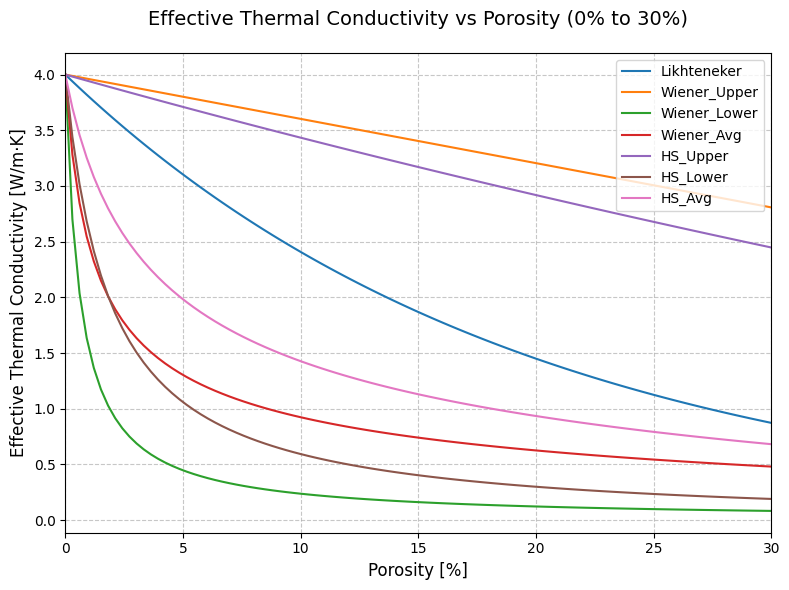

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions (copy-paste the refactored code here)

if __name__ == "__main__":
    # Input parameters
    thermal_conductivities = np.array(LAMBDA_VALUES) # Thermal conductivities

    # Vary TOC from 0% to 30%
    POROSITY = np.linspace(0, 0.3, 100)  # TOC from 0% to 30% (as fractions)
    results = {
        "Likhteneker": [],
        "Wiener_Upper": [],
        "Wiener_Lower": [],
        "Wiener_Avg": [],
        "HS_Upper": [],
        "HS_Lower": [],
        "HS_Avg": []
    }

    # Calculate effective thermal conductivity for each TOC value
    for por in POROSITY:
        volume_fractions = np.array([1 - por, por])  # Matrix and kerogen fractions

        results["Likhteneker"].append(Likhteneker(volume_fractions, thermal_conductivities))
        results["Wiener_Upper"].append(Wiener_Upper_Bound(volume_fractions, thermal_conductivities))
        results["Wiener_Lower"].append(Wiener_Lower_Bound(volume_fractions, thermal_conductivities))
        results["Wiener_Avg"].append(Wiener_Average(volume_fractions, thermal_conductivities))
        results["HS_Upper"].append(Upper_Hashin_Strikman(volume_fractions, thermal_conductivities))
        results["HS_Lower"].append(Lower_Hashin_Strikman(volume_fractions, thermal_conductivities))
        results["HS_Avg"].append(Hashin_Strikman_Average(volume_fractions, thermal_conductivities))

    # Plot results


    plt.figure(figsize=(8, 6))
    for model, values in results.items():
        plt.plot(POROSITY * 100, values, label=model)

    # Add labels, title, legend, and grid
    plt.xlabel("Porosity [%]", fontsize=12)
    plt.ylabel("Effective Thermal Conductivity [W/m·K]", fontsize=12)
    plt.title("Effective Thermal Conductivity vs Porosity (0% to 30%)", fontsize=14, pad=20)
    plt.legend(loc="upper right", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.xlim(0, 30)  # Set x-axis limits
    plt.tight_layout()
    plt.show()

## GSA (isotropic case: Self-consistent, F-model)

In [17]:
import numpy as np
from typing import List, Union, Tuple

class GSAModel:
    """
    Generalized Self-Consistent Approach (GSA) model for calculating effective thermal conductivity
    of isotropic composite materials with ellipsoidal inclusions.

    Attributes:
        phi (np.ndarray): Volume fractions of each component (must sum to 1)
        lambda_i (np.ndarray): Thermal conductivities of each component (W/m·K)
        alpha_shape (np.ndarray): Shape factors (aspect ratios) of inclusions
        max_iter (int): Maximum iterations for convergence
        tol (float): Tolerance for convergence
    """

    def __init__(self, phi: Union[List[float], np.ndarray],
                 lambda_i: Union[List[float], np.ndarray],
                 alpha_shape: Union[List[float], np.ndarray],
                 max_iter: int = 1000,
                 tol: float = 1e-6):
        """
        Initialize the GSA model with material parameters.
        """
        self.phi = np.asarray(phi)
        self.lambda_i = np.asarray(lambda_i)
        self.alpha_shape = np.asarray(alpha_shape)
        self.max_iter = max_iter
        self.tol = tol

        self._validate_inputs()

    def _validate_inputs(self) -> None:
        """Validate input parameters."""
        if not np.isclose(np.sum(self.phi), 1.0, atol=1e-4):
            raise ValueError("Volume fractions must sum to 1")

        if len(self.phi) != len(self.lambda_i) or len(self.phi) != len(self.alpha_shape):
            raise ValueError("phi, lambda_i, and alpha_shape must have the same length")

        if any(self.phi < 0) or any(self.phi > 1):
            raise ValueError("Volume fractions must be between 0 and 1")

        if any(self.lambda_i <= 0):
            raise ValueError("Thermal conductivities must be positive")

        if any(self.alpha_shape <= 0):
            raise ValueError("Shape factors must be positive")

    @staticmethod
    def depolarization_factor(alpha: float) -> float:
        """
        Calculate the depolarization factor for an ellipsoidal inclusion.

        Args:
            alpha: Aspect ratio of the inclusion (alpha = a/c for spheroid)

        Returns:
            Depolarization factor (0 < F < 1)
        """
        if alpha < 1:  # Oblate spheroid
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2 - 1)
            t5 = np.arctan(t4)
            return t2 * (t4 - t5) / (t4 ** 3)
        elif alpha > 1:  # Prolate spheroid
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1 - t2)
            t6 = np.log((1 + t4) / (1 - t4))
            return t2 * (0.5 * t6 - t4) / (t4 ** 3)
        else:  # Sphere
            return 1 / 3

    def _calculate_effective_tc_iteration(self, lambda_eff: float) -> float:
        """
        Perform one iteration of the self-consistent calculation.

        Args:
            lambda_eff: Current estimate of effective thermal conductivity

        Returns:
            Updated estimate of effective thermal conductivity
        """
        numerator, denominator = 0.0, 0.0

        for phi_i, lambda_i, alpha in zip(self.phi, self.lambda_i, self.alpha_shape):
            F = self.depolarization_factor(alpha)

            # Parallel component (numerator terms)
            term_parallel = (phi_i * lambda_i) / (lambda_eff * (1 - F) + lambda_i * F)

            # Perpendicular component (denominator terms)
            term_perpendicular = phi_i / (lambda_eff * (1 - F) + lambda_i * F)

            # Average over all orientations (isotropic case)
            numerator += term_parallel
            denominator += term_perpendicular

        return numerator / denominator

    def calculate_effective_tc(self) -> Tuple[float, int]:
        """
        Calculate the effective thermal conductivity using the GSA model.

        Returns:
            Tuple of (effective_conductivity, iterations)
        """
        lambda_eff = self.lambda_i[0]  # Initial guess (matrix conductivity)

        for iteration in range(self.max_iter):
            new_lambda_eff = self._calculate_effective_tc_iteration(lambda_eff)

            if abs(new_lambda_eff - lambda_eff) < self.tol:
                return new_lambda_eff, iteration + 1

            lambda_eff = new_lambda_eff

        raise RuntimeError(f"GSA model did not converge in {self.max_iter} iterations")

In [18]:
input_data

,Phase,Component type,Thermal Conductivity,Volume/Porosity,Aspect Ratio,Anisotropy,Hierarchy of component
0,Solid Phase,Calcite,3.00,70.0,1.000,NaN,1.0
1,Solid Phase,Quartz,7.60,5.0,1.000,NaN,1.0
2,Solid Phase,Dolomite,2.80,25.0,0.800,NaN,1.0
3,Fluid Phase,Pore 1,0.60,10.0,0.100,NaN,1.0
4,Fluid Phase,Pore 2,0.13,4.0,0.500,NaN,1.0
5,Fluid Phase,Cracks,0.13,0.8,0.001,Yes,2.0


## Example usage

## GSA | FULL | NEW

In [19]:
import numpy as np
from typing import List, Union, Tuple, Optional
from scipy import integrate
from numpy import linalg as LA
from math import pi


class GSAModel:
    """
    Generalized Self-Consistent Approach (GSA) model for calculating effective thermal conductivity
    of composite materials with ellipsoidal inclusions (both isotropic and anisotropic).
    """

    def __init__(self,
                 phi: Union[List[float], np.ndarray],
                 lambda_i: Union[List[float], List[np.ndarray]],
                 alpha_shape: Union[List[float], List[List[float]]],
                 max_iter: int = 1000,
                 tol: float = 1e-6,
                 method: str = 'self-consistent',
                 f_param: Optional[Union[List[float], np.ndarray]] = None,
                 isotropic: bool = True):

        self.phi = np.asarray(phi)
        self.lambda_i = [np.asarray(lam) if isinstance(lam, (list, np.ndarray)) else lam
                        for lam in lambda_i]
        self.alpha_shape = [np.asarray(alpha) if isinstance(alpha, (list, np.ndarray)) else alpha
                           for alpha in alpha_shape]
        self.max_iter = max_iter
        self.tol = tol
        self.method = method.lower()
        self.f_param = np.asarray(f_param) if f_param is not None else None
        self.isotropic = isotropic

        self._validate_inputs()
        self._process_inputs()

    def _validate_inputs(self) -> None:
        """Validate input parameters."""
        if not np.isclose(np.sum(self.phi), 1.0, atol=1e-4):
            raise ValueError("Volume fractions must sum to 1")

        if len(self.phi) != len(self.lambda_i) or len(self.phi) != len(self.alpha_shape):
            raise ValueError("phi, lambda_i, and alpha_shape must have same length")

        if any(self.phi < 0) or any(self.phi > 1):
            raise ValueError("Volume fractions must be between 0 and 1")

        if self.method not in ['self-consistent', 'f-model']:
            raise ValueError("Method must be 'self-consistent' or 'f-model'")

        if self.method == 'f-model' and self.f_param is None:
            raise ValueError("f_param must be provided for 'f-model' method")

    def _process_inputs(self) -> None:
        """Convert inputs to consistent tensor/scalar formats."""
        if self.isotropic:
            self.lambda_i = [np.eye(3)*lam if np.isscalar(lam) else lam
                            for lam in self.lambda_i]
        else:
            for i, lam in enumerate(self.lambda_i):
                if np.isscalar(lam):
                    raise ValueError("Anisotropic mode requires tensor inputs")

        if self.isotropic:
            self.alpha_shape = [alpha if np.isscalar(alpha) else alpha[0]
                              for alpha in self.alpha_shape]
        else:
            for i, alpha in enumerate(self.alpha_shape):
                if np.isscalar(alpha):
                    self.alpha_shape[i] = [alpha, alpha, alpha]

    @staticmethod
    def depolarization_factor(alpha: float) -> float:
        """Isotropic depolarization factor (scalar)."""
        if alpha < 1:  # Oblate spheroid
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2 - 1)
            t5 = np.arctan(t4)
            return t2 * (t4 - t5) / (t4 ** 3)
        elif alpha > 1:  # Prolate spheroid
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1 - t2)
            t6 = np.log((1 + t4) / (1 - t4))
            return t2 * (0.5 * t6 - t4) / (t4 ** 3)
        else:  # Sphere
            return 1 / 3

    def _calculate_g_isotropic(self, alpha: float, lambda_c: float) -> float:
        """Isotropic G factor calculation."""
        F = self.depolarization_factor(alpha)
        return F / lambda_c

    @staticmethod
    def calculate_g_tensor(alpha: List[float], X_c: np.ndarray) -> np.ndarray:
        """Anisotropic G-tensor calculation."""
        a1, a2, a3 = alpha
        g_components = np.zeros((3, 3))

        def integrand(theta, phi):
            n = np.array([
                np.sin(theta)*np.cos(phi)/a1,
                np.sin(theta)*np.sin(phi)/a2,
                np.cos(theta)/a3
            ])
            Lambda = np.sum(n[:, None] * X_c * n[None, :])
            Lambda = 1/Lambda * np.sin(theta)
            return (-1/(4*pi)) * np.outer(n, n) * Lambda

        for x in range(3):
            for y in range(3):
                result, _ = integrate.nquad(
                    lambda theta, phi: integrand(theta, phi)[x, y],
                    [[0, pi], [0, 2*pi]]
                )
                g_components[x, y] = result
        return g_components

    def _iso_sc_iteration(self, lambda_eff: float) -> float:
        """Isotropic self-consistent iteration."""
        numerator, denominator = 0.0, 0.0
        for phi_i, lam, alpha in zip(self.phi, self.lambda_i, self.alpha_shape):
            lambda_i = np.mean(np.diag(lam))
            F = self.depolarization_factor(alpha)
            term_parallel = (phi_i * lambda_i) / (lambda_eff * (1 - F) + lambda_i * F)
            term_perpendicular = phi_i / (lambda_eff * (1 - F) + lambda_i * F)
            numerator += term_parallel
            denominator += term_perpendicular
        return numerator / denominator

    def _iso_fmodel_calculation(self, lambda_c: float) -> float:
        """Isotropic F-model direct calculation."""
        numerator, denominator = 0.0, 0.0
        for phi_i, lam, alpha in zip(self.phi, self.lambda_i, self.alpha_shape):
            lambda_i = np.mean(np.diag(lam))
            G = self._calculate_g_isotropic(alpha, lambda_c)
            M_inv = 1 / (1 - G * (lambda_i - lambda_c))
            A = M_inv * lambda_i
            numerator += phi_i * A
            denominator += phi_i * M_inv
        return numerator / denominator

    def _isotropic_calculation(self) -> Tuple[float, int]:
        """Simplified isotropic calculation."""
        if self.method == 'self-consistent':
            lambda_eff = np.mean(np.diag(self.lambda_i[0]))
            for iteration in range(self.max_iter):
                new_lambda_eff = self._iso_sc_iteration(lambda_eff)
                if abs(new_lambda_eff - lambda_eff) < self.tol:
                    return new_lambda_eff, iteration+1
                lambda_eff = new_lambda_eff
            raise RuntimeError(f"No convergence in {self.max_iter} iterations")
        else:  # F-model
            lambda_c = np.sum([f*np.mean(np.diag(lam))
                             for f, lam in zip(self.f_param, self.lambda_i)])
            return self._iso_fmodel_calculation(lambda_c), 1

    def _anisotropic_calculation(self) -> Tuple[np.ndarray, int]:
        """Full anisotropic tensor calculation."""
        if self.method == 'self-consistent':
            X_prev = self.lambda_i[0]
        else:  # F-model
            X_prev = sum(f*lam for f, lam in zip(self.f_param, self.lambda_i))

        for iteration in range(self.max_iter):
            G_tensors = [self.calculate_g_tensor(alpha, X_prev)
                        for alpha in self.alpha_shape]
            M_inv = [LA.inv(np.eye(3) - G @ (lam - X_prev))
                    for G, lam in zip(G_tensors, self.lambda_i)]
            A = [M_i @ lam for M_i, lam in zip(M_inv, self.lambda_i)]
            TC_c = sum(c*A_i for c, A_i in zip(self.phi, A))
            TC_z = LA.inv(sum(c*M_i for c, M_i in zip(self.phi, M_inv)))
            X_new = TC_c @ TC_z

            if self.method == 'f-model' or np.allclose(X_new, X_prev, atol=self.tol):
                return (np.mean(np.diag(X_new)) if self.isotropic else X_new, iteration+1)
            X_prev = X_new

        raise RuntimeError(f"No convergence in {self.max_iter} iterations")

    def calculate_effective_tc(self) -> Tuple[Union[float, np.ndarray], int]:
        """Main calculation interface."""
        if self.isotropic:
            return self._isotropic_calculation()
        return self._anisotropic_calculation()

    def calculate_effective_tc_bounds(self) -> Tuple[float, float]:
        """Wiener bounds (always returns isotropic values)."""
        if self.isotropic:
            lambdas = [np.mean(np.diag(lam)) if isinstance(lam, np.ndarray) else lam
                      for lam in self.lambda_i]
        else:
            lambdas = [np.mean(np.diag(lam)) for lam in self.lambda_i]
        return (1/np.sum(self.phi/lambdas), np.sum(self.phi*lambdas))


def gsa_model(method: str,
              concentrations: Union[List[float], np.ndarray],
              lambda_values: Union[List[float], List[np.ndarray]],
              alpha_shapes: Union[List[float], List[List[float]]],
              isotropic: bool = True,
              f_paramtr: Optional[Union[List[float], np.ndarray]] = None) -> Tuple[Union[float, np.ndarray], int]:
    """
    Generalized Self-Consistent Approach (GSA) model function interface.

    Parameters:
        method: Calculation method ('self-consistent' or 'f-model')
        concentrations: Volume fractions of components (must sum to 1)
        lambda_values: Thermal conductivities of components (scalars or tensors)
        alpha_shapes: Shape parameters (aspect ratios) of inclusions
        isotropic: Whether to use isotropic calculation (default True)
        f_paramtr: f-parameters for f-model (required when method='f-model')

    Returns:
        Tuple containing effective thermal conductivity (scalar or tensor) and number of iterations

    Example:
        >>> concentrations = [0.7, 0.3]
        >>> lambda_values = [1.0, 10.0]  # Thermal conductivities
        >>> alpha_shapes = [1.0, 2.0]   # Aspect ratios
        >>> result, iterations = gsa_model('self-consistent', concentrations, lambda_values, alpha_shapes)
    """
    model = GSAModel(phi=concentrations,
                    lambda_i=lambda_values,
                    alpha_shape=alpha_shapes,
                    method=method,
                    f_param=f_paramtr,
                    isotropic=isotropic)

    return model.calculate_effective_tc()

### Usage Example

#### Input data



In [20]:
# # USER INPUT PARAMETERS (ADJUST THESE FOR DIFFERENT CASES)
N_COMPONENTS = 3  # Number of components (matrix + inclusions)
LAMBDA_VALUES = [4, 0.6, 0.025]  # Thermal conductivity for each component
CONCENTRATIONS = [0.92, 0.075, 0.005]  # Volume fractions (must sum to 1)
ALPHA_SHAPES = [
    [1.0, 1.0, 1.0],  # Aspect ratios for component 1 (matrix)
    [1.0, 1.0, 1.0],  # Aspect ratios for component 2 (fibers)
    [10, 10, 1]   # Aspect ratios for component 3 (spheres)
]

#### Basic Isotropic Calculation (Self-Consistent Method)

In [21]:
# Using the class directly
model = GSAModel(phi=CONCENTRATIONS,
                lambda_i=LAMBDA_VALUES,
                alpha_shape=ALPHA_SHAPES,
                method='self-consistent',
                )
result, iterations = model.calculate_effective_tc()
print(f"Effective TC: {result:.4f} W/m·K (converged in {iterations} iterations)")

Effective TC: 3.6259 W/m·K (converged in 5 iterations)


#### Isotropic Calculation with F-Model

In [22]:
f_paramtr = [0.6, 0.2, 0.2]

model = GSAModel(phi=CONCENTRATIONS,
                lambda_i=LAMBDA_VALUES,
                alpha_shape=ALPHA_SHAPES,
                method='f-model',
                f_param=f_paramtr,
                isotropic=True)

result, iterations = model.calculate_effective_tc()
print(f"Effective TC: {result:.4f} W/m·K (converged in {iterations} iterations)")

Effective TC: 3.8154 W/m·K (converged in 1 iterations)


#### Anisotropic Calculation (Tensor Inputs)

In [23]:
# Define conductivity tensors (3x3 numpy arrays)
lambda_matrix = np.eye(3) * 4.0  # Isotropic matrix
lambda_fiber1 = np.diag([0.60, 0.6, 0.6])  # Anisotropic fiber
lambda_fiber2 = np.diag([0.025, 0.025, 0.025])  # Anisotropic fiber

concentrations = [0.92, 0.075, 0.005]
alpha_shapes = [
    [1.0, 1.0, 1.0],  # Aspect ratios for component 1 (matrix)
    [1.0, 1.0, 1.0],  # Aspect ratios for component 2 (fibers)
    [10, 10, 1]   # Aspect ratios for component 3 (spheres)
]

model = GSAModel(phi=concentrations,
                lambda_i=[lambda_matrix, lambda_fiber1, lambda_fiber2],
                alpha_shape=alpha_shapes,
                method='self-consistent',
                isotropic=False)


result_tensor, iterations = model.calculate_effective_tc()
print("Effective conductivity tensor | Self-consistent:")
print(np.round(result_tensor,2), end="\n\n")

f_paramtr = [0.6, 0.2, 0.2]
model = GSAModel(phi=concentrations,
                lambda_i=[lambda_matrix, lambda_fiber1, lambda_fiber2],
                alpha_shape=alpha_shapes,
                method='f-model',
                isotropic=False,
                f_param=f_paramtr
                )


result_tensor, iterations = model.calculate_effective_tc()
print("Effective conductivity tensor | F-model:")
print(np.round(result_tensor,2))

Effective conductivity tensor | Self-consistent:
[[ 3.62  0.    0.  ]
 [ 0.    3.62 -0.  ]
 [ 0.   -0.    3.52]]

Effective conductivity tensor | F-model:
[[ 3.59  0.    0.  ]
 [ 0.    3.59 -0.  ]
 [ 0.   -0.    3.47]]


## From Scratc - Table (One value calclution)

In [24]:
class MaterialProcessor:
    """
    Processes material data and performs hierarchical thermal conductivity calculations.
    """

    def __init__(self, data):
        """
        Initialize with material data.
        """
        if isinstance(data, str):
            if data.endswith('.csv'):
                self.df = pd.read_csv(data)
            elif data.endswith('.xlsx'):
                self.df = pd.read_excel(data)
        else:
            self.df = pd.DataFrame(data)

        # Convert percentage porosity to fraction if needed
        if (self.df['Volume/Porosity'] > 1).any():
            self.df['Volume/Porosity'] /= 100

    def _normalize_volumes(self, df):
        """Normalize volume fractions to sum to 1 within a dataframe."""
        total = df['Volume/Porosity'].sum()
        return df.assign(Normalized_phi=df['Volume/Porosity'] / total)

    def calculate_effective_tc_hierarchy(
        processor,
        solid_model_func,
        fluid_model_func,
        final_model_func,
        verbose=True
    ):
        results = {}

        # 1. Solid phase
        solid_df = processor._normalize_volumes(processor.df[processor.df['Phase'] == 'Solid Phase'])
        solid_tc, _ = solid_model_func(
            solid_df['Normalized_phi'].values,
            solid_df['Thermal Conductivity'].values,
            solid_df['Aspect Ratio'].values
        )
        results['Solid Phase'] = solid_tc
        if verbose:
            print(f"Solid phase effective TC: {solid_tc:.3f} W/m·K")

        current_tc = solid_tc

        # 2. Fluid phases by hierarchy
        total_fluid = processor.df[processor.df['Phase'] == 'Fluid Phase']['Volume/Porosity'].sum()

        for level in sorted(processor.df['Hierarchy of component'].unique()):
            level_df = processor.df[(processor.df['Phase'] == 'Fluid Phase') &
                                  (processor.df['Hierarchy of component'] == level)]
            if level_df.empty:
                continue

            level_df_norm = processor._normalize_volumes(level_df)
            fluid_tc, _ = fluid_model_func(
                level_df_norm['Normalized_phi'].values,
                level_df_norm['Thermal Conductivity'].values,
                level_df_norm['Aspect Ratio'].values
            )
            results[f'Fluid Level {level}'] = fluid_tc
            if verbose:
                print(f"Fluid phase Level {level} TC: {fluid_tc:.3f} W/m·K")

            level_phi = level_df['Volume/Porosity'].sum()

            if level == 1.0:
                combined_phi = [1 - total_fluid, total_fluid]
                combined_lambda = [solid_tc, fluid_tc]
            else:
                combined_phi = [1 - level_phi, level_phi]
                combined_lambda = [current_tc, fluid_tc]

            combined_tc, _ = final_model_func(
                combined_phi,
                combined_lambda,
                [1.0, 1.0]
            )
            results[f'Combined Level {level}'] = combined_tc
            if verbose:
                print(f"Combined TC after Level {level}: {combined_tc:.3f} W/m·K")

            current_tc = combined_tc

        results['Final TC'] = current_tc
        if verbose:
            print(f"Final effective TC: {current_tc:.3f} W/m·K")

        return results


### Usage - 1

In [25]:
if __name__ == "__main__":
    # Your data with hierarchy 1 for all components
    data = {
        'Phase': ['Solid Phase', 'Solid Phase', 'Solid Phase', 'Fluid Phase', 'Fluid Phase', 'Fluid Phase'],
        'Component type': ['Calcite', 'Quartz', 'Dolomite', 'Pore 1', 'Pore 2', 'Cracks'],
        'Thermal Conductivity': [3.00, 7.60, 2.80, 0.60, 0.13, 0.13],
        'Volume/Porosity': [70.0, 5.0, 25.0, 10.0, 4.0, 0.8],
        'Aspect Ratio': [1.000, 1.000, 0.800, 0.100, 0.500, 0.001],
        'Anisotropy': [np.nan, np.nan, np.nan, np.nan, np.nan, 'Yes'],
        'Hierarchy of component': [1.0, 1.0, 1.0, 1.0, 1.0, 2.0]  # All components are level 1
    }

    processor = MaterialProcessor(data)

    # Define a wrapper function that creates GSAModel instance and calls calculate_effective_tc
    def gsa_model_wrapper(phi, lambda_i, alpha_shape):
        model = GSAModel(phi=phi, lambda_i=lambda_i, alpha_shape=alpha_shape)
        return model.calculate_effective_tc()

    # 1. Calculate effective thermal conductivity for all components at once (single hierarchy)
    all_df = processor._normalize_volumes(processor.df)
    all_tc, _ = gsa_model_wrapper(
        all_df['Normalized_phi'].values,
        all_df['Thermal Conductivity'].values,
        all_df['Aspect Ratio'].values
    )
    print(f"Effective TC for all components (single hierarchy): {all_tc:.3f} W/m·K")

    # 2. Use hierarchical calculation with the wrapper function
    hierarchical_results = processor.calculate_effective_tc_hierarchy(
        solid_model_func=gsa_model_wrapper,
        fluid_model_func=gsa_model_wrapper,
        final_model_func=gsa_model_wrapper
    )
    print("\nHierarchical calculation results:")
    for stage, tc in hierarchical_results.items():
        print(f"{stage}: {tc:.3f} W/m·K")

    # 3. Example of safely accessing level 2 (if it exists)
    level2_df = processor.df[(processor.df['Phase'] == 'Fluid Phase') &
                            (processor.df['Hierarchy of component'] == 2.0)]

    if not level2_df.empty:
        cracks_phi = level2_df['Volume/Porosity'].values[0]
        final_tc, _ = gsa_model_wrapper(
            [1 - cracks_phi, cracks_phi],
            [all_tc, level2_df['Thermal Conductivity'].values[0]],
            [1.0, level2_df['Aspect Ratio'].values[0]]
        )
        print(level2_df['Aspect Ratio'].values[0])
        print(f"Final TC with cracks: {final_tc:.3f} W/m·K")
    else:
        print("No level 2 fluid components found (no cracks). Final TC is the combined TC without cracks.")

Effective TC for all components (single hierarchy): 2.142 W/m·K
Solid phase effective TC: 3.103 W/m·K
Fluid phase Level 1.0 TC: 0.374 W/m·K
Combined TC after Level 1.0: 2.539 W/m·K
Fluid phase Level 2.0 TC: 0.130 W/m·K
Combined TC after Level 2.0: 2.510 W/m·K
Final effective TC: 2.510 W/m·K

Hierarchical calculation results:
Solid Phase: 3.103 W/m·K
Fluid Level 1.0: 0.374 W/m·K
Combined Level 1.0: 2.539 W/m·K
Fluid Level 2.0: 0.130 W/m·K
Combined Level 2.0: 2.510 W/m·K
Final TC: 2.510 W/m·K
0.001
Final TC with cracks: 1.925 W/m·K


### Usage - 2

In [26]:
def calculate_effective_tc_hierarchy(
    processor,
    solid_model_func,
    fluid_model_func,
    final_model_func,
    verbose=True
):
    """
    Универсальная функция для расчёта эффективной теплопроводности с иерархией,
    с возможностью выбора модели для каждого этапа.
    """
    results = {}  # Initialize results dictionary

    def _call_model(model_func, phi, lambda_i, alpha_shape):
        """Handle both functions returning single values and classes returning tuples"""
        result = model_func(phi, lambda_i, alpha_shape)
        # If the model returns a tuple (like GSAModel), take just the TC value
        if isinstance(result, tuple):
            return result[0]  # Return only the thermal conductivity
        elif hasattr(result, 'calculate_effective_tc'):  # Handle GSAModel instance
            tc_value, _ = result.calculate_effective_tc()
            return tc_value
        return result  # For functions that return single value

    # 1. Solid phase
    solid_df = processor._normalize_volumes(processor.df[processor.df['Phase'] == 'Solid Phase'])
    solid_tc = _call_model(
        solid_model_func,
        solid_df['Normalized_phi'].values,
        solid_df['Thermal Conductivity'].values,
        solid_df['Aspect Ratio'].values
    )
    results['Solid Phase'] = solid_tc
    if verbose:
        print(f"Solid phase effective TC: {float(solid_tc):.3f} W/m·K")

    current_tc = solid_tc
    remaining_porosity = processor.df[processor.df['Phase'] == 'Fluid Phase']['Volume/Porosity'].sum()

    # 2. Process fluid phases by hierarchy level
    for level in sorted(processor.df['Hierarchy of component'].unique()):
        level_df = processor.df[(processor.df['Phase'] == 'Fluid Phase') &
                              (processor.df['Hierarchy of component'] == level)]
        if level_df.empty:
            continue

        # Calculate effective TC for this level's fluid components
        level_df_norm = processor._normalize_volumes(level_df)
        fluid_tc = _call_model(
            fluid_model_func,
            level_df_norm['Normalized_phi'].values,
            level_df_norm['Thermal Conductivity'].values,
            level_df_norm['Aspect Ratio'].values
        )
        results[f'Fluid Level {level}'] = fluid_tc
        if verbose:
            print(f"Fluid phase Level {level} TC: {float(fluid_tc):.3f} W/m·K")

        # Calculate the volume fraction for this level's fluid components
        level_phi = level_df['Volume/Porosity'].sum()
        remaining_porosity -= level_phi

        # Combine with current effective TC
        if level == 1.0:
            # For first level, combine solid with all fluid
            combined_phi = [1 - level_phi, level_phi]
            combined_lambda = [solid_tc, fluid_tc]
        else:
            # For higher levels, combine current effective TC with this level's fluid
            combined_phi = [1 - level_phi, level_phi]
            combined_lambda = [current_tc, fluid_tc]

        combined_tc = _call_model(
            final_model_func,
            combined_phi,
            combined_lambda,
            [1.0, 1.0]  # Assume isotropic for final combination
        )
        results[f'Combined Level {level}'] = combined_tc
        if verbose:
            print(f"Combined TC after Level {level}: {float(combined_tc):.3f} W/m·K")

        current_tc = combined_tc

    # Handle remaining porosity
    if remaining_porosity > 1e-6 and verbose:
        print(f"Warning: {remaining_porosity:.4f} unaccounted porosity remains")

    results['Final TC'] = current_tc
    if verbose:
        print(f"Final effective TC: {float(current_tc):.3f} W/m·K")

    return results

In [27]:
# With simple function
results = calculate_effective_tc_hierarchy(
    processor=processor,
    solid_model_func=Likhteneker,
    fluid_model_func=Lower_Hashin_Strikman,
    final_model_func=Hashin_Strikman_Average
)

Solid phase effective TC: 3.089 W/m·K
Fluid phase Level 1.0 TC: 0.380 W/m·K
Combined TC after Level 1.0: 2.344 W/m·K
Fluid phase Level 2.0 TC: 0.130 W/m·K
Combined TC after Level 2.0: 2.274 W/m·K
Final effective TC: 2.274 W/m·K


In [28]:
# With GSAModel class
results = calculate_effective_tc_hierarchy(
    processor=processor,
    solid_model_func=Likhteneker,  # Class that returns (value, iterations)
    fluid_model_func=Upper_Hashin_Strikman,
    final_model_func=GSAModel
)

Solid phase effective TC: 3.089 W/m·K
Fluid phase Level 1.0 TC: 0.435 W/m·K
Combined TC after Level 1.0: 2.575 W/m·K
Fluid phase Level 2.0 TC: 0.130 W/m·K
Combined TC after Level 2.0: 2.546 W/m·K
Final effective TC: 2.546 W/m·K


In [29]:
model = GSAModel(phi=CONCENTRATIONS,
                lambda_i=LAMBDA_VALUES,
                alpha_shape=ALPHA_SHAPES,
                method='f-model',
                f_param=f_paramtr,
                isotropic=True)

result, iterations = model.calculate_effective_tc()

In [33]:
def gsa_fmodel_wrapper(phi, lambda_i, alpha_shape):
    """Wrapper using F-model method"""
    lambda_tensors = [np.eye(3)*lam if np.isscalar(lam) else np.asarray(lam)
                     for lam in lambda_i]
    alpha_shapes = [alpha if np.isscalar(alpha) else np.asarray(alpha)
                   for alpha in alpha_shape]

    model = GSAModel(
        phi=np.asarray(phi),
        lambda_i=lambda_tensors,
        alpha_shape=alpha_shapes,
        method='self-consistent',
        f_param=np.asarray(phi),
        isotropic=True
    )
    tc_tensor, _ = model.calculate_effective_tc()
    return tc_tensor  # Return the mean of diagonal elements

In [34]:
results= calculate_effective_tc_hierarchy(
    processor=processor,
    solid_model_func=Likhteneker,
    fluid_model_func=Upper_Hashin_Strikman,
    final_model_func=gsa_fmodel_wrapper
)

Solid phase effective TC: 3.089 W/m·K
Fluid phase Level 1.0 TC: 0.435 W/m·K
Combined TC after Level 1.0: 2.575 W/m·K
Fluid phase Level 2.0 TC: 0.130 W/m·K
Combined TC after Level 2.0: 2.546 W/m·K
Final effective TC: 2.546 W/m·K


## Array calcultion

In [59]:
import pandas as pd
import numpy as np
from typing import List, Union, Tuple, Optional
from scipy import integrate
from numpy import linalg as LA
from math import pi

# ================== MATERIAL PROCESSOR CLASS ==================
class MaterialProcessor:
    """Processes material data and performs hierarchical thermal conductivity calculations."""

    def __init__(self, data):
        """Initialize with material data."""
        if isinstance(data, str):
            if data.endswith('.csv'):
                self.df = pd.read_csv(data)
            elif data.endswith('.xlsx'):
                self.df = pd.read_excel(data)
        else:
            self.df = pd.DataFrame(data)

        # Convert percentage porosity to fraction if needed
        if 'Volume/Porosity' in self.df.columns and (self.df['Volume/Porosity'] > 1).any():
            self.df['Volume/Porosity'] /= 100

    def _normalize_volumes(self, df):
        """Normalize volume fractions to sum to 1 within a dataframe."""
        total = df['Volume/Porosity'].sum()
        if total == 0:
            return df.assign(Normalized_phi=0)
        return df.assign(Normalized_phi=df['Volume/Porosity'] / total)

    def create_variation_df(self, component_name, parameter, value_range):
        """Create modified DataFrames with varying parameter values."""
        modified_dfs = []
        if component_name not in self.df['Component'].values:
            raise ValueError(f"Component '{component_name}' not found in data")
        if parameter not in self.df.columns:
            raise ValueError(f"Parameter '{parameter}' not found in data")

        original_value = self.df.loc[self.df['Component'] == component_name, parameter].values[0]
        for value in value_range:
            modified_df = self.df.copy()
            modified_df.loc[modified_df['Component'] == component_name, parameter] = value
            modified_dfs.append(modified_df)
        return modified_dfs

# ================== CORE CALCULATION FUNCTIONS ==================
def _call_model(model_func, phi, lambda_i, alpha_shape=None):
    """Universal model caller that handles both functions and classes."""
    if len(phi) == 0:
        return 0.0

    # Handle function calls
    if callable(model_func) and not isinstance(model_func, type):
        result = model_func(phi, lambda_i, alpha_shape)
        return result[0] if isinstance(result, tuple) else result
    # Handle class instantiation
    else:
        model = model_func(phi, lambda_i, alpha_shape)
        if hasattr(model, 'calculate_effective_tc'):
            tc_value, _ = model.calculate_effective_tc()
            return tc_value
        return model  # For classes that return directly

def calculate_effective_tc_hierarchy(processor, solid_model_func, fluid_model_func,
                                   final_model_func, variation_params=None, verbose=True):
    """Main hierarchical calculation function."""
    if variation_params is not None:
        # Handle parameter variations
        if len(variation_params['range']) == 3:
            values = np.linspace(*variation_params['range'])
        else:
            values = variation_params['range']

        modified_dfs = processor.create_variation_df(
            variation_params['component'],
            variation_params['parameter'],
            values
        )

        all_results = []
        for i, value in enumerate(values):
            if verbose:
                print(f"\nCalculation for {variation_params['parameter']} = {value:.4f}")

            temp_processor = MaterialProcessor(modified_dfs[i])
            results = _calculate_single_case(temp_processor, solid_model_func,
                                           fluid_model_func, final_model_func, verbose)
            results['variation_value'] = value
            all_results.append(results)
        return all_results
    else:
        # Single calculation case
        return _calculate_single_case(processor, solid_model_func,
                                    fluid_model_func, final_model_func, verbose)

def _calculate_single_case(processor, solid_model_func, fluid_model_func, final_model_func, verbose):
    """Calculate effective TC for a single configuration."""
    results = {}

    # 1. Solid phase calculation
    solid_df = processor._normalize_volumes(processor.df[processor.df['Phase'] == 'Solid Phase'])
    solid_phi = solid_df['Normalized_phi'].values
    solid_lambda = solid_df['Thermal Conductivity'].values
    solid_alpha = solid_df['Aspect Ratio'].values

    # Ensure normalization for GSAModel
    if isinstance(solid_model_func, type) and issubclass(solid_model_func, GSAModel):
        solid_phi = solid_phi / np.sum(solid_phi)

    solid_tc = _call_model(solid_model_func, solid_phi, solid_lambda, solid_alpha)
    results['Solid Phase'] = solid_tc
    if verbose:
        print(f"Solid phase effective TC: {_format_tc(solid_tc):.3f} W/m·K")

    # 2. Process fluid phases by hierarchy level
    current_tc = solid_tc
    total_fluid = processor.df[processor.df['Phase'] == 'Fluid Phase']['Volume/Porosity'].sum()
    remaining_porosity = total_fluid

    for level in sorted(processor.df['Hierarchy of component'].unique()):
        level_df = processor.df[(processor.df['Phase'] == 'Fluid Phase') &
                              (processor.df['Hierarchy of component'] == level)]
        if level_df.empty:
            continue

        level_df_norm = processor._normalize_volumes(level_df)
        fluid_phi = level_df_norm['Normalized_phi'].values
        fluid_lambda = level_df_norm['Thermal Conductivity'].values
        fluid_alpha = level_df_norm['Aspect Ratio'].values

        # Ensure normalization for GSAModel
        if isinstance(fluid_model_func, type) and issubclass(fluid_model_func, GSAModel):
            fluid_phi = fluid_phi / np.sum(fluid_phi)

        fluid_tc = _call_model(fluid_model_func, fluid_phi, fluid_lambda, fluid_alpha)
        results[f'Fluid Level {level}'] = fluid_tc
        if verbose:
            print(f"Fluid phase Level {level} TC: {_format_tc(fluid_tc):.3f} W/m·K (AR: {fluid_alpha[0]:.6f})")

        level_phi = level_df['Volume/Porosity'].sum()
        remaining_porosity -= level_phi

        # Combine phases with proper normalization for final model
        if level == 1.0:
            combined_phi = np.array([1 - total_fluid, level_phi])
        else:
            combined_phi = np.array([1 - level_phi, level_phi])

        combined_lambda = [current_tc, fluid_tc]
        combined_alpha = [1.0, fluid_alpha[0]]  # Include the aspect ratio in final combination

        # Normalize for GSAModel if needed
        if isinstance(final_model_func, type) and issubclass(final_model_func, GSAModel):
            combined_phi = combined_phi / np.sum(combined_phi)

        combined_tc = _call_model(final_model_func, combined_phi, combined_lambda, combined_alpha)
        results[f'Combined Level {level}'] = combined_tc
        if verbose:
            print(f"Combined TC after Level {level}: {_format_tc(combined_tc):.3f} W/m·K (AR: {combined_alpha[1]:.6f})")
        current_tc = combined_tc

    results['Final TC'] = current_tc
    if verbose:
        print(f"Final effective TC: {_format_tc(current_tc):.3f} W/m·K")
    return results

def _format_tc(tc_value):
    """Format thermal conductivity value for printing (handles arrays)."""
    return np.mean(np.diag(tc_value)) if isinstance(tc_value, np.ndarray) else tc_value

# ================== MULTIPLE VARIATIONS HANDLING ==================
def calculate_multiple_variations(processor, solid_model_func, fluid_model_func,
                                final_model_func, variation_params_list, verbose=True):
    """Calculate effective TC for multiple parameter variations."""
    all_results = {}
    for i, variation_params in enumerate(variation_params_list):
        if verbose:
            print(f"\nVariation {i+1}: {variation_params['parameter']} of {variation_params['component']}")

        results = calculate_effective_tc_hierarchy(
            processor=processor,
            solid_model_func=solid_model_func,
            fluid_model_func=fluid_model_func,
            final_model_func=final_model_func,
            variation_params=variation_params,
            verbose=verbose
        )
        key = f"Var{i+1}_{variation_params['component']}_{variation_params['parameter']}"
        all_results[key] = results
    return all_results

def clean_sheet_name(name):
    """Create valid Excel sheet names by replacing invalid characters."""
    invalid_chars = ['/', '\\', '?', '*', ':', '[', ']']
    for char in invalid_chars:
        name = name.replace(char, '_')
    return name.strip()[:31]  # Excel sheet names max length is 31


#### Измение одного параметра

In [ ]:
data = {
    'Phase': ['Solid Phase', 'Solid Phase', 'Solid Phase', 'Fluid Phase', 'Fluid Phase', 'Fluid Phase'],
    'Component': ['Calcite', 'Quartz', 'Dolomite', 'Pore 1', 'Pore 2', 'Cracks'],
    'Thermal Conductivity': [3.00, 7.60, 2.80, 0.60, 0.13, 0.13],
    'Volume/Porosity': [70.0, 5.0, 25.0, 10.0, 4.0, 5],
    'Aspect Ratio': [1.000, 1.000, 0.800, 0.100, 0.500, 0.001],
    'Anisotropy': [np.nan, np.nan, np.nan, np.nan, np.nan, 'Yes'],
    'Hierarchy of component': [1.0, 1.0, 1.0, 1.0, 1.0, 2.0]  # All components are level 1
}

In [65]:
# Example usage with mixed models
if __name__ == "__main__":
    # Sample data
    data = {
        'Phase': ['Solid Phase', 'Fluid Phase'],
        'Component': ['Calcite', 'Pore 1'],
        'Thermal Conductivity': [3.00, 0.60],
        'Volume/Porosity': [70.0, 30.0],
        'Aspect Ratio': [1.000, 1e-3],
        'Anisotropy': [np.nan, np.nan],
        'Hierarchy of component': [1.0, 1.0]  # All components are level 1
    }
    processor = MaterialProcessor(data)

    print("\nExample with mixed models")
    results_mixed = calculate_effective_tc_hierarchy(
        processor=processor,
        solid_model_func=Upper_Hashin_Strikman,  # Function
        fluid_model_func=GSAModel,               # Class
        final_model_func=GSAModel,               # Class
        verbose=True
    )

    # print("\nExample with parameter variation and mixed models")
    # variation_params = {
    #     'component': 'Pore 1',
    #     'parameter': 'Volume/Porosity',
    #     'range': [1e-4, 0.3, 0.05]  # From 0 to 30% in 5% steps
    # }

    print("\nExample with parameter variation and mixed models")
    variation_params = {
        'component': 'Pore 1',
        # 'parameter': 'Volume/Porosity',
        'parameter': 'Aspect Ratio',
        'range': np.logspace(-4, 0, 10)
    }

# np.linspace(1e-3, 30, 10)

    results_variation = calculate_effective_tc_hierarchy(
        processor=processor,
        solid_model_func=GSAModel,             # Function
        fluid_model_func=GSAModel,               # Class
        final_model_func=GSAModel,               # Class
        variation_params=variation_params,
        verbose=True
    )

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results_variation)
    print("\nSummary of variation results:")
    print(results_df[['variation_value', 'Final TC']])


Example with mixed models
Solid phase effective TC: 3.000 W/m·K
Fluid phase Level 1.0 TC: 0.600 W/m·K (AR: 0.001000)
Combined TC after Level 1.0: 1.575 W/m·K (AR: 0.001000)
Final effective TC: 1.575 W/m·K

Example with parameter variation and mixed models

Calculation for Aspect Ratio = 0.0001
Solid phase effective TC: 3.000 W/m·K
Fluid phase Level 1.0 TC: 0.600 W/m·K (AR: 0.000100)
Combined TC after Level 1.0: 1.574 W/m·K (AR: 0.000100)
Final effective TC: 1.574 W/m·K

Calculation for Aspect Ratio = 0.0003
Solid phase effective TC: 3.000 W/m·K
Fluid phase Level 1.0 TC: 0.600 W/m·K (AR: 0.000278)
Combined TC after Level 1.0: 1.574 W/m·K (AR: 0.000278)
Final effective TC: 1.574 W/m·K

Calculation for Aspect Ratio = 0.0008
Solid phase effective TC: 3.000 W/m·K
Fluid phase Level 1.0 TC: 0.600 W/m·K (AR: 0.000774)
Combined TC after Level 1.0: 1.575 W/m·K (AR: 0.000774)
Final effective TC: 1.575 W/m·K

Calculation for Aspect Ratio = 0.0022
Solid phase effective TC: 3.000 W/m·K
Fluid phase 

In [66]:
results_df[['variation_value', 'Final TC']]

,variation_value,Final TC
0,0.000100,1.574209
1,0.000278,1.574431
2,0.000774,1.575046
3,0.002154,1.576755
4,0.005995,1.581483
5,0.016681,1.594433
6,0.046416,1.628869
7,0.129155,1.712792
8,0.359381,1.872989
9,1.000000,2.057437


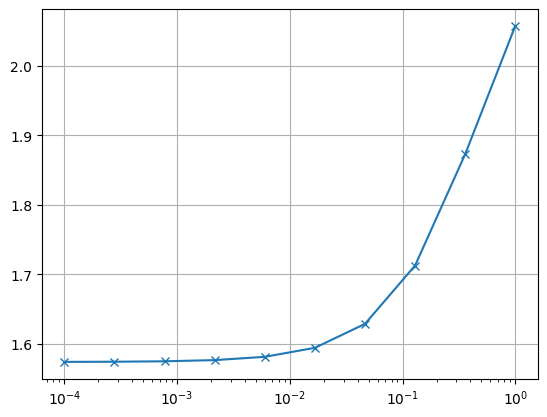

In [68]:
import matplotlib.pyplot as plt

plt.plot(results_df['variation_value'], results_df['Final TC'], marker='x')
# Задаём логарифмическую шкалу по оси X
plt.xscale('log')
# plt.ylim(1.8, 3)
plt.grid(True)
plt.show()


#### Изменение нескольких параметров

In [69]:
# ================== MAIN EXECUTION ==================
if __name__ == "__main__":
    # Sample data
    data = {
        'Phase': ['Solid Phase', 'Solid Phase', 'Solid Phase', 'Fluid Phase', 'Fluid Phase', 'Fluid Phase'],
        'Component': ['Calcite', 'Quartz', 'Dolomite', 'Pore 1', 'Pore 2', 'Cracks'],
        'Thermal Conductivity': [3.00, 7.60, 2.80, 0.60, 0.13, 0.13],
        'Volume/Porosity': [70.0, 5.0, 25.0, 10.0, 4.0, 5],
        'Aspect Ratio': [1.000, 1.000, 0.800, 0.100, 0.500, 0.001],
        'Anisotropy': [np.nan, np.nan, np.nan, np.nan, np.nan, 'Yes'],
        'Hierarchy of component': [1.0, 1.0, 1.0, 1.0, 1.0, 2.0]
    }
    processor = MaterialProcessor(data)

    print("\nExample with multiple parameter variations")
    variation_params_list = [
        {'component': 'Cracks', 'parameter': 'Aspect Ratio', 'range': np.logspace(-4, 0, 10)},
        {'component': 'Pore 1', 'parameter': 'Volume/Porosity', 'range': np.linspace(1e-4, 10, 10)}
    ]

    all_variation_results = calculate_multiple_variations(
        processor=processor,
        solid_model_func=Likhteneker,  # Using your existing function
        fluid_model_func=Upper_Hashin_Strikman,  # Using your existing function
        final_model_func=GSAModel,  # Using your existing class
        variation_params_list=variation_params_list,
        verbose=True
    )

    # Save to Excel with multiple sheets
    with pd.ExcelWriter('thermal_conductivity_variations.xlsx') as writer:
        summary_data = []
        for key, results in all_variation_results.items():
            df = pd.DataFrame(results)
            parts = key.split('_')
            component, parameter = parts[1], parts[2]

            df['Variation'] = key
            df['Component'] = component
            df['Parameter'] = parameter

            sheet_name = clean_sheet_name(f"{component}_{parameter}")
            original_name = sheet_name
            counter = 1
            while sheet_name in writer.sheets:
                sheet_name = f"{original_name}_{counter}"
                sheet_name = clean_sheet_name(sheet_name)
                counter += 1

            df.to_excel(writer, sheet_name=sheet_name, index=False)

            summary_data.append({
                'Variation': key,
                'Component': component,
                'Parameter': parameter,
                'Min TC': df['Final TC'].min(),
                'Max TC': df['Final TC'].max(),
                'Mean TC': df['Final TC'].mean(),
                'Sheet Name': sheet_name
            })

        pd.DataFrame(summary_data).to_excel(writer, sheet_name='Summary', index=False)

    print("\nAll variations saved to thermal_conductivity_variations.xlsx")


Example with multiple parameter variations

Variation 1: Aspect Ratio of Cracks

Calculation for Aspect Ratio = 0.0001
Solid phase effective TC: 3.089 W/m·K
Fluid phase Level 1.0 TC: 0.435 W/m·K (AR: 0.100000)
Combined TC after Level 1.0: 2.065 W/m·K (AR: 0.100000)
Fluid phase Level 2.0 TC: 0.130 W/m·K (AR: 0.000100)
Combined TC after Level 2.0: 1.315 W/m·K (AR: 0.000100)
Final effective TC: 1.315 W/m·K

Calculation for Aspect Ratio = 0.0003
Solid phase effective TC: 3.089 W/m·K
Fluid phase Level 1.0 TC: 0.435 W/m·K (AR: 0.100000)
Combined TC after Level 1.0: 2.065 W/m·K (AR: 0.100000)
Fluid phase Level 2.0 TC: 0.130 W/m·K (AR: 0.000278)
Combined TC after Level 2.0: 1.316 W/m·K (AR: 0.000278)
Final effective TC: 1.316 W/m·K

Calculation for Aspect Ratio = 0.0008
Solid phase effective TC: 3.089 W/m·K
Fluid phase Level 1.0 TC: 0.435 W/m·K (AR: 0.100000)
Combined TC after Level 1.0: 2.065 W/m·K (AR: 0.100000)
Fluid phase Level 2.0 TC: 0.130 W/m·K (AR: 0.000774)
Combined TC after Level 2.

In [80]:
results_df = pd.read_excel('thermal_conductivity_variations.xlsx',
                           sheet_name='Cracks_Aspect Ratio')

# sheets = results_df.sheet_names
# sheets

results_df.columns

Index(['Solid Phase', 'Fluid Level 1.0', 'Combined Level 1.0',
       'Fluid Level 2.0', 'Combined Level 2.0', 'Final TC', 'variation_value',
       'Variation', 'Component', 'Parameter'],
      dtype='object')

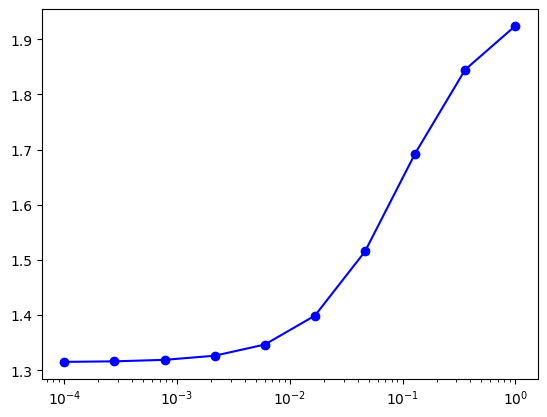

In [85]:
# # Фильтруем данные для Aspect Ratio и Volume/Porosity
# aspect_ratio_data = results_df[results_df['Variation'] == 'Aspect Ratio']
# # porosity_data = results_df[results_df['Variation'] == 'Volume/Porosity']



# График для Aspect Ratio (логарифмическая шкала X)
plt.plot(results_df['variation_value'],
            results_df['Final TC'],
            'o-', color='blue', label='Aspect Ratio Variation')
plt.xscale('log')

In [ ]:
quartz_cond

array([ 5.        ,  5.26315789,  5.52631579,  5.78947368,  6.05263158,
        6.31578947,  6.57894737,  6.84210526,  7.10526316,  7.36842105,
        7.63157895,  7.89473684,  8.15789474,  8.42105263,  8.68421053,
        8.94736842,  9.21052632,  9.47368421,  9.73684211, 10.        ])

# GSA (anisotropic case: Self-consistent, F-model)

---

### Эффективный тензор теплопроводности композита

Эффективный тензор теплопроводности композита $ \mathbf{X}_{\text{eff}} $ вычисляется по следующей формуле:

$$
\mathbf{X}_{\text{eff}} = \left( \sum_{i=1}^{N} c_i \left( \mathbf{I} - \mathbf{G}_i (\mathbf{\lambda}_i - \mathbf{X}_{\text{eff}}) \right)^{-1} \mathbf{\lambda}_i \right) \left( \sum_{i=1}^{N} c_i \left( \mathbf{I} - \mathbf{G}_i (\mathbf{\lambda}_i - \mathbf{X}_{\text{eff}}) \right)^{-1} \right)^{-1},
$$

где:

- $ \mathbf{X}_{\text{eff}} $: Эффективный тензор теплопроводности композита.
- $ c_i $: Объемная доля $ i $-й фазы в композите.
- $ \mathbf{\lambda}_i $: Тензор теплопроводности $ i $-й фазы.
- $ \mathbf{G}_i $: Тензор, зависящий от формы включений $ i $-й фазы и текущего значения $ \mathbf{X}_{\text{eff}} $. Для сферических включений $ \mathbf{G}_i $ может быть выражен аналитически, но для произвольных форм он вычисляется численно.
- $ \mathbf{I} $: Единичная матрица (тождественный тензор).
- $ N $: **Количество фаз в композите.
- $ \left( \mathbf{I} - \mathbf{G}_i (\mathbf{\lambda}_i - \mathbf{X}_{\text{eff}}) \right)^{-1} $: Матрица $ \mathbf{M}_i $, которая связывает свойства $ i $-й фазы с эффективными свойствами композита.

In [ ]:
import numpy as np
from math import pi
from scipy import integrate
from numpy import linalg as LA


def calculate_g_tensor(alpha, X_c):
    """
    Calculate the G tensor for given aspect ratios and comparison tensor.

    Parameters:
        alpha (list): Aspect ratios [a1, a2, a3].
        X_c (np.ndarray): Comparison tensor (3x3 matrix).

    Returns:
        np.ndarray: G tensor (3x3 matrix).
    """
    a1, a2, a3 = alpha
    g_components = np.zeros((3, 3))

    def integrand(theta, phi):
        n = np.array([
            np.sin(theta) * np.cos(phi) / a1,
            np.sin(theta) * np.sin(phi) / a2,
            np.cos(theta) / a3
        ])
        Lambda = np.sum(n[:, None] * X_c * n[None, :])
        Lambda = 1 / Lambda * np.sin(theta)
        a_kl = (-1 / (4 * pi)) * np.outer(n, n) * Lambda
        return a_kl

    for x in range(3):
        for y in range(3):
            result, _ = integrate.nquad(
                lambda theta, phi: integrand(theta, phi)[x, y],
                [[0, pi], [0, 2 * pi]]
            )
            g_components[x, y] = result

    return g_components


def effective_conductivity(CC_method, X_c, concentrations, lambda_tensors, alpha_shapes, isotropic,
                          tolerance=1e-3, max_iter=100):
    """
    Calculate the effective thermal conductivity using an iterative method.

    Parameters:
        CC_method (str): Method to use ('F-model' or others).
        X_c (np.ndarray): Initial comparison tensor (3x3 matrix).
        concentrations (list): Volume fractions of components.
        lambda_tensors (list): List of thermal conductivity tensors (3x3 matrices).
        alpha_shapes (list): List of aspect ratios for each component.
        tolerance (float): Convergence tolerance.
        max_iter (int): Maximum number of iterations.
        isotropic (bool): If True, return the isotropic average.

    Returns:
        np.ndarray: Effective thermal conductivity tensor (3x3 matrix) or isotropic average (scalar).
    """
    X_prev = X_c.copy()
    iteration = 0

    while iteration < max_iter:
        # Calculate G tensors for all components
        G_tensors = [calculate_g_tensor(alpha, X_prev) for alpha in alpha_shapes]

        # Calculate M_inv and A for all components
        M_inv = [LA.inv(np.eye(3) - G @ (lam - X_prev)) for G, lam in zip(G_tensors, lambda_tensors)]
        A = [M_i @ lam for M_i, lam in zip(M_inv, lambda_tensors)]

        # Calculate effective conductivity
        TC_c = sum(c * A_i for c, A_i in zip(concentrations, A))
        TC_z = LA.inv(sum(c * M_i for c, M_i in zip(concentrations, M_inv)))
        X_new = TC_c @ TC_z

        # Check for convergence or if CC_method is 'F-model'
        if CC_method == 'F-model' or np.allclose(X_new, X_prev, atol=tolerance):
            break

        X_prev = X_new
        iteration += 1

    print(f'Converged after {iteration} iterations')

    if isotropic==True:
        # Return the isotropic average (mean of the diagonal elements)
        return np.mean(np.diag(X_new))
    return X_new


def gsa_model(CC_method, COMPARISON_BODY, CONCENTRATIONS, LAMBDA_VALUES, ALPHA_SHAPES, isotropic, f_paramtr=None):

    LAMBDA_VALUES_2D = np.array(LAMBDA_VALUES)

#     lambda_tensors = [ np.full((3, 3), 1e-20)  for lam in LAMBDA_VALUES_2D]

# # Обновляем диагональные элементы
# for i, lam in enumerate(LAMBDA_VALUES_2D):
#     np.fill_diagonal(lambda_tensors[i], lam)


    if LAMBDA_VALUES_2D.ndim == 1:
      lambda_tensors = [np.full((3, 3), 1e-20)  for lam in LAMBDA_VALUES_2D]
      for i, lam in enumerate(LAMBDA_VALUES_2D):
        np.fill_diagonal(lambda_tensors[i], lam)
      # lambda_tensors = [np.diagflat([lam] * 3) for lam in LAMBDA_VALUES_2D]
    else:
      lambda_tensors = LAMBDA_VALUES

    if CC_method == 'F-model':
        if f_paramtr is None:
            raise ValueError("f_paramtr must be provided for 'F-model' method")
        X0 = sum(f * lam for f, lam in zip(f_paramtr, lambda_tensors))

    elif CC_method == 'Self-consistent':
        X0 = COMPARISON_BODY

    else:
        raise ValueError("CC_method must be 'F-model' or 'Self-consistent'")

    return effective_conductivity(CC_method, X0, CONCENTRATIONS, lambda_tensors, ALPHA_SHAPES, isotropic)

In [ ]:
# USER INPUT PARAMETERS (ADJUST THESE FOR DIFFERENT CASES)
N_COMPONENTS = 3  # Number of components (matrix + inclusions)
LAMBDA_VALUES = [4, 0.6, 0.025]  # Thermal conductivity for each component
CONCENTRATIONS = [0.92, 0.075, 0.005]  # Volume fractions (must sum to 1)
ALPHA_SHAPES = [
    [1.0, 1.0, 1.0],  # Aspect ratios for component 1 (matrix)
    [1.0, 1.0, 1.0],  # Aspect ratios for component 2 (fibers)
    [10, 10, 1]   # Aspect ratios for component 3 (spheres)
]

Example of calcultion

In [ ]:
COMPARISON_BODY = np.diag([LAMBDA_VALUES[0]] * 3)

# Anisotropic calculation
print("Anisotropic effective conductivity Self-consistent:")
tc_matrix = gsa_model('Self-consistent', COMPARISON_BODY, CONCENTRATIONS, LAMBDA_VALUES, ALPHA_SHAPES, isotropic=False)
print(np.round(tc_matrix, 6))

print("\nAnisotropic effective conductivity F-model:")
f_paramtr = [0.6, 0.2, 0.2]
tc_matrix = gsa_model('F-model', COMPARISON_BODY, CONCENTRATIONS, LAMBDA_VALUES, ALPHA_SHAPES, isotropic=False, f_paramtr=f_paramtr)
print(np.round(tc_matrix, 6))

# Isotropic calculation
print("\nIsotropic effective conductivity Self-consistent:")
tc_iso = gsa_model('Self-consistent', COMPARISON_BODY, CONCENTRATIONS, LAMBDA_VALUES, ALPHA_SHAPES, isotropic=True)
print(np.round(tc_iso, 6))

print("\nIsotropic effective conductivity F-model:")
tc_iso = gsa_model('F-model', COMPARISON_BODY, CONCENTRATIONS, LAMBDA_VALUES, ALPHA_SHAPES, isotropic=True, f_paramtr=f_paramtr)
print(np.round(tc_iso, 6))

Anisotropic effective conductivity Self-consistent:
Converged after 2 iterations
[[ 3.624074  0.        0.      ]
 [ 0.        3.624074 -0.      ]
 [ 0.       -0.        3.522436]]

Anisotropic effective conductivity F-model:
Converged after 0 iterations
[[ 3.585348  0.        0.      ]
 [ 0.        3.585348 -0.      ]
 [ 0.       -0.        3.473245]]

Isotropic effective conductivity Self-consistent:
Converged after 2 iterations
3.590195

Isotropic effective conductivity F-model:
Converged after 0 iterations
3.54798


###GSA Self-consistent model: sensitivity analysis

Converged after 0 iterations
Converged after 0 iterations
Converged after 4 iterations
Converged after 4 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 10 iterations
Converged after 10 iterations
Converged after 16 iterations
Converged after 16 iterations
Converged after 26 iterations
Converged after 26 iterations
Converged after 18 iterations
Converged after 18 iterations
Converged after 9 iterations
Converged after 9 iterations
Converged after 1 iterations
Converged after 1 iterations


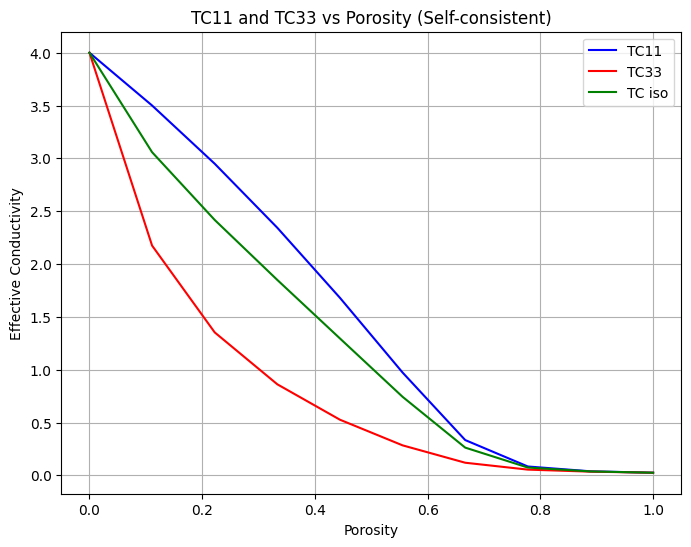

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# USER INPUT PARAMETERS (ADJUST THESE FOR DIFFERENT CASES)
N_COMPONENTS = 2  # Number of components (matrix + inclusions)
LAMBDA_VALUES = [4, 0.025]  # Thermal conductivity for each component
ALPHA_SHAPES = [
    [1.0, 1.0, 1.0],  # Aspect ratios for component 1 (matrix)
    [10, 10, 1],  # Aspect ratios for component 2 (fibers)
]

# Vary f1 from 0 to 1
porosity = np.linspace(0, 1, 10)
TC11_values = []
TC33_values = []
TC_iso_values = []

for por in porosity:
    CONCENTRATIONS = [1-por, por]  # Volume fractions (must sum to 1)
    # Calculate effective conductivity tensor
    tc_matrix = gsa_model('Self-consistent', CONCENTRATIONS, LAMBDA_VALUES, ALPHA_SHAPES, isotropic=False, f_paramtr=None)
    tc_iso = gsa_model('Self-consistent', CONCENTRATIONS, LAMBDA_VALUES, ALPHA_SHAPES, isotropic=True, f_paramtr=None)

    # Extract TC11 and TC33
    TC11_values.append(tc_matrix[0, 0])
    TC33_values.append(tc_matrix[2, 2])

    # Extract TC (for isotropic)
    TC_iso_values.append(tc_iso)

# Plot TC11 and TC33 as a function of f1
plt.figure(figsize=(8, 6))
plt.plot(porosity, TC11_values, label='TC11', color='blue')
plt.plot(porosity, TC33_values, label='TC33', color='red')
plt.plot(porosity, TC_iso_values, label='TC iso', color='green')
plt.xlabel('Porosity')
plt.ylabel('Effective Conductivity')
plt.title('TC11 and TC33 vs Porosity (Self-consistent)')
plt.legend()
plt.grid(True)
plt.show()

###GSA F-model: sensitivity analysis

[0.0, 1.0]
Converged after 0 iterations
Converged after 0 iterations
[0.1111111111111111, 0.8888888888888888]
Converged after 0 iterations
Converged after 0 iterations
[0.2222222222222222, 0.7777777777777778]
Converged after 0 iterations
Converged after 0 iterations
[0.3333333333333333, 0.6666666666666667]
Converged after 0 iterations
Converged after 0 iterations
[0.4444444444444444, 0.5555555555555556]
Converged after 0 iterations
Converged after 0 iterations
[0.5555555555555556, 0.4444444444444444]
Converged after 0 iterations
Converged after 0 iterations
[0.6666666666666666, 0.33333333333333337]
Converged after 0 iterations
Converged after 0 iterations
[0.7777777777777777, 0.22222222222222232]
Converged after 0 iterations
Converged after 0 iterations
[0.8888888888888888, 0.11111111111111116]
Converged after 0 iterations
Converged after 0 iterations
[1.0, 0.0]
Converged after 0 iterations
Converged after 0 iterations


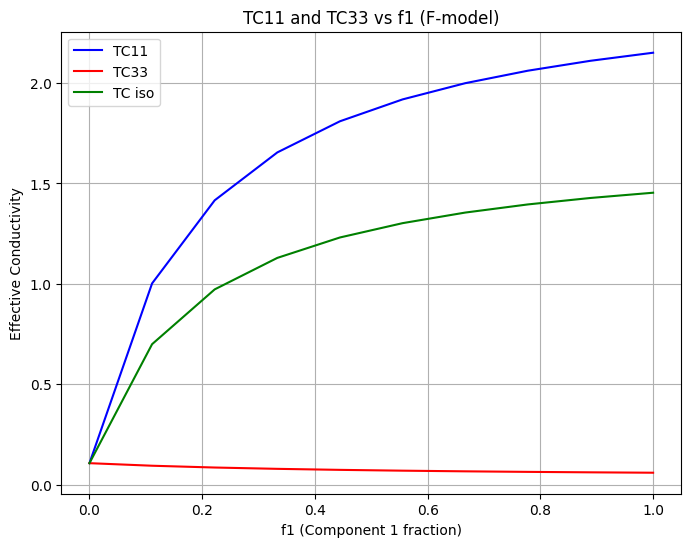

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# USER INPUT PARAMETERS (ADJUST THESE FOR DIFFERENT CASES)
N_COMPONENTS = 2  # Number of components (matrix + inclusions)
LAMBDA_VALUES = [4, 0.025]  # Thermal conductivity for each component
CONCENTRATIONS = [0.92, 0.8]  # Volume fractions (must sum to 1)
ALPHA_SHAPES = [
    [1.0, 1.0, 1.0],  # Aspect ratios for component 1 (matrix)
    [1000, 1000, 1],  # Aspect ratios for component 2 (fibers)
]

# Vary f1 from 0 to 1
f1_values = np.linspace(0, 1, 10)
TC11_values = []
TC33_values = []
TC_iso_values = []

for f1 in f1_values:

    f2 = (1 - f1)
    f_paramtr = [f1, f2]

    # Calculate effective conductivity tensor
    tc_matrix = gsa_model('F-model', CONCENTRATIONS, LAMBDA_VALUES, ALPHA_SHAPES, isotropic=False, f_paramtr=f_paramtr)
    tc_iso = gsa_model('F-model', CONCENTRATIONS, LAMBDA_VALUES, ALPHA_SHAPES, isotropic=True, f_paramtr=f_paramtr)

    # Extract TC11 and TC33
    TC11_values.append(tc_matrix[0, 0])
    TC33_values.append(tc_matrix[2, 2])

    # Extract TC (for isotropic)
    TC_iso_values.append(tc_iso)

# Plot TC11 and TC33 as a function of f1
plt.figure(figsize=(8, 6))
plt.plot(f1_values, TC11_values, label='TC11', color='blue')
plt.plot(f1_values, TC33_values, label='TC33', color='red')
plt.plot(f1_values, TC_iso_values, label='TC iso', color='green')
plt.xlabel('f1 (Component 1 fraction)')
plt.ylabel('Effective Conductivity')
plt.title('TC11 and TC33 vs f1 (F-model)')
plt.legend()
plt.grid(True)
plt.show()

# Функция для создания матрицы поворота

In [ ]:
def rotation_matrix(axis, angle):
    """
    Create a 3D rotation matrix for a given axis and angle.

    Parameters:
        axis (str): Axis of rotation ('x', 'y', or 'z').
        angle (float): Angle of rotation in radians.

    Returns:
        np.ndarray: 3x3 rotation matrix.
    """
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    if axis == 'x':
        return np.array([
            [1, 0, 0],
            [0, cos_a, -sin_a],
            [0, sin_a, cos_a]
        ])
    elif axis == 'y':
        return np.array([
            [cos_a, 0, sin_a],
            [0, 1, 0],
            [-sin_a, 0, cos_a]
        ])
    elif axis == 'z':
        return np.array([
            [cos_a, -sin_a, 0],
            [sin_a, cos_a, 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'.")

In [ ]:
### Преобразование тензора теплопроводности:

def rotate_tensor(kappa_local, axis, angle):
    """
    Rotate a tensor from local to global coordinates.

    Parameters:
        kappa_local (np.ndarray): Tensor in local coordinates (3x3 matrix).
        axis (str): Axis of rotation ('x', 'y', or 'z').
        angle (float): Angle of rotation in radians.

    Returns:
        np.ndarray: Rotated tensor in global coordinates (3x3 matrix).
    """
    R = rotation_matrix(axis, angle)
    return R @ kappa_local @ R.T

In [ ]:
lambda_tensors = [np.diagflat([lam] * 3) for lam in LAMBDA_VALUES]

In [ ]:
LAMBDA_VALUES

[4, 0.6, 0.025]

In [ ]:
print(lambda_tensors[0])

[[4 0 0]
 [0 4 0]
 [0 0 4]]


In [ ]:
# Угол поворота (45 градусов в радианах)
angle = np.radians(78)  # 45 градусов
axis = 'y'  # Поворот вокруг оси Z

# Преобразование тензоров теплопроводности включений
lambda_tensors_rotated = [
    lambda_tensors[0],  # Матрица не поворачивается
    rotate_tensor(lambda_tensors[1], axis, angle),  # Поворот первого включения
    rotate_tensor(lambda_tensors[2], axis, angle)  # Поворот второго включения
]

print(lambda_tensors_rotated)
print('.  ')
print(lambda_tensors)

# Расчет эффективной теплопроводности с учетом поворота
# Anisotropic calculation
print("Anisotropic effective conductivity with rotated inclusions:")

tc_matrix = gsa_model(
    'Self-consistent', CONCENTRATIONS, lambda_tensors_rotated, ALPHA_SHAPES, isotropic=False, f_paramtr=None
    )
print(np.round(tc_matrix, 8))


[array([[4, 0, 0],
       [0, 4, 0],
       [0, 0, 4]]), array([[ 6.00000000e-01,  0.00000000e+00, -1.28065893e-18],
       [ 0.00000000e+00,  6.00000000e-01,  0.00000000e+00],
       [-5.89722585e-18,  0.00000000e+00,  6.00000000e-01]]), array([[ 2.50000000e-02,  0.00000000e+00,  1.87085405e-19],
       [ 0.00000000e+00,  2.50000000e-02,  0.00000000e+00],
       [-2.45717744e-19,  0.00000000e+00,  2.50000000e-02]])]
.  
[array([[4, 0, 0],
       [0, 4, 0],
       [0, 0, 4]]), array([[0.6, 0. , 0. ],
       [0. , 0.6, 0. ],
       [0. , 0. , 0.6]]), array([[0.025, 0.   , 0.   ],
       [0.   , 0.025, 0.   ],
       [0.   , 0.   , 0.025]])]
Anisotropic effective conductivity with rotated inclusions:
Converged after 3 iterations
[[ 3.62406613  0.          0.        ]
 [ 0.          3.62406613 -0.        ]
 [-0.         -0.          3.52242701]]


In [ ]:
print("Anisotropic effective conductivity without rotated inclusions:")
tc_matrix = gsa_model(
    'Self-consistent', CONCENTRATIONS, LAMBDA_VALUES, ALPHA_SHAPES, isotropic=False, f_paramtr=None
    )
print(np.round(tc_matrix, 8))

Anisotropic effective conductivity without rotated inclusions:
[array([[4.e+00, 1.e-20, 1.e-20],
       [1.e-20, 4.e+00, 1.e-20],
       [1.e-20, 1.e-20, 4.e+00]]), array([[6.e-01, 1.e-20, 1.e-20],
       [1.e-20, 6.e-01, 1.e-20],
       [1.e-20, 1.e-20, 6.e-01]]), array([[2.5e-02, 1.0e-20, 1.0e-20],
       [1.0e-20, 2.5e-02, 1.0e-20],
       [1.0e-20, 1.0e-20, 2.5e-02]])]
Converged after 3 iterations
[[ 3.62406613  0.          0.        ]
 [ 0.          3.62406613 -0.        ]
 [ 0.         -0.          3.52242701]]


### GSA Isotropic case (simplified)

In [ ]:
import numpy as np

def depolarization_factor(alpha):
    """
    Calculate the depolarization factor based on the shape factor alpha.
    """
    if alpha < 1:
        t1 = alpha ** 2
        t2 = 1 / t1
        t4 = np.sqrt(t2 - 1)
        t5 = np.arctan(t4)
        t8 = t4 ** 2
        form = t2 * (t4 - t5) / t8 / t4
    elif alpha > 1:
        t1 = alpha ** 2
        t2 = 1 / t1
        t4 = np.sqrt(1 - t2)
        t6 = np.log(1 + t4)
        t9 = np.log(1 - t4)
        t13 = t4 ** 2
        form = t2 * (t6 / 2 - t9 / 2 - t4) / t13 / t4
    elif alpha == 1:
        form = 1 / 3
    return form

def calculate_effective_tc(phi, alpha_shape, lam):
    """
    Calculate the effective thermal conductivity using an iterative approach.
    """
    depolar_F = [depolarization_factor(alpha) for alpha in alpha_shape]
    L0 = lam[0]

    def raschet(L0):
        parall_comp, perpen_comp = [], []

        for i, j, f in zip(phi, lam, depolar_F):
            termc_3 = i * j / (L0 * (1 - f) + j * f)
            termz_3 = i / (L0 * (1 - f) + j * f)

            termc_12 = i * j / (L0 * (1 + f) / 2 + j * (1 - f) / 2)
            termz_12 = i / (L0 * (1 + f) / 2 + j * (1 - f) / 2)

            termc_all = (termc_3 + 2 * termc_12) / 3
            termz_all = (termz_3 + 2 * termz_12) / 3

            parall_comp.append(termc_all)  # numerator
            perpen_comp.append(termz_all)  # denominator

        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
        return L_eff

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0 - L0) >= 1e-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

    return L0

# Example usage:
# conc = [1, 2, 3]
# alpha_shape = [0.5, 1.5, 1]
# lam = [0.1, 0.2, 0.3]
# result = calculate_effective_tc(conc, alpha_shape, lam)
# print("Effective TC:", result)

In [ ]:
N_COMPONENTS = 3  # Number of components (matrix + inclusions)
LAMBDA_VALUES = [4, 0.025, 0.025]  # Thermal conductivity for each component
CONCENTRATIONS = [0.92, 0.075, 0.005]  # Volume fractions (must sum to 1)
ALPHA_SHAPES = [
    [1.0, 1.0, 1.0],    # Aspect ratios for component 1 (matrix)
    [10, 10, 1],    # Aspect ratios for component 2 (fibers)
    [1000, 1000, 1]     # Aspect ratios for component 3 (spheres)
]

phi = CONCENTRATIONS
alpha_shape = [1, 0.1, 0.001]
lam = LAMBDA_VALUES
calculate_effective_tc(phi, alpha_shape, lam)

2.7098053702868397

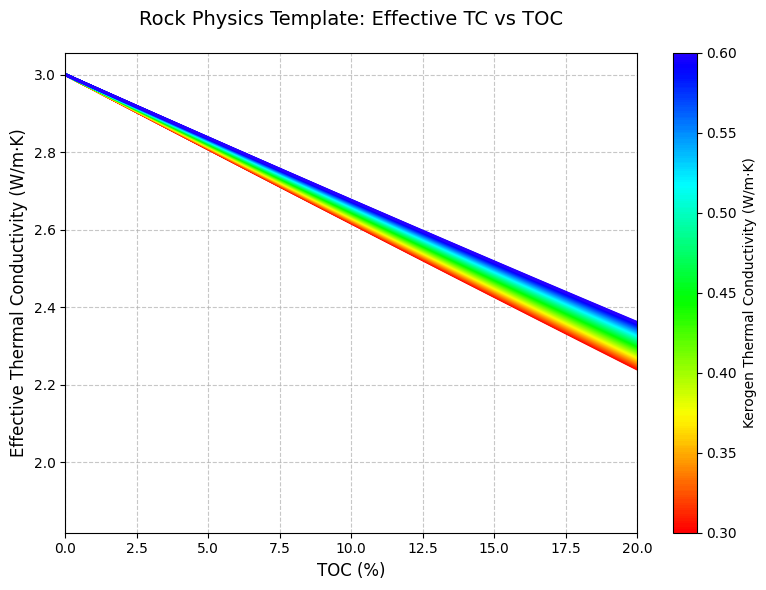

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb, LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable

def depolarization_factor(alpha):
    """
    Calculate the depolarization factor based on the shape factor alpha.
    """
    if alpha < 1:
        t1 = alpha ** 2
        t2 = 1 / t1
        t4 = np.sqrt(t2 - 1)
        t5 = np.arctan(t4)
        t8 = t4 ** 2
        form = t2 * (t4 - t5) / t8 / t4
    elif alpha > 1:
        t1 = alpha ** 2
        t2 = 1 / t1
        t4 = np.sqrt(1 - t2)
        t6 = np.log(1 + t4)
        t9 = np.log(1 - t4)
        t13 = t4 ** 2
        form = t2 * (t6 / 2 - t9 / 2 - t4) / t13 / t4
    elif alpha == 1:
        form = 1 / 3
    return form

def calculate_effective_tc(phi, alpha_shape, lam):
    """
    Calculate the effective thermal conductivity using an iterative approach.
    """
    depolar_F = [depolarization_factor(alpha) for alpha in alpha_shape]
    L0 = lam[0]

    def raschet(L0):
        parall_comp, perpen_comp = [], []

        for i, j, f in zip(phi, lam, depolar_F):
            termc_3 = i * j / (L0 * (1 - f) + j * f)
            termz_3 = i / (L0 * (1 - f) + j * f)

            termc_12 = i * j / (L0 * (1 + f) / 2 + j * (1 - f) / 2)
            termz_12 = i / (L0 * (1 + f) / 2 + j * (1 - f) / 2)

            termc_all = (termc_3 + 2 * termc_12) / 3
            termz_all = (termz_3 + 2 * termz_12) / 3

            parall_comp.append(termc_all)  # numerator
            perpen_comp.append(termz_all)  # denominator

        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
        return L_eff

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0 - L0) >= 1e-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

    return L0

def generate_rock_physics_template(matrix_tc, toc_range, kerogen_tc_range, alpha_matrix=1.0, alpha_kerogen=1.0):
    """
    Generate a rock physics template for varying TOC and kerogen TC.

    Parameters:
    - matrix_tc: Thermal conductivity of the matrix (constant).
    - toc_range: Array of TOC values (kerogen volume fraction, 0 to 0.2).
    - kerogen_tc_range: Array of kerogen thermal conductivity values (0.13 to 0.6).
    - alpha_matrix: Shape factor for the matrix (default: 1.0, spherical).
    - alpha_kerogen: Shape factor for kerogen (default: 1.0, spherical).

    Returns:
    - A 2D array of effective thermal conductivities.
    """
    results = np.zeros((len(toc_range), len(kerogen_tc_range)))

    for i, toc in enumerate(toc_range):
        phi = [1 - toc, toc]
        alpha_shape = [alpha_matrix, alpha_kerogen]
        for j, k_tc in enumerate(kerogen_tc_range):
            lam = [matrix_tc, k_tc]
            results[i, j] = calculate_effective_tc(phi, alpha_shape, lam)

    return results


if __name__ == "__main__":
    matrix_tc = 3.0  # Matrix thermal conductivity (W/m·K)
    tocs = np.linspace(0, 0.3, 21)  # TOC from 0% to 20%
    kerogen_tcs = np.linspace(0.3, 0.6, 100)  # Kerogen TC range

    template = generate_rock_physics_template(matrix_tc, tocs, kerogen_tcs)

    # Create HSV-based color map
    min_k, max_k = np.min(kerogen_tcs), np.max(kerogen_tcs)
    norm = Normalize(vmin=min_k, vmax=max_k)

    # Truncate HSV colormap to avoid hue wrap-around
    cmap = plt.get_cmap('hsv')(np.linspace(0, 0.7, 256))
    cmap = LinearSegmentedColormap.from_list('truncated_hsv', cmap, N=256)

    # Explicitly create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each kerogen TC curve
    for j in range(len(kerogen_tcs)):
        h = (kerogen_tcs[j] - min_k)/(max_k - min_k) # Scale hue from 0-0.7
        color = cmap(h)
        ax.plot(tocs*100, template[:, j], color=color, lw=2)

    # Add colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label='Kerogen Thermal Conductivity (W/m·K)')

    # Set labels and title
    ax.set_xlabel('TOC (%)', fontsize=12)
    ax.set_ylabel('Effective Thermal Conductivity (W/m·K)', fontsize=12)
    ax.set_title('Rock Physics Template: Effective TC vs TOC', fontsize=14, pad=20)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim(0, 20)

    plt.tight_layout()
    plt.show()

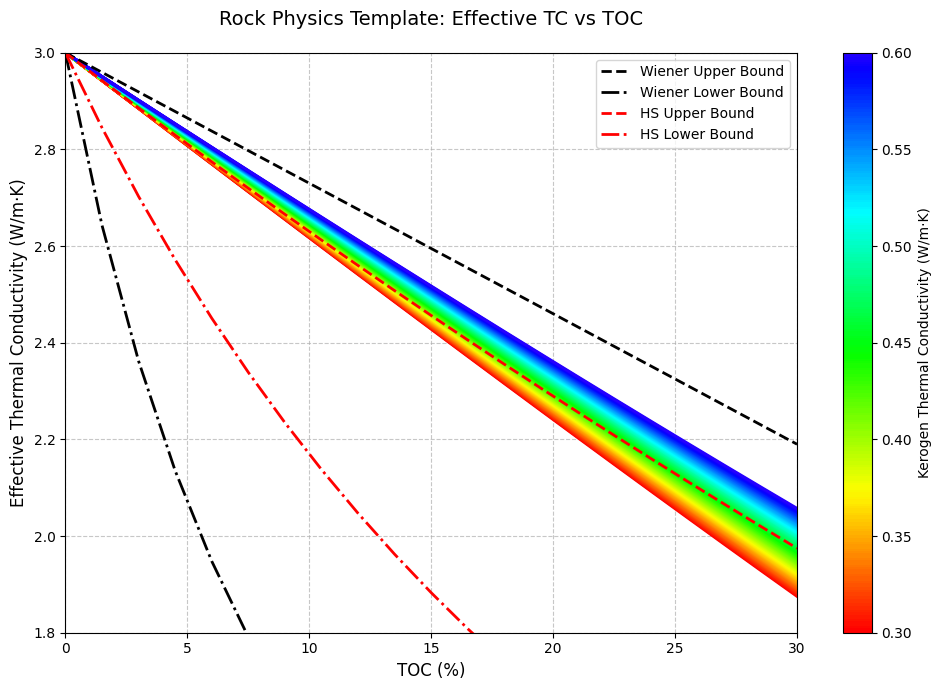

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb, LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable

# Define the depolarization factor and effective TC functions (from your original code)
def depolarization_factor(alpha):
    """
    Calculate the depolarization factor based on the shape factor alpha.
    """
    if alpha < 1:
        t1 = alpha ** 2
        t2 = 1 / t1
        t4 = np.sqrt(t2 - 1)
        t5 = np.arctan(t4)
        t8 = t4 ** 2
        form = t2 * (t4 - t5) / t8 / t4
    elif alpha > 1:
        t1 = alpha ** 2
        t2 = 1 / t1
        t4 = np.sqrt(1 - t2)
        t6 = np.log(1 + t4)
        t9 = np.log(1 - t4)
        t13 = t4 ** 2
        form = t2 * (t6 / 2 - t9 / 2 - t4) / t13 / t4
    elif alpha == 1:
        form = 1 / 3
    return form

def calculate_effective_tc(phi, alpha_shape, lam):
    """
    Calculate the effective thermal conductivity using an iterative approach.
    """
    depolar_F = [depolarization_factor(alpha) for alpha in alpha_shape]
    L0 = lam[0]

    def raschet(L0):
        parall_comp, perpen_comp = [], []

        for i, j, f in zip(phi, lam, depolar_F):
            termc_3 = i * j / (L0 * (1 - f) + j * f)
            termz_3 = i / (L0 * (1 - f) + j * f)

            termc_12 = i * j / (L0 * (1 + f) / 2 + j * (1 - f) / 2)
            termz_12 = i / (L0 * (1 + f) / 2 + j * (1 - f) / 2)

            termc_all = (termc_3 + 2 * termc_12) / 3
            termz_all = (termz_3 + 2 * termz_12) / 3

            parall_comp.append(termc_all)  # numerator
            perpen_comp.append(termz_all)  # denominator

        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
        return L_eff

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0 - L0) >= 1e-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

    return L0


# Generate the rock physics template
def generate_rock_physics_template(matrix_tc, toc_range, kerogen_tc_range, alpha_matrix=1.0, alpha_kerogen=1.0):
    """
    Generate a rock physics template for varying TOC and kerogen TC.
    """
    results = np.zeros((len(toc_range), len(kerogen_tc_range)))

    for i, toc in enumerate(toc_range):
        phi = [1 - toc, toc]
        alpha_shape = [alpha_matrix, alpha_kerogen]
        for j, k_tc in enumerate(kerogen_tc_range):
            lam = [matrix_tc, k_tc]
            results[i, j] = calculate_effective_tc(phi, alpha_shape, lam)

    return results

# Main script
if __name__ == "__main__":
    # Input parameters
    matrix_tc = 3.0  # Matrix thermal conductivity (W/m·K)
    alpha_matrix = 1.0
    tocs = np.linspace(0, 0.3, 21)  # TOC from 0% to 30%
    kerogen_tcs = np.linspace(0.3, 0.6, 100)  # Kerogen TC range
    alpha_kerogen = 0.8


    # Generate the rock physics template
    template = generate_rock_physics_template(matrix_tc, tocs, kerogen_tcs)

    # Calculate Wiener and HS bounds
    results = {
        "Wiener_Upper": [],
        "Wiener_Lower": [],
        "HS_Upper": [],
        "HS_Lower": []
    }

    for toc in tocs:
        phi = np.array([1 - toc, toc])
        lam = np.array([matrix_tc, kerogen_tcs[0]])  # Use the first kerogen TC for bounds
        results["Wiener_Upper"].append(Wiener_Upper_Bound(phi, lam))
        results["Wiener_Lower"].append(Wiener_Lower_Bound(phi, lam))
        results["HS_Upper"].append(Upper_Hashin_Strikman(phi, lam))
        results["HS_Lower"].append(Lower_Hashin_Strikman(phi, lam))


    # Plotting
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot the rock physics template
    min_k, max_k = np.min(kerogen_tcs), np.max(kerogen_tcs)
    norm = Normalize(vmin=min_k, vmax=max_k)
    cmap = plt.get_cmap('hsv')(np.linspace(0, 0.7, 256))
    cmap = LinearSegmentedColormap.from_list('truncated_hsv', cmap, N=256)

    for j in range(len(kerogen_tcs)):
        h = (kerogen_tcs[j] - min_k) / (max_k - min_k)
        color = cmap(h)
        ax.plot(tocs * 100, template[:, j], color=color, lw=2)

    # Plot the bounds
    ax.plot(tocs * 100, results["Wiener_Upper"], 'k--', label="Wiener Upper Bound", lw=2)
    ax.plot(tocs * 100, results["Wiener_Lower"], 'k-.', label="Wiener Lower Bound", lw=2)
    ax.plot(tocs * 100, results["HS_Upper"], 'r--', label="HS Upper Bound", lw=2)
    ax.plot(tocs * 100, results["HS_Lower"], 'r-.', label="HS Lower Bound", lw=2)

    # Add colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label='Kerogen Thermal Conductivity (W/m·K)')

    # Add labels, title, and legend
    ax.set_xlabel('TOC (%)', fontsize=12)
    ax.set_ylabel('Effective Thermal Conductivity (W/m·K)', fontsize=12)
    ax.set_title('Rock Physics Template: Effective TC vs TOC', fontsize=14, pad=20)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim(0, 30)
    ax.set_ylim(1.8, 3)
    ax.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

## 923

### Step 1

### Step 1: Material 1 (silica) = Qz + опал + халцедон (isotropic)


In [ ]:
# Step 1
initial_volume = 40.5 # Total SiO₂ volume fraction in the rock (%)
# Normalize the SiO₂ components to 100% within the initial_volume
volume_fractions_sio2 = np.array([1/3, 1/3, 1/3])  # Equal distribution for quartz, opal, chalcedony
thermal_conductivities_sio2 = np.array([7.6, 2.4, 3.2])  # Quartz, Opal, Chalcedony

# Calculate the effective thermal conductivity of the SiO₂ components
effective_tc_sio2 = calculate_effective_tc(volume_fractions_sio2, alpha_shape, thermal_conductivities_sio2)

alpha_shape = [1, 1, 1]
effective_EMT_tc_sio2 = Likhteneker(volume_fractions_sio2, thermal_conductivities_sio2)

print(f"Effective thermal conductivity of SiO₂ components by Likhteneker: {effective_tc_sio2:.2f} W/m·K")
print(f"Effective thermal conductivity of SiO₂ components by EMT: {effective_EMT_tc_sio2:.2f} W/m·K")


material1 = effective_EMT_tc_sio2

Effective thermal conductivity of SiO₂ components by Likhteneker: 4.02 W/m·K
Effective thermal conductivity of SiO₂ components by EMT: 3.88 W/m·K


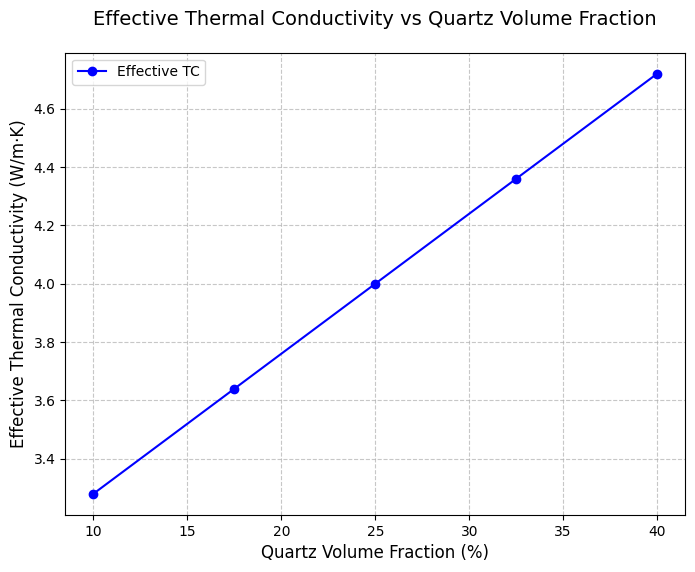

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Input parameters
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
thermal_conductivities_sio2 = np.array([7.6, 2.4, 3.2])  # Quartz, Opal, Chalcedony

# Define the range for quartz volume fraction (10% to 40%)
quartz_fractions = np.linspace(0.1, 0.4, 5)  # 10 steps from 10% to 40%

alpha_shape_sio2 = [1, 1, 1]

# Calculate effective thermal conductivity for each quartz fraction
effective_tc_sio2_results = []

for quartz_fraction in quartz_fractions:
    # Adjust the volume fractions for opal and chalcedony
    remaining_fraction = 1 - quartz_fraction
    volume_fractions_sio2 = np.array([quartz_fraction, remaining_fraction / 2, remaining_fraction / 2])


    # Calculate the effective thermal conductivity
    effective_tc_sio2 = calculate_effective_tc(volume_fractions_sio2, alpha_shape, thermal_conductivities_sio2)
    effective_tc_sio2_results.append(effective_tc_sio2)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(quartz_fractions * 100, effective_tc_sio2_results, marker='o', linestyle='-', color='b', label='Effective TC')
plt.xlabel("Quartz Volume Fraction (%)", fontsize=12)
plt.ylabel("Effective Thermal Conductivity (W/m·K)", fontsize=12)
plt.title("Effective Thermal Conductivity vs Quartz Volume Fraction", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)
plt.show()

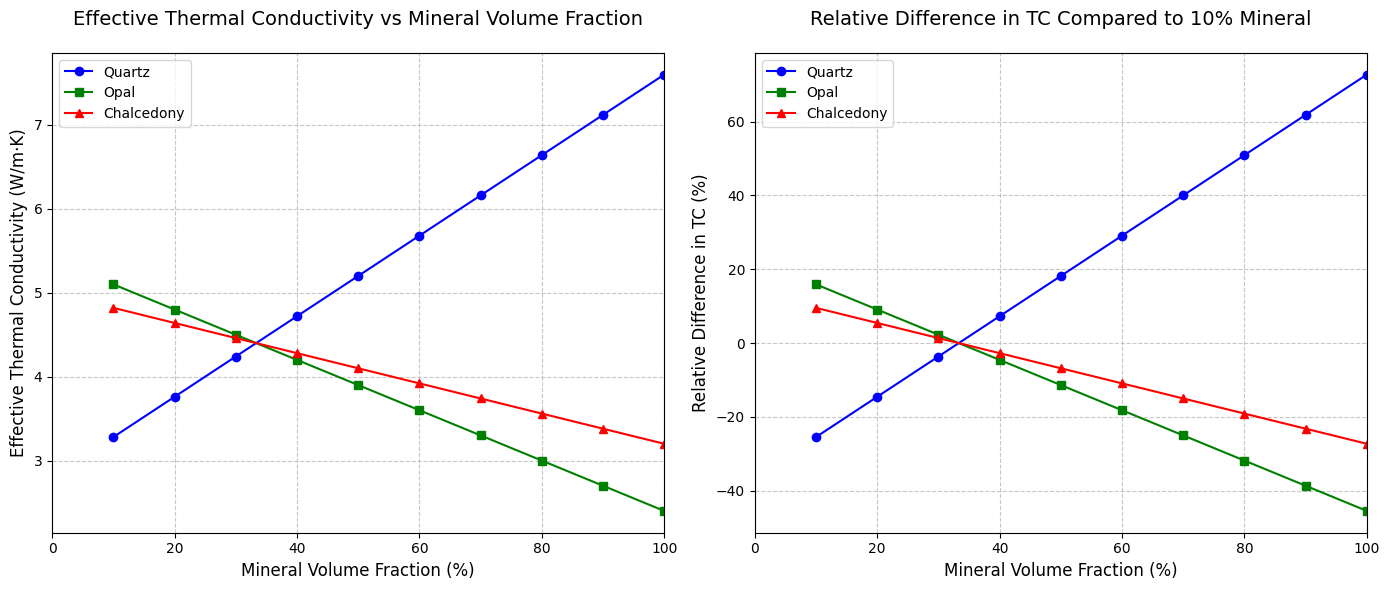

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate effective thermal conductivity
def calculate_effective_tc(volume_fractions, alpha_shape, thermal_conductivities):
    numerator = np.sum(volume_fractions * alpha_shape * thermal_conductivities)
    denominator = np.sum(volume_fractions * alpha_shape)
    effective_tc = numerator / denominator
    return effective_tc

# Input parameters
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
thermal_conductivities_sio2 = np.array([7.6, 2.4, 3.2])  # Quartz, Opal, Chalcedony

# Define the range for quartz, opal, and chalcedony volume fractions (10% to 40%)
mineral_fractions = np.linspace(0.1, 1, 10)  # 10 steps from 10% to 40%

alpha_shape_sio2 = [1, 1, 1]  # Shape factors for Quartz, Opal, Chalcedony

# Calculate effective thermal conductivity for each mineral fraction
effective_tc_quartz_results = []
effective_tc_opal_results = []
effective_tc_chalcedony_results = []

for mineral_fraction in mineral_fractions:
    # Quartz case
    remaining_fraction_quartz = 1 - mineral_fraction
    volume_fractions_quartz = np.array([mineral_fraction, remaining_fraction_quartz / 2, remaining_fraction_quartz / 2])
    effective_tc_quartz = calculate_effective_tc(volume_fractions_quartz, alpha_shape_sio2, thermal_conductivities_sio2)
    effective_tc_quartz_results.append(effective_tc_quartz)

    # Opal case
    remaining_fraction_opal = 1 - mineral_fraction
    volume_fractions_opal = np.array([remaining_fraction_opal / 2, mineral_fraction, remaining_fraction_opal / 2])
    effective_tc_opal = calculate_effective_tc(volume_fractions_opal, alpha_shape_sio2, thermal_conductivities_sio2)
    effective_tc_opal_results.append(effective_tc_opal)

    # Chalcedony case
    remaining_fraction_chalcedony = 1 - mineral_fraction
    volume_fractions_chalcedony = np.array([remaining_fraction_chalcedony / 2, remaining_fraction_chalcedony / 2, mineral_fraction])
    effective_tc_chalcedony = calculate_effective_tc(volume_fractions_chalcedony, alpha_shape_sio2, thermal_conductivities_sio2)
    effective_tc_chalcedony_results.append(effective_tc_chalcedony)

# Calculate the TC for the baseline case (10% mineral)
baseline_mineral_fraction = 0.1
# remaining_fraction_baseline = 1 - baseline_mineral_fraction
baseline_volume_fractions = np.array([baseline_mineral_fraction/3, baseline_mineral_fraction/3, baseline_mineral_fraction/3])
baseline_tc = calculate_effective_tc(baseline_volume_fractions, alpha_shape_sio2, thermal_conductivities_sio2)

# Calculate the relative difference for each mineral fraction
relative_differences_quartz = []
relative_differences_opal = []
relative_differences_chalcedony = []

for tc_quartz, tc_opal, tc_chalcedony in zip(effective_tc_quartz_results, effective_tc_opal_results, effective_tc_chalcedony_results):
    relative_diff_quartz = ((tc_quartz - baseline_tc) / baseline_tc) * 100  # Relative difference in %
    relative_diff_opal = ((tc_opal - baseline_tc) / baseline_tc) * 100
    relative_diff_chalcedony = ((tc_chalcedony - baseline_tc) / baseline_tc) * 100
    relative_differences_quartz.append(relative_diff_quartz)
    relative_differences_opal.append(relative_diff_opal)
    relative_differences_chalcedony.append(relative_diff_chalcedony)

# Plot the results
plt.figure(figsize=(14, 6))

# Plot 1: Effective Thermal Conductivity vs Mineral Volume Fraction
plt.subplot(1, 2, 1)
plt.plot(mineral_fractions * 100, effective_tc_quartz_results, marker='o', linestyle='-', color='b', label='Quartz')
plt.plot(mineral_fractions * 100, effective_tc_opal_results, marker='s', linestyle='-', color='g', label='Opal')
plt.plot(mineral_fractions * 100, effective_tc_chalcedony_results, marker='^', linestyle='-', color='r', label='Chalcedony')
plt.xlabel("Mineral Volume Fraction (%)", fontsize=12)
plt.ylabel("Effective Thermal Conductivity (W/m·K)", fontsize=12)
plt.title("Effective Thermal Conductivity vs Mineral Volume Fraction", fontsize=14, pad=20)
plt.xlim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)

# Plot 2: Relative Difference in TC Compared to 10% Mineral
plt.subplot(1, 2, 2)
plt.plot(mineral_fractions * 100, relative_differences_quartz, marker='o', linestyle='-', color='b', label='Quartz')
plt.plot(mineral_fractions * 100, relative_differences_opal, marker='s', linestyle='-', color='g', label='Opal')
plt.plot(mineral_fractions * 100, relative_differences_chalcedony, marker='^', linestyle='-', color='r', label='Chalcedony')
plt.xlabel("Mineral Volume Fraction (%)", fontsize=12)
plt.ylabel("Relative Difference in TC (%)", fontsize=12)
plt.title("Relative Difference in TC Compared to 10% Mineral", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 100)
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

### Step 2: Material 2 = Material 1 + oriented clay (illite)

In [ ]:
# Step 2

# Input parameters
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
initial_volume_illite = 18.1  # Total Illite volume fraction in the rock (%)

# Calculate the total volume
total_volume = initial_volume_sio2 + initial_volume_illite

# Normalize the volumes so their sum is 100%
normalized_sio2 = (initial_volume_sio2 / total_volume)
normalized_illite = (initial_volume_illite / total_volume)

# Print results
print(f"Normalized SiO₂ volume: {normalized_sio2:.2f}%")
print(f"Normalized Illite volume: {normalized_illite:.2f}%")
print(f"Sum of normalized volumes: {normalized_sio2 + normalized_illite:.2f}%")

thermal_conductivities_illite = 2.69  # Illite

# USER INPUT PARAMETERS (ADJUST THESE FOR DIFFERENT CASES)
N_COMPONENTS = 2  # Number of components (matrix + inclusions)
# LAMBDA_VALUES = [material1, thermal_conductivities_illite ]  # Thermal conductivity for each component
# CONCENTRATIONS = [normalized_sio2, normalized_illite ]  # Volume fractions (must sum to 1)

LAMBDA_VALUES = [3, 0.025]  # Thermal conductivity for each component
CONCENTRATIONS = [1-0.0015, 0.0015]  # Volume fractions (must sum to 1)
print(LAMBDA_VALUES )

ALPHA_SHAPES = [
    [1.0, 1.0, 1.0],    # Aspect ratios for component 1 (silica)
    [1000.0, 1000.0, 1.0],    # Aspect ratios for component 2 (clay)
]

# Prepare initial parameters
lambda_tensors = [np.diagflat([lam]*3) for lam in LAMBDA_VALUES]
X0 = sum(c*lam for c, lam in zip(CONCENTRATIONS, lambda_tensors))
X0 = lambda_tensors[0]

# Anisotropic calculation
print("Anisotropic effective conductivity:")
tc_matrix = effective_conductivity(X0, CONCENTRATIONS, lambda_tensors, ALPHA_SHAPES)
print(np.round(tc_matrix, 6))

# Isotropic calculation
print("\nIsotropic effective conductivity:")
tc_iso = effective_conductivity(X0, CONCENTRATIONS, lambda_tensors, ALPHA_SHAPES, isotropic=True)
print(np.round(tc_iso, 6))

# Hashin-Shtrikman bounds
hs_upper_ = Upper_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES)
hs_lower = Lower_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES)
hs_avg = Hashin_Strikman_Average(CONCENTRATIONS, LAMBDA_VALUES)



Normalized SiO₂ volume: 0.69%
Normalized Illite volume: 0.31%
Sum of normalized volumes: 1.00%
[3, 0.025]
Anisotropic effective conductivity:


/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


[[ 2.995532  0.       -0.      ]
 [-0.        2.995532  0.      ]
 [ 0.        0.        2.633174]]

Isotropic effective conductivity:
2.874746


Оценка влияния анизотропии глин (неизвесный параметр на эффективную теплопроводность глинистого композита - иллит + каолинит)

In [ ]:
# # USER INPUT PARAMETERS (ADJUST THESE FOR DIFFERENT CASES)
N_COMPONENTS = 3  # Number of components (matrix + inclusions)
LAMBDA_VALUES = [4, 0.6, 0.025]  # Thermal conductivity for each component
CONCENTRATIONS = [0.92, 0.075, 0.005]  # Volume fractions (must sum to 1)
ALPHA_SHAPES = [
    [1.0, 1.0, 1.0],  # Aspect ratios for component 1 (matrix)
    [1.0, 1.0, 1.0],  # Aspect ratios for component 2 (fibers)
    [10, 10, 1]   # Aspect ratios for component 3 (spheres)
]


phi = CONCENTRATIONS
alpha_shape = [1, 1, 0.1]
lam = [4, 0.6, 0.025]
reults = calculate_effective_tc(phi, alpha_shape, lam)
result

np.float64(3.6258521427674033)

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


iteration 1
[[ 2.58961115e+00 -1.82544585e-24 -3.39100688e-23]
 [ 3.70728391e-23  2.58961115e+00 -3.92339475e-24]
 [-2.04474996e-23 -1.84860491e-23  2.55501293e+00]]
iteration 1
[[ 2.58961090e+00 -4.98167554e-23 -1.18243634e-23]
 [-5.22910381e-23  2.58961090e+00 -1.41659566e-23]
 [-1.33222835e-23 -1.02572329e-23  2.04401100e+00]]
iteration 1
[[2.58961067e+00 1.19331897e-23 6.30260384e-24]
 [1.97625143e-23 2.58961067e+00 2.27497990e-24]
 [9.91108922e-24 7.52050912e-25 1.70334300e+00]]
iteration 1
[[ 2.58961046e+00  3.05550056e-23  1.46456148e-23]
 [ 2.45617222e-23  2.58961047e+00  2.67364182e-24]
 [ 5.44284478e-23 -6.78649726e-26  1.46000868e+00]]
iteration 1
[[ 2.58961027e+00 -9.23066994e-23  1.05188172e-23]
 [-1.19524291e-22  2.58961027e+00 -7.40510683e-24]
 [-3.29255207e-23 -2.52005448e-23  1.27750791e+00]]


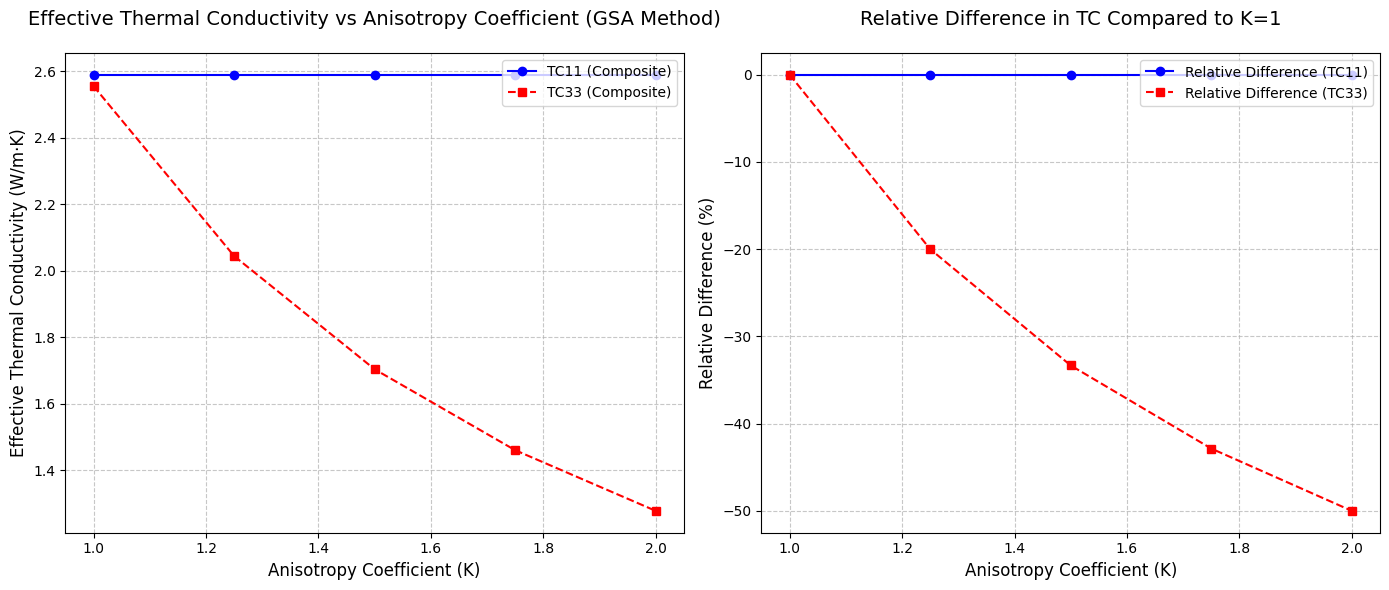

In [ ]:
# Input parameters
initial_volume_illite = 15.8  # Illite volume fraction (%)
initial_volume_kaolinite = 2.3  # Kaolinite volume fraction (%)

# Thermal conductivities (TC11 components)
tc11_illite = 2.69  # TC11 for illite
tc11_kaolinite = 1.90  # TC11 for kaolinite

# Define the range for anisotropy coefficient K
K_values = np.linspace(1, 2, 5)  # K varies from 1 to 2

# Lists to store tc_11 and tc_33 values for the composite material
tc11_composite_values = []
tc33_composite_values = []

# Loop over each K value
for K in K_values:
    # Calculate TC33 for illite and kaolinite
    tc33_illite = tc11_illite / K
    tc33_kaolinite = tc11_kaolinite / K

    # Create thermal conductivity tensors for illite and kaolinite
    lambda_illite = np.diag([tc11_illite, tc11_illite, tc33_illite])
    lambda_kaolinite = np.diag([tc11_kaolinite, tc11_kaolinite, tc33_kaolinite])

    # Volume fractions (normalized to sum to 1)
    total_volume = initial_volume_illite + initial_volume_kaolinite
    normalized_illite = initial_volume_illite / total_volume
    normalized_kaolinite = initial_volume_kaolinite / total_volume
    # Aspect ratios (alpha_shapes)
    # Assume illite and kaolinite are anisotropic (flattened ellipsoids)
    alpha_shapes = [
        [1000.0, 1000.0, 1],  # Illite (anisotropic)
        [1000.0, 1000.0, 1],  # Kaolinite (anisotropic)
    ]

    # Random orientation flags
    random_orientation_flags = [False, False]  # Both components are oriented

    # Calculate effective thermal conductivity using the GSA method
    effective_tensor = effective_conductivity(
        lambda_illite,  # Initial comparison tensor
        [normalized_illite, normalized_kaolinite],
        [lambda_illite, lambda_kaolinite],
        alpha_shapes
    )

    print(effective_tensor)

    # Extract TC11 and TC33 from the effective tensor
    tc11_composite = effective_tensor[0, 0]
    tc33_composite = effective_tensor[2, 2]

    # Store the results
    tc11_composite_values.append(tc11_composite)
    tc33_composite_values.append(tc33_composite)

# Calculate relative differences compared to K=1
tc11_reference = tc11_composite_values[0]  # TC11 at K=1
tc33_reference = tc33_composite_values[0]  # TC33 at K=1

relative_diff_tc11 = [(tc - tc11_reference) / tc11_reference * 100 for tc in tc11_composite_values]
relative_diff_tc33 = [(tc - tc33_reference) / tc33_reference * 100 for tc in tc33_composite_values]

# Plot the results
plt.figure(figsize=(14, 6))

# Plot 1: Effective Thermal Conductivity vs Anisotropy Coefficient
plt.subplot(1, 2, 1)
plt.plot(K_values, tc11_composite_values, marker='o', linestyle='-', color='b', label='TC11 (Composite)')
plt.plot(K_values, tc33_composite_values, marker='s', linestyle='--', color='r', label='TC33 (Composite)')
plt.xlabel("Anisotropy Coefficient (K)", fontsize=12)
plt.ylabel("Effective Thermal Conductivity (W/m·K)", fontsize=12)
plt.title("Effective Thermal Conductivity vs Anisotropy Coefficient (GSA Method)", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=10)

# Plot 2: Relative Difference in TC Compared to K=1
plt.subplot(1, 2, 2)
plt.plot(K_values, relative_diff_tc11, marker='o', linestyle='-', color='b', label='Relative Difference (TC11)')
plt.plot(K_values, relative_diff_tc33, marker='s', linestyle='--', color='r', label='Relative Difference (TC33)')
plt.xlabel("Anisotropy Coefficient (K)", fontsize=12)
plt.ylabel("Relative Difference (%)", fontsize=12)
plt.title("Relative Difference in TC Compared to K=1", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

SiO2 3.2800000000000002


/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


iteration 1
Clay [[ 2.58959215e+00  4.03667952e-22 -1.17308056e-22]
 [-2.76936417e-22  2.58959215e+00  1.86885930e-22]
 [ 3.10570356e-22  1.40871560e-22  2.55507572e+00]]
iteration 3
M3 [[ 3.06327373e+00  5.63151975e-20  2.76652190e-21]
 [ 7.90507332e-20  3.06327373e+00 -7.80881975e-21]
 [ 5.86402071e-21  2.96346738e-22  3.02467624e+00]]
iteration 1
Clay [[ 2.58959160e+00 -4.03291059e-22 -3.31474111e-23]
 [-6.43359216e-23  2.58959160e+00  1.21689924e-22]
 [ 3.45491945e-22  1.30070618e-22  2.42732365e+00]]
iteration 3
M3 [[ 3.06326117e+00  7.79520613e-20  7.90681632e-22]
 [ 3.34492748e-20  3.06326117e+00 -1.82775538e-20]
 [ 3.23111008e-21 -6.90803422e-21  2.97193535e+00]]
iteration 1
Clay [[2.58959106e+00 5.36541644e-23 6.95606455e-23]
 [1.73116711e-22 2.58959106e+00 1.97478200e-22]
 [6.08344158e-22 2.50273287e-22 2.31173841e+00]]
iteration 4
M3 [[ 3.06324903e+00  1.42906061e-19 -3.22452493e-20]
 [ 9.09453308e-20  3.06324903e+00 -1.88325688e-20]
 [-1.03289721e-20  1.70541040e-21  2.9217

KeyboardInterrupt: 

Sillica 3.2800000000000002
Sillica 3.4400000000000004
Sillica 3.6
Sillica 3.7600000000000002
Sillica 3.92
Sillica 4.08
Sillica 4.24
Sillica 4.4
Sillica 4.56
Sillica 4.72
iteration 1
Clay [[ 2.58959215e+00  4.03667952e-22 -1.17308056e-22]
 [-2.76936417e-22  2.58959215e+00  1.86885930e-22]
 [ 3.10570356e-22  1.40871560e-22  2.55507572e+00]]
iteration 1
Clay [[ 2.58959100e+00 -1.62071458e-22  3.46553720e-22]
 [ 1.54367040e-22  2.58959100e+00  2.34176907e-22]
 [ 8.16333349e-22  2.70736124e-22  2.29957154e+00]]
iteration 1
Clay [[ 2.58958992e+00 -3.14379682e-23  5.56971643e-23]
 [-3.84179370e-22  2.58958992e+00  5.22711659e-23]
 [ 5.72106752e-22  1.90416664e-22  2.09052251e+00]]
iteration 1
Clay [[ 2.58958888e+00  2.99563182e-23 -2.00973054e-23]
 [-1.40181377e-22  2.58958888e+00  2.50477063e-22]
 [ 2.86266294e-22  2.26601353e-22  1.91631487e+00]]
iteration 1
Clay [[2.58958789e+00 1.04599549e-22 4.27137502e-23]
 [2.48953805e-22 2.58958789e+00 1.75002336e-22]
 [5.00087459e-22 3.59507436e-22 1

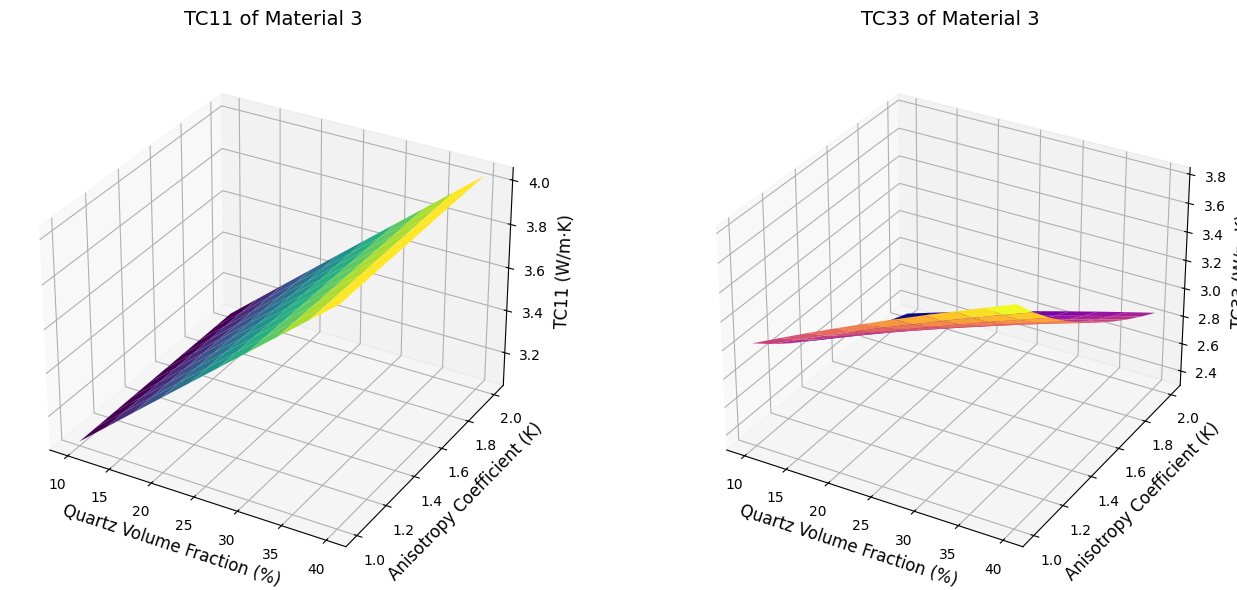

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D


# Input parameters for Material 1 (silica)
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
thermal_conductivities_sio2 = np.array([7.6, 2.4, 3.2])  # Quartz, Opal, Chalcedony
alpha_shape_sio2 = [1, 1, 1]

# Define the range for quartz volume fraction (10% to 40%)
quartz_fractions = np.linspace(0.1, 0.4, 10)  # 20 steps from 10% to 40%

# Input parameters for Material 2 (clay)
initial_volume_illite = 15.8  # Illite volume fraction (%)
initial_volume_kaolinite = 2.3  # Kaolinite volume fraction (%)
tc11_illite = 2.69  # TC11 for illite
tc11_kaolinite = 1.90  # TC11 for kaolinite

# Define the range for anisotropy coefficient K
K_values = np.linspace(1, 2, 10)  # K varies from 1 to 2

# Calculate effective TC for Material 1 (silica)
effective_tc_sio2_results = []
for quartz_fraction in quartz_fractions:
    remaining_fraction = 1 - quartz_fraction
    volume_fractions_sio2 = np.array([quartz_fraction, remaining_fraction / 2, remaining_fraction / 2])
    effective_tc_sio2 = calculate_effective_tc(volume_fractions_sio2, alpha_shape_sio2, thermal_conductivities_sio2)
    print("Sillica",  effective_tc_sio2)
    effective_tc_sio2_results.append(effective_tc_sio2)

# Calculate effective TC for Material 2 (clay)
effective_tc_clay_results = []
for K in K_values:
    tc33_illite = tc11_illite / K
    tc33_kaolinite = tc11_kaolinite / K

    lambda_illite = np.diag([tc11_illite, tc11_illite, tc33_illite])
    lambda_kaolinite = np.diag([tc11_kaolinite, tc11_kaolinite, tc33_kaolinite])

    total_volume_clay = initial_volume_illite + initial_volume_kaolinite
    normalized_illite = initial_volume_illite / total_volume_clay
    normalized_kaolinite = initial_volume_kaolinite / total_volume_clay

    alpha_shapes_clay = [
        [1000.0, 1000.0, 1],  # Illite (anisotropic)
        [1000.0, 1000.0, 1],  # Kaolinite (anisotropic)
    ]

    effective_tensor_clay = effective_conductivity(
        lambda_illite,  # Initial comparison tensor
        [normalized_illite, normalized_kaolinite],
        [lambda_illite, lambda_kaolinite],
        alpha_shapes_clay
    )
    print("Clay",  effective_tensor_clay)
    effective_tc_clay_results.append(effective_tensor_clay)

# Calculate effective TC for Material 3 (composite of Material 1 and Material 2)
tc11_material3 = np.zeros((len(quartz_fractions), len(K_values)))
tc33_material3 = np.zeros((len(quartz_fractions), len(K_values)))

for i, effective_tc_sio2 in enumerate(effective_tc_sio2_results):
    for j, effective_tensor_clay in enumerate(effective_tc_clay_results):
        # Volume fractions for Material 3 (silica + clay)
        total_volume_material3 = initial_volume_sio2 + initial_volume_illite + initial_volume_kaolinite
        normalized_sio2 = initial_volume_sio2 / total_volume_material3
        normalized_clay = (initial_volume_illite + initial_volume_kaolinite) / total_volume_material3

        # Aspect ratios for Material 3
        alpha_shapes_material3 = [
            [1.0, 1.0, 1.0],  # Silica (isotropic) Material 1
            [1000.0, 1000.0, 1],  # Clay (anisotropic) Material 2
        ]

        # Calculate effective thermal conductivity of Material 3
        effective_tensor_material3 = effective_conductivity(
            np.diag([effective_tc_sio2] * 3),  # Initial comparison tensor
            [normalized_sio2, normalized_clay],
            [np.diag([effective_tc_sio2] * 3), effective_tensor_clay],
            alpha_shapes_material3
        )

        print("M3", effective_tensor_material3)

        # Extract TC11 and TC33 from the effective tensor of Material 3
        tc11_material3[i, j] = effective_tensor_material3[0, 0]
        tc33_material3[i, j] = effective_tensor_material3[2, 2]

# Create 3D plots for TC11 and TC33 of Material 3
X, Y = np.meshgrid(quartz_fractions * 100, K_values)

fig = plt.figure(figsize=(14, 6))

# Plot 1: TC11 of Material 3
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, tc11_material3.T, cmap='viridis')
ax1.set_xlabel("Quartz Volume Fraction (%)", fontsize=12)
ax1.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax1.set_zlabel("TC11 (W/m·K)", fontsize=12)
ax1.set_title("TC11 of Material 3", fontsize=14, pad=20)

# Plot 2: TC33 of Material 3
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, tc33_material3.T, cmap='plasma')
ax2.set_xlabel("Quartz Volume Fraction (%)", fontsize=12)
ax2.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax2.set_zlabel("TC33 (W/m·K)", fontsize=12)
ax2.set_title("TC33 of Material 3", fontsize=14, pad=20)

plt.tight_layout()
plt.show()

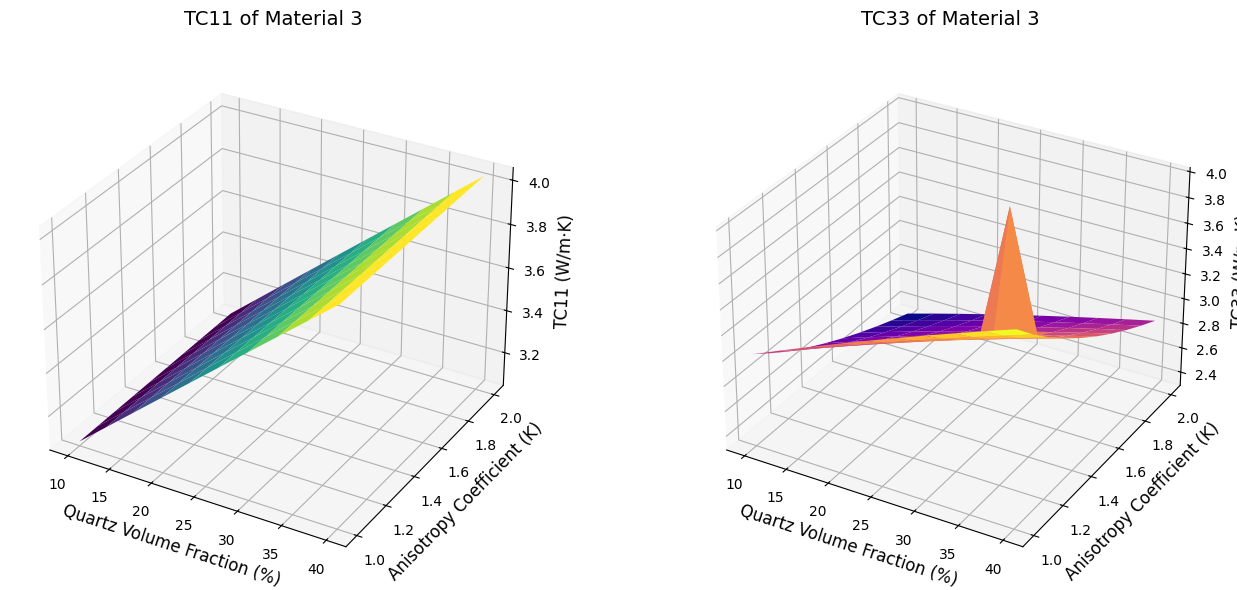

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Input parameters
quartz_fractions = np.linspace(0.1, 0.4, 10)  # Quartz volume fractions (10% to 40%)
K_values = np.linspace(1, 2, 10)  # Anisotropy coefficient K (1 to 2)

# Results from calculations
tc11_material3 = np.array([
    [3.06327373, 3.06324771, 3.06322348, 3.06320082, 3.06317953, 3.06315946, 3.06314048, 3.06312249, 3.06310539, 3.06308909],
    [3.17222437, 3.17218566, 3.17214967, 3.17211602, 3.17208444, 3.17205470, 3.17202659, 3.17199997, 3.17197467, 3.17195057],
    [3.28092433, 3.28087070, 3.28082085, 3.28077428, 3.28073060, 3.28068949, 3.28065069, 3.28061392, 3.28057902, 3.28054580],
    [3.38939517, 3.38932444, 3.38925873, 3.38919741, 3.38913993, 3.38908588, 3.38903487, 3.38898658, 3.38894075, 3.38889715],
    [3.49765571, 3.49756582, 3.49748237, 3.49740456, 3.49733168, 3.49726318, 3.49719856, 3.49713743, 3.49707943, 3.49702426],
    [3.60572252, 3.60561149, 3.60550856, 3.60541262, 3.60532284, 3.60523847, 3.60515892, 3.60508370, 3.60501236, 3.60494455],
    [3.71361030, 3.71347631, 3.71335218, 3.71323656, 3.71312843, 3.71302687, 3.71293116, 3.71284070, 3.71275492, 3.71267343],
    [3.82133213, 3.82117340, 3.82102648, 3.82088974, 3.82076189, 3.82064188, 3.82052884, 3.82042201, 3.82032080, 3.82022467],
    [3.92889957, 3.92871454, 3.92854330, 3.92838405, 3.92823521, 3.92809557, 3.92796410, 3.92783988, 3.92772226, 3.92761057],
    [4.03632325, 4.03611026, 4.03591328, 4.03573019, 4.03555917, 4.03539878, 4.03524780, 4.03510527, 4.03497032, 4.03484221]
])

tc33_material3 = np.array([
    [3.02467624, 2.91633924, 2.81848692, 2.72951942, 2.64816569, 2.57339015, 2.50435040, 2.44034422, 2.38079119, 2.32519603],
    [3.12082717, 3.00721792, 2.90475090, 2.81170840, 2.72672047, 2.64868560, 2.57670272, 2.51002223, 2.44802911, 2.39019649],
    [3.21461584, 3.09581035, 2.98880032, 2.89175012, 2.80319507, 2.72196268, 2.64709077, 2.57779477, 2.51341336, 2.45339216],
    [3.30617894, 3.18224953, 3.07077023, 2.96977648, 2.87771772, 2.79334403, 2.71564525, 2.64378370, 2.57706366, 2.51490060],
    [3.39563772, 3.26665677, 3.15077558, 3.04590569, 2.95040477, 2.86294949, 2.78247556, 2.70809917, 2.63908808, 2.57483339],
    [3.48310434, 3.34914616, 3.22892796, 3.12024554, 3.02135805, 2.93088058, 2.84768357, 2.77084107, 2.69958958, 2.63327752],
    [3.56868190, 3.42981488, 3.30532765, 3.19289458, 3.09068068, 3.99723202, 2.91136207, 2.83210029, 2.75864893, 2.69032421],
    [3.65246539, 3.50875859, 3.38006678, 3.26393904, 3.15845837, 3.06209044, 2.97359588, 2.89196571, 2.81635101, 2.74605302],
    [3.73454622, 3.58606370, 3.45323014, 3.33346866, 3.22477236, 3.12553528, 3.03446264, 2.95050338, 2.87277017, 2.80053667],
    [3.81500001, 3.66181007, 3.52489598, 3.40155705, 3.28969742, 3.18763958, 3.09404019, 3.00778743, 2.92797459, 2.85384183]
])

# Create meshgrid for 3D plotting
X, Y = np.meshgrid(quartz_fractions * 100, K_values)

# Create 3D plots
fig = plt.figure(figsize=(14, 6))

# Plot 1: TC11 of Material 3
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, tc11_material3.T, cmap='viridis')
ax1.set_xlabel("Quartz Volume Fraction (%)", fontsize=12)
ax1.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax1.set_zlabel("TC11 (W/m·K)", fontsize=12)
ax1.set_title("TC11 of Material 3", fontsize=14, pad=20)

# Plot 2: TC33 of Material 3
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, tc33_material3.T, cmap='plasma')
ax2.set_xlabel("Quartz Volume Fraction (%)", fontsize=12)
ax2.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax2.set_zlabel("TC33 (W/m·K)", fontsize=12)
ax2.set_title("TC33 of Material 3", fontsize=14, pad=20)

plt.tight_layout()
plt.show()

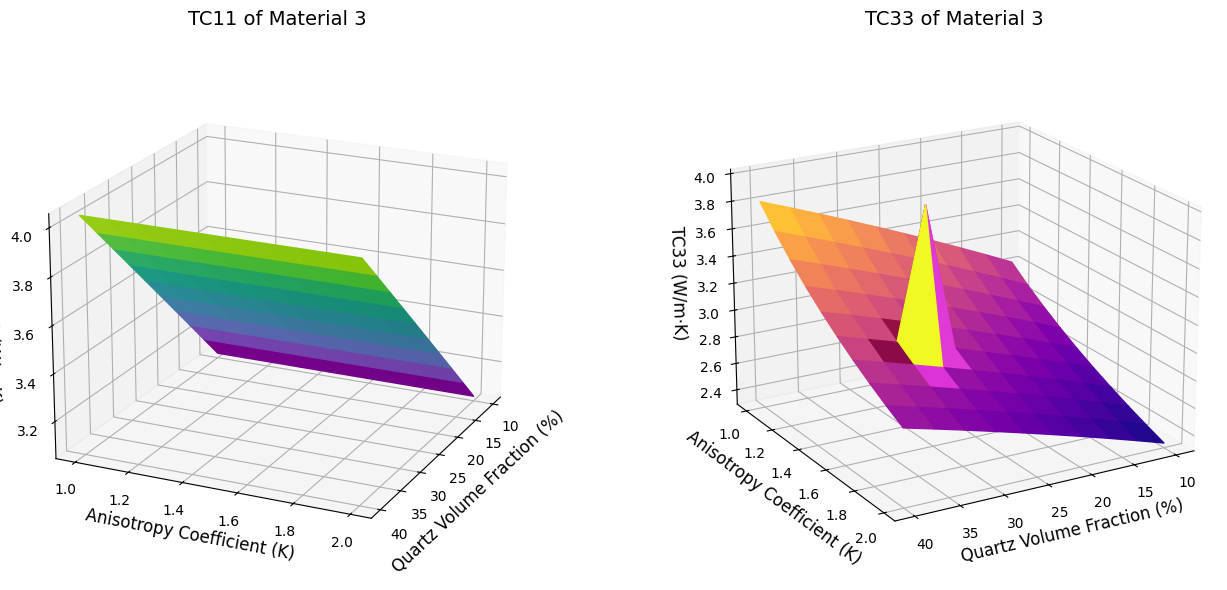

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

# Input parameters
quartz_fractions = np.linspace(0.1, 0.4, 10)  # Quartz volume fractions (10% to 40%)
K_values = np.linspace(1, 2, 10)  # Anisotropy coefficient K (1 to 2)

# Results from calculations
tc11_material3 = np.array([
    [3.06327373, 3.06324771, 3.06322348, 3.06320082, 3.06317953, 3.06315946, 3.06314048, 3.06312249, 3.06310539, 3.06308909],
    [3.17222437, 3.17218566, 3.17214967, 3.17211602, 3.17208444, 3.17205470, 3.17202659, 3.17199997, 3.17197467, 3.17195057],
    [3.28092433, 3.28087070, 3.28082085, 3.28077428, 3.28073060, 3.28068949, 3.28065069, 3.28061392, 3.28057902, 3.28054580],
    [3.38939517, 3.38932444, 3.38925873, 3.38919741, 3.38913993, 3.38908588, 3.38903487, 3.38898658, 3.38894075, 3.38889715],
    [3.49765571, 3.49756582, 3.49748237, 3.49740456, 3.49733168, 3.49726318, 3.49719856, 3.49713743, 3.49707943, 3.49702426],
    [3.60572252, 3.60561149, 3.60550856, 3.60541262, 3.60532284, 3.60523847, 3.60515892, 3.60508370, 3.60501236, 3.60494455],
    [3.71361030, 3.71347631, 3.71335218, 3.71323656, 3.71312843, 3.71302687, 3.71293116, 3.71284070, 3.71275492, 3.71267343],
    [3.82133213, 3.82117340, 3.82102648, 3.82088974, 3.82076189, 3.82064188, 3.82052884, 3.82042201, 3.82032080, 3.82022467],
    [3.92889957, 3.92871454, 3.92854330, 3.92838405, 3.92823521, 3.92809557, 3.92796410, 3.92783988, 3.92772226, 3.92761057],
    [4.03632325, 4.03611026, 4.03591328, 4.03573019, 4.03555917, 4.03539878, 4.03524780, 4.03510527, 4.03497032, 4.03484221]
])

tc33_material3 = np.array([
    [3.02467624, 2.91633924, 2.81848692, 2.72951942, 2.64816569, 2.57339015, 2.50435040, 2.44034422, 2.38079119, 2.32519603],
    [3.12082717, 3.00721792, 2.90475090, 2.81170840, 2.72672047, 2.64868560, 2.57670272, 2.51002223, 2.44802911, 2.39019649],
    [3.21461584, 3.09581035, 2.98880032, 2.89175012, 2.80319507, 2.72196268, 2.64709077, 2.57779477, 2.51341336, 2.45339216],
    [3.30617894, 3.18224953, 3.07077023, 2.96977648, 2.87771772, 2.79334403, 2.71564525, 2.64378370, 2.57706366, 2.51490060],
    [3.39563772, 3.26665677, 3.15077558, 3.04590569, 2.95040477, 2.86294949, 2.78247556, 2.70809917, 2.63908808, 2.57483339],
    [3.48310434, 3.34914616, 3.22892796, 3.12024554, 3.02135805, 2.93088058, 2.84768357, 2.77084107, 2.69958958, 2.63327752],
    [3.56868190, 3.42981488, 3.30532765, 3.19289458, 3.09068068, 3.99723202, 2.91136207, 2.83210029, 2.75864893, 2.69032421],
    [3.65246539, 3.50875859, 3.38006678, 3.26393904, 3.15845837, 3.06209044, 2.97359588, 2.89196571, 2.81635101, 2.74605302],
    [3.73454622, 3.58606370, 3.45323014, 3.33346866, 3.22477236, 3.12553528, 3.03446264, 2.95050338, 2.87277017, 2.80053667],
    [3.81500001, 3.66181007, 3.52489598, 3.40155705, 3.28969742, 3.18763958, 3.09404019, 3.00778743, 2.92797459, 2.85384183]
])

# Create meshgrid for 3D plotting
X, Y = np.meshgrid(quartz_fractions * 100, K_values)

# Create 3D plots
fig = plt.figure(figsize=(14, 6))

# Plot 1: TC11 of Material 3
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel("Quartz Volume Fraction (%)", fontsize=12)
ax1.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax1.set_zlabel("TC11 (W/m·K)", fontsize=12)
ax1.set_title("TC11 of Material 3", fontsize=14, pad=20)

# Add shadow under the plot
ls = LightSource(azdeg=225, altdeg=45)  # Adjust light source direction
rgb = ls.shade(tc11_material3.T, cmap=plt.cm.viridis, vert_exag=0.1, blend_mode='soft')
surf = ax1.plot_surface(X, Y, tc11_material3.T, facecolors=rgb, shade=False)
ax1.view_init(elev=20, azim=25)  # Adjust orientation

# Plot 2: TC33 of Material 3
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_xlabel("Quartz Volume Fraction (%)", fontsize=12)
ax2.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax2.set_zlabel("TC33 (W/m·K)", fontsize=12)
ax2.set_title("TC33 of Material 3", fontsize=14, pad=20)

# Add shadow under the plot
ls = LightSource(azdeg=225, altdeg=45)  # Adjust light source direction
rgb = ls.shade(tc33_material3.T, cmap=plt.cm.plasma, vert_exag=0.1, blend_mode='soft')
surf = ax2.plot_surface(X, Y, tc33_material3.T, facecolors=rgb, shade=False)
ax2.view_init(elev=20, azim=60)  # Adjust orientation

plt.tight_layout()
plt.show()

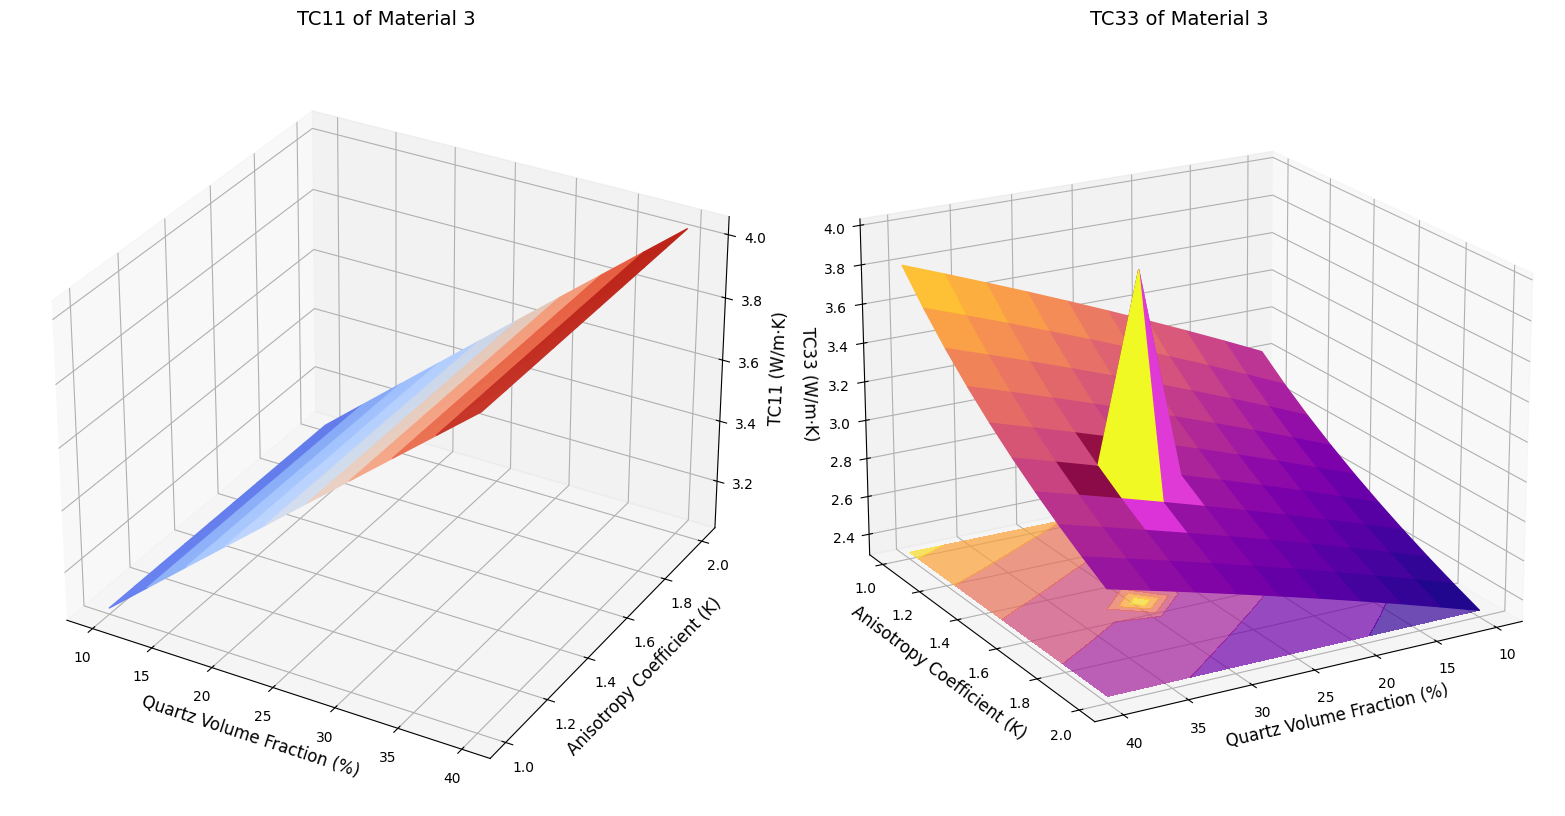

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from matplotlib.ticker import MaxNLocator

# Input parameters
quartz_fractions = np.linspace(0.1, 0.4, 10)  # Quartz volume fractions (10% to 40%)
K_values = np.linspace(1, 2, 10)  # Anisotropy coefficient K (1 to 2)



# Create meshgrid for 3D plotting
X, Y = np.meshgrid(quartz_fractions * 100, K_values)

# Normalize color scales for consistent comparison
vmin = min(tc11_material3.min(), tc33_material3.min())
vmax = max(tc11_material3.max(), tc33_material3.max())

# Create 3D plots
fig = plt.figure(figsize=(16, 8))

# Plot 1: TC11 of Material 3
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel("Quartz Volume Fraction (%)", fontsize=12)
ax1.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax1.set_zlabel("TC11 (W/m·K)", fontsize=12)
ax1.set_title("TC11 of Material 3", fontsize=14, pad=20)

# Add shadow under the plot
ls = LightSource(azdeg=225, altdeg=45)  # Adjust light source direction
rgb = ls.shade(tc11_material3.T, cmap=plt.cm.coolwarm, vert_exag=0.1, blend_mode='soft')
surf = ax1.plot_surface(X, Y, tc11_material3.T, facecolors=rgb, shade=False, rstride=1, cstride=1)

# Add contour projections on the base plane
# cset = ax1.contourf(X, Y, tc11_material3.T, zdir='z', offset=vmin, cmap=plt.cm.coolwarm, alpha=0.7)
# ax1.view_init(elev=20, azim=20)  # Adjust orientation

# Plot 2: TC33 of Material 3
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_xlabel("Quartz Volume Fraction (%)", fontsize=12)
ax2.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax2.set_zlabel("TC33 (W/m·K)", fontsize=12)
ax2.set_title("TC33 of Material 3", fontsize=14, pad=20)

# Add shadow under the plot
ls = LightSource(azdeg=225, altdeg=45)  # Adjust light source direction
rgb = ls.shade(tc33_material3.T, cmap=plt.cm.plasma, vert_exag=0.1, blend_mode='soft')
surf = ax2.plot_surface(X, Y, tc33_material3.T, facecolors=rgb, shade=False, rstride=1, cstride=1)

# Add contour projections on the base plane
cset = ax2.contourf(X, Y, tc33_material3.T, zdir='z', offset=vmin, cmap=plt.cm.plasma, alpha=0.7)
ax2.view_init(elev=20, azim=60)  # Adjust orientation

# Adjust layout and show plot
plt.tight_layout()
plt.show()

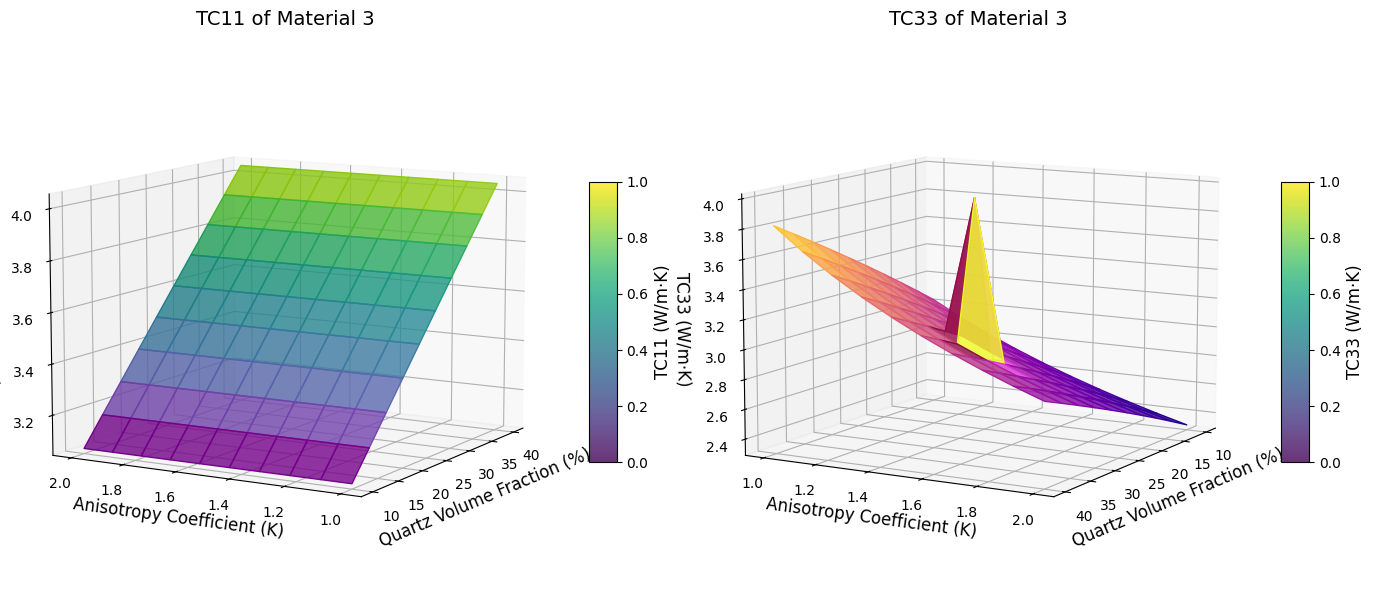

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

# Input parameters
quartz_fractions = np.linspace(0.1, 0.4, 10)  # Quartz volume fractions (10% to 40%)
K_values = np.linspace(1, 2, 10)  # Anisotropy coefficient K (1 to 2)



# Create meshgrid for 3D plotting
X, Y = np.meshgrid(quartz_fractions * 100, K_values)

# Create 3D plots
fig = plt.figure(figsize=(14, 6))

# Plot 1: TC11 of Material 3
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel("Quartz Volume Fraction (%)", fontsize=12)
ax1.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax1.set_zlabel("TC11 (W/m·K)", fontsize=12)
ax1.set_title("TC11 of Material 3", fontsize=14, pad=20)

# Add lighting and shading
ls = LightSource(azdeg=225, altdeg=45)  # Adjust light source direction
rgb = ls.shade(tc11_material3.T, cmap=plt.cm.viridis, vert_exag=0.1, blend_mode='soft')
surf1 = ax1.plot_surface(X, Y, tc11_material3.T, facecolors=rgb, shade=False, alpha=0.8)

# Add colorbar
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
cbar1.set_label("TC11 (W/m·K)", fontsize=12)

# Adjust orientation
ax1.view_init(elev=10, azim=210)

# Plot 2: TC33 of Material 3
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_xlabel("Quartz Volume Fraction (%)", fontsize=12)
ax2.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax2.set_zlabel("TC33 (W/m·K)", fontsize=12)
ax2.set_title("TC33 of Material 3", fontsize=14, pad=20)

# Add lighting and shading
ls = LightSource(azdeg=225, altdeg=45)  # Adjust light source direction
rgb = ls.shade(tc33_material3.T, cmap=plt.cm.plasma, vert_exag=0.1, blend_mode='soft')
surf2 = ax2.plot_surface(X, Y, tc33_material3.T, facecolors=rgb, shade=False, alpha=0.8)

# Add colorbar
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
cbar2.set_label("TC33 (W/m·K)", fontsize=12)

# Adjust orientation
# ax2.view_init(elev=20, azim=60)
ax2.view_init(elev=10, azim=30)

plt.tight_layout()
plt.show()

### Step 3: Material 3 = Material 2 + mineral grains (feldspar, calcite)

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


iteration 2
Material3 [[ 3.00737173e+00  2.09508578e-20  1.59524679e-20]
 [ 1.69484366e-19  3.00737173e+00 -2.31169962e-20]
 [ 3.00123810e-20  7.15199135e-21  2.99472388e+00]]
iteration 2
Material3 [[ 3.00733734e+00 -3.11553191e-20  9.39501092e-21]
 [ 2.23045860e-19  3.00733734e+00  3.92614396e-20]
 [ 1.78230033e-20  4.95570177e-20  2.95923102e+00]]
iteration 2
Material3 [[ 3.00730490e+00  1.08639331e-19  1.81468080e-20]
 [ 1.49532154e-21  3.00730490e+00 -2.97758451e-21]
 [ 2.42342137e-20  1.77077651e-20  2.92596793e+00]]
iteration 2
Material3 [[ 3.00727419e+00  4.91589895e-20  1.93218496e-20]
 [ 9.32072404e-20  3.00727419e+00 -3.08709623e-20]
 [ 4.38255016e-20  3.72802458e-21  2.89467209e+00]]
iteration 3
Material3 [[ 3.00724505e+00 -8.41944943e-20 -1.48223447e-20]
 [ 6.29521995e-20  3.00724505e+00  4.41959416e-20]
 [ 5.04783175e-20 -1.87461511e-20  2.86512620e+00]]
iteration 3
Material3 [[ 3.00721728e+00 -7.61556728e-20  2.30912007e-20]
 [ 1.03627643e-19  3.00721728e+00 -4.82425655e-

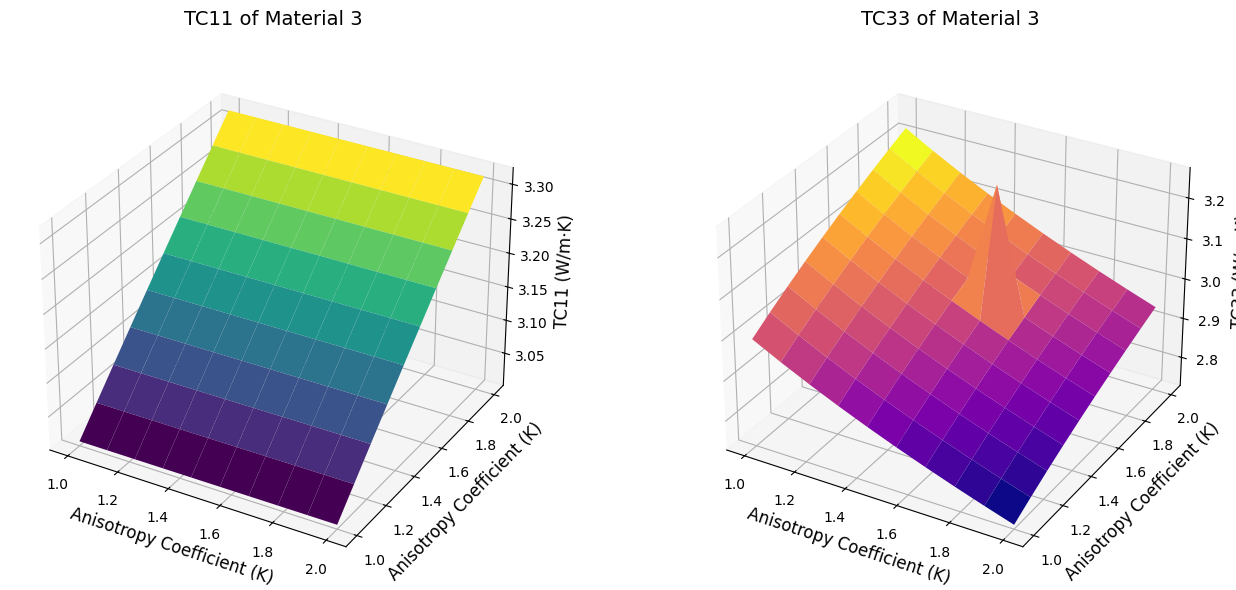

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D

# Input parameters for Material 2 (clay)
initial_volume_illite = 15.8  # Illite volume fraction (%)
initial_volume_kaolinite = 2.3  # Kaolinite volume fraction (%)
tc11_illite = 2.69  # TC11 for illite
tc11_kaolinite = 1.90  # TC11 for kaolinite

# Define the range for anisotropy coefficient K
K_values = np.linspace(1, 2, 10)  # K varies from 1 to 2

# Input parameters for Calcite and Feldspar
tc_calcite = 3.13  # Thermal conductivity of Calcite
tc_feldspar = 2.1  # Thermal conductivity of Feldspar
volume_calcite = 32.5  # Volume fraction of Calcite (%)
volume_feldspar = 4.9  # Volume fraction of Feldspar (%)

# Normalize volume fractions
total_volume = initial_volume_illite + initial_volume_kaolinite + volume_calcite + volume_feldspar
normalized_illite = initial_volume_illite / total_volume
normalized_kaolinite = initial_volume_kaolinite / total_volume
normalized_calcite = volume_calcite / total_volume
normalized_feldspar = volume_feldspar / total_volume

# Define the thermal conductivity tensors for Calcite and Feldspar (isotropic)
lambda_calcite = np.diag([tc_calcite] * 3)
lambda_feldspar = np.diag([tc_feldspar] * 3)

# Define the aspect ratios for Calcite and Feldspar (isotropic)
alpha_shapes_calcite = [1.0, 1.0, 1.0]  # Calcite (isotropic)
alpha_shapes_feldspar = [1.0, 1.0, 1.0]  # Feldspar (isotropic)
alpha_shapes_material2 = [1000.0, 1000.0, 1.0]


# Define the effective thermal conductivity tensors for Material 2 (clay)
tc11_material2 = np.array([
    [3.06327373, 3.06324771, 3.06322348, 3.06320082, 3.06317953, 3.06315946, 3.06314048, 3.06312249, 3.06310539, 3.06308909],
    [3.17222437, 3.17218566, 3.17214967, 3.17211602, 3.17208444, 3.17205470, 3.17202659, 3.17199997, 3.17197467, 3.17195057],
    [3.28092433, 3.28087070, 3.28082085, 3.28077428, 3.28073060, 3.28068949, 3.28065069, 3.28061392, 3.28057902, 3.28054580],
    [3.38939517, 3.38932444, 3.38925873, 3.38919741, 3.38913993, 3.38908588, 3.38903487, 3.38898658, 3.38894075, 3.38889715],
    [3.49765571, 3.49756582, 3.49748237, 3.49740456, 3.49733168, 3.49726318, 3.49719856, 3.49713743, 3.49707943, 3.49702426],
    [3.60572252, 3.60561149, 3.60550856, 3.60541262, 3.60532284, 3.60523847, 3.60515892, 3.60508370, 3.60501236, 3.60494455],
    [3.71361030, 3.71347631, 3.71335218, 3.71323656, 3.71312843, 3.71302687, 3.71293116, 3.71284070, 3.71275492, 3.71267343],
    [3.82133213, 3.82117340, 3.82102648, 3.82088974, 3.82076189, 3.82064188, 3.82052884, 3.82042201, 3.82032080, 3.82022467],
    [3.92889957, 3.92871454, 3.92854330, 3.92838405, 3.92823521, 3.92809557, 3.92796410, 3.92783988, 3.92772226, 3.92761057],
    [4.03632325, 4.03611026, 4.03591328, 4.03573019, 4.03555917, 4.03539878, 4.03524780, 4.03510527, 4.03497032, 4.03484221]
])

tc33_material2 = np.array([
    [3.02467624, 2.91633924, 2.81848692, 2.72951942, 2.64816569, 2.57339015, 2.50435040, 2.44034422, 2.38079119, 2.32519603],
    [3.12082717, 3.00721792, 2.90475090, 2.81170840, 2.72672047, 2.64868560, 2.57670272, 2.51002223, 2.44802911, 2.39019649],
    [3.21461584, 3.09581035, 2.98880032, 2.89175012, 2.80319507, 2.72196268, 2.64709077, 2.57779477, 2.51341336, 2.45339216],
    [3.30617894, 3.18224953, 3.07077023, 2.96977648, 2.87771772, 2.79334403, 2.71564525, 2.64378370, 2.57706366, 2.51490060],
    [3.39563772, 3.26665677, 3.15077558, 3.04590569, 2.95040477, 2.86294949, 2.78247556, 2.70809917, 2.63908808, 2.57483339],
    [3.48310434, 3.34914616, 3.22892796, 3.12024554, 3.02135805, 2.93088058, 2.84768357, 2.77084107, 2.69958958, 2.63327752],
    [3.56868190, 3.42981488, 3.30532765, 3.19289458, 3.09068068, 3.99723202, 2.91136207, 2.83210029, 2.75864893, 2.69032421],
    [3.65246539, 3.50875859, 3.38006678, 3.26393904, 3.15845837, 3.06209044, 2.97359588, 2.89196571, 2.81635101, 2.74605302],
    [3.73454622, 3.58606370, 3.45323014, 3.33346866, 3.22477236, 3.12553528, 3.03446264, 2.95050338, 2.87277017, 2.80053667],
    [3.81500001, 3.66181007, 3.52489598, 3.40155705, 3.28969742, 3.18763958, 3.09404019, 3.00778743, 2.92797459, 2.85384183]
])

# Calculate effective TC for Material 3 (composite of Material 2, Calcite, and Feldspar)
tc11_material3 = np.zeros((len(K_values), len(K_values)))
tc33_material3 = np.zeros((len(K_values), len(K_values)))

for i in range(len(K_values)):
    for j in range(len(K_values)):
        # Define the thermal conductivity tensor for Material 2
        lambda_material2 = np.diag([tc11_material2[i, j], tc11_material2[i, j], tc33_material2[i, j]])

        # Define the thermal conductivity tensors for Calcite and Feldspar
        lambda_calcite = np.diag([tc_calcite] * 3)
        lambda_feldspar = np.diag([tc_feldspar] * 3)

        # Define the volume fractions
        concentrations = [normalized_illite + normalized_kaolinite, normalized_calcite, normalized_feldspar]
        lambda_tensors = [lambda_material2, lambda_calcite, lambda_feldspar]
        alpha_shapes = [alpha_shapes_material2, alpha_shapes_calcite, alpha_shapes_feldspar]

        # Calculate effective thermal conductivity of Material 3
        effective_tensor_material3 = effective_conductivity(
            lambda_material2,  # Initial comparison tensor
            concentrations,
            lambda_tensors,
            alpha_shapes,
        )

        print('Material3', effective_tensor_material3)

        # Extract TC11 and TC33 from the effective tensor of Material 3
        tc11_material3[i, j] = effective_tensor_material3[0, 0]
        tc33_material3[i, j] = effective_tensor_material3[2, 2]

# Create 3D plots for TC11 and TC33 of Material 3
X, Y = np.meshgrid(K_values, K_values)

fig = plt.figure(figsize=(14, 6))

# Plot 1: TC11 of Material 3
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, tc11_material3, cmap='viridis')
ax1.set_xlabel("Anisotropy Coefficient (K)", fontsize=12)
ax1.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax1.set_zlabel("TC11 (W/m·K)", fontsize=12)
ax1.set_title("TC11 of Material 3", fontsize=14, pad=20)

# Plot 2: TC33 of Material 3
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, tc33_material3, cmap='plasma')
ax2.set_xlabel("Anisotropy Coefficient (K)", fontsize=12)
ax2.set_ylabel("Anisotropy Coefficient (K)", fontsize=12)
ax2.set_zlabel("TC33 (W/m·K)", fontsize=12)
ax2.set_title("TC33 of Material 3", fontsize=14, pad=20)

plt.tight_layout()
plt.show()

### Backup

In [ ]:
import numpy as np

# Step 1: Calculate effective thermal conductivity of SiO₂ components
def Likhteneker(volume_fractions, thermal_conductivities):
    """
    Calculate the effective thermal conductivity using the Likhteneker model.
    """
    return np.exp(np.sum(volume_fractions * np.log(thermal_conductivities)))


# Input parameters for Step 1
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
thermal_conductivities_sio2 = np.array([7.6, 2.4, 3.2])  # Quartz, Opal, Chalcedony

# Define the range for quartz volume fraction (10% to 40%)
quartz_fractions = np.linspace(0.1, 0.4, 10)  # 10 steps from 10% to 40%

# Calculate effective thermal conductivity for each quartz fraction
effective_tc_sio2_results = []

for quartz_fraction in quartz_fractions:
    # Adjust the volume fractions for opal and chalcedony
    remaining_fraction = 1 - quartz_fraction
    volume_fractions_sio2 = np.array([quartz_fraction, remaining_fraction / 2, remaining_fraction / 2])

    # Calculate the effective thermal conductivity
    effective_tc_sio2 = calculate_effective_tc(volume_fractions_sio2, alpha_shape, thermal_conductivities_sio2)
    effective_tc_sio2_results.append(effective_tc_sio2)

# Step 2: Calculate effective thermal conductivity of the rock
initial_volume_illite = 18.1  # Total Illite volume fraction in the rock (%)

# Calculate the total volume
total_volume = initial_volume_sio2 + initial_volume_illite

# Normalize the volumes so their sum is 100%
normalized_sio2 = (initial_volume_sio2 / total_volume)
normalized_illite = (initial_volume_illite / total_volume)

# Print results
print(f"Normalized SiO₂ volume: {normalized_sio2:.2f}")
print(f"Normalized Illite volume: {normalized_illite:.2f}")
print(f"Sum of normalized volumes: {normalized_sio2 + normalized_illite:.2f}")

thermal_conductivities_illite = 2.69  # Illite isotropic
thermal_conductivities_illite_anisotropic = np.full((3, 3), 10**-20)
np.fill_diagonal(thermal_conductivities_illite_anisotropic, 1.8)  # Set the diagonal elements to `a0`

# Loop over each quartz fraction and calculate the effective thermal conductivity of the rock
for i, quartz_fraction in enumerate(quartz_fractions):
    print(f"\nQuartz fraction: {quartz_fraction * 100:.1f}%")

    # Update material1 (effective thermal conductivity of SiO₂ components)
    material1 = effective_tc_sio2_results[i]

    # USER INPUT PARAMETERS (ADJUST THESE FOR DIFFERENT CASES)
    N_COMPONENTS = 2  # Number of components (matrix + inclusions)
    LAMBDA_VALUES = [material1, thermal_conductivities_illite]  # Thermal conductivity for each component
    CONCENTRATIONS = [normalized_sio2, normalized_illite]  # Volume fractions (must sum to 1)
    ALPHA_SHAPES = [
        [1.0, 1.0, 1.0],    # Aspect ratios for component 1 (silica)
        [1000.0, 1000.0, 1.0],    # Aspect ratios for component 2 (clay)
    ]

    # Prepare initial parameters
    # lambda_tensors = [np.diagflat([lam] * 3) for lam in LAMBDA_VALUES]
    # X0 = sum(c * lam for c, lam in zip(CONCENTRATIONS, lambda_tensors))
    # X0 = lambda_tensors[0]

    lambda_tensors = [np.diagflat([material1] * 3),  thermal_conductivities_illite_anisotropic]
    X0 = lambda_tensors[0]

    # Anisotropic calculation
    print("Anisotropic effective conductivity:")
    tc_matrix = effective_conductivity(X0, CONCENTRATIONS, lambda_tensors, ALPHA_SHAPES)
    print(np.round(tc_matrix, 6))

    # Isotropic calculation
    print("\nIsotropic effective conductivity:")
    tc_iso = effective_conductivity(X0, CONCENTRATIONS, lambda_tensors, ALPHA_SHAPES, isotropic=True)
    print(np.round(tc_iso, 6))

    # Hashin-Shtrikman bounds
    hs_upper = Upper_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES)
    hs_lower = Lower_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES)
    hs_avg = Hashin_Strikman_Average(CONCENTRATIONS, LAMBDA_VALUES)
    print(f"Hashin-Shtrikman Upper Bound: {hs_upper:.6f}")
    print(f"Hashin-Shtrikman Lower Bound: {hs_lower:.6f}")
    print(f"Hashin-Shtrikman Average: {hs_avg:.6f}")

Normalized SiO₂ volume: 0.69
Normalized Illite volume: 0.31
Sum of normalized volumes: 1.00

Quartz fraction: 10.0%
Anisotropic effective conductivity:
iteration 4
[[ 2.660928  0.        0.      ]
 [ 0.        2.660928 -0.      ]
 [ 0.       -0.        2.555255]]

Isotropic effective conductivity:
iteration 4
2.625703
Hashin-Shtrikman Upper Bound: 2.946115
Hashin-Shtrikman Lower Bound: 2.945806
Hashin-Shtrikman Average: 2.945960

Quartz fraction: 13.3%
Anisotropic effective conductivity:
iteration 5
[[ 2.731408  0.       -0.      ]
 [ 0.        2.731408 -0.      ]
 [ 0.       -0.        2.609407]]

Isotropic effective conductivity:
iteration 5
2.690741
Hashin-Shtrikman Upper Bound: 3.016573
Hashin-Shtrikman Lower Bound: 3.015946
Hashin-Shtrikman Average: 3.016260

Quartz fraction: 16.7%
Anisotropic effective conductivity:
iteration 5
[[ 2.804206 -0.        0.      ]
 [ 0.        2.804206 -0.      ]
 [ 0.       -0.        2.664349]]

Isotropic effective conductivity:
iteration 5
2.75758

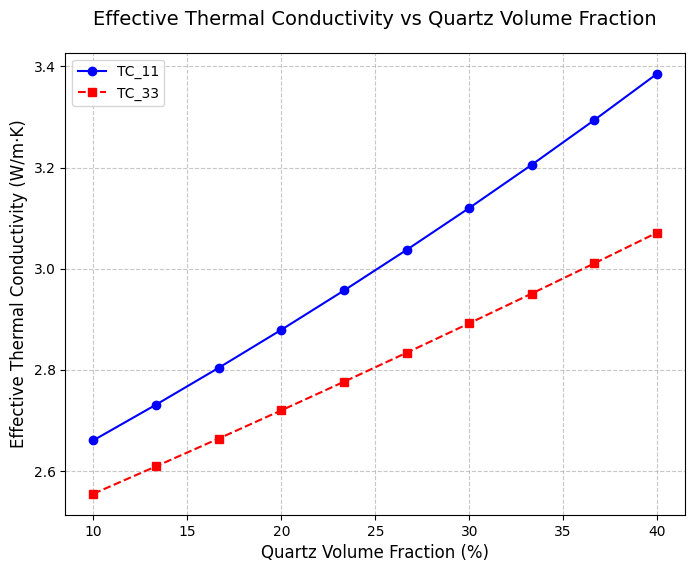

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate effective thermal conductivity of SiO₂ components
# Input parameters for Step 1
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
thermal_conductivities_sio2 = np.array([7.6, 2.4, 3.2])  # Quartz, Opal, Chalcedony

# Define the range for quartz volume fraction (10% to 40%)
quartz_fractions = np.linspace(0.1, 0.4, 10)  # 10 steps from 10% to 40%

# Calculate effective thermal conductivity for each quartz fraction
effective_tc_sio2_results = []

for quartz_fraction in quartz_fractions:
    # Adjust the volume fractions for opal and chalcedony
    remaining_fraction = 1 - quartz_fraction
    volume_fractions_sio2 = np.array([quartz_fraction, remaining_fraction / 2, remaining_fraction / 2])

    # Calculate the effective thermal conductivity
    effective_tc_sio2 = Likhteneker(volume_fractions_sio2, thermal_conductivities_sio2)
    effective_tc_sio2_results.append(effective_tc_sio2)

# Step 2: Calculate effective thermal conductivity of the rock
initial_volume_illite = 18.1  # Total Illite volume fraction in the rock (%)

# Calculate the total volume
total_volume = initial_volume_sio2 + initial_volume_illite

# Normalize the volumes so their sum is 100%
normalized_sio2 = (initial_volume_sio2 / total_volume)
normalized_illite = (initial_volume_illite / total_volume)

# Print results
print(f"Normalized SiO₂ volume: {normalized_sio2:.2f}")
print(f"Normalized Illite volume: {normalized_illite:.2f}")
print(f"Sum of normalized volumes: {normalized_sio2 + normalized_illite:.2f}")

thermal_conductivities_illite = 2.69  # Illite isotropic
thermal_conductivities_illite_anisotropic = np.full((3, 3), 10**-20)
np.fill_diagonal(thermal_conductivities_illite_anisotropic, 1.8)  # Set the diagonal elements to `a0`

# Lists to store tc_11 and tc_33 values
tc_11_values = []
tc_33_values = []

# Loop over each quartz fraction and calculate the effective thermal conductivity of the rock
for i, quartz_fraction in enumerate(quartz_fractions):
    print(f"\nQuartz fraction: {quartz_fraction * 100:.1f}%")

    # Update material1 (effective thermal conductivity of SiO₂ components)
    material1 = effective_tc_sio2_results[i]

    # USER INPUT PARAMETERS (ADJUST THESE FOR DIFFERENT CASES)
    N_COMPONENTS = 2  # Number of components (matrix + inclusions)
    LAMBDA_VALUES = [material1, thermal_conductivities_illite]  # Thermal conductivity for each component
    CONCENTRATIONS = [normalized_sio2, normalized_illite]  # Volume fractions (must sum to 1)
    ALPHA_SHAPES = [
        [1.0, 1.0, 1.0],    # Aspect ratios for component 1 (silica)
        [1000.0, 1000.0, 1.0],    # Aspect ratios for component 2 (clay)
    ]

    # Prepare initial parameters
    # lambda_tensors = [np.diagflat([lam] * 3) for lam in LAMBDA_VALUES]
    # X0 = sum(c * lam for c, lam in zip(CONCENTRATIONS, lambda_tensors))
    # X0 = lambda_tensors[0]

    lambda_tensors = [np.diagflat([material1] * 3),  thermal_conductivities_illite_anisotropic]
    X0 = lambda_tensors[0]

    # Anisotropic calculation
    print("Anisotropic effective conductivity:")
    tc_matrix = effective_conductivity(X0, CONCENTRATIONS, lambda_tensors, ALPHA_SHAPES)
    print(np.round(tc_matrix, 6))

    # Extract tc_11 and tc_33 from the anisotropic tensor
    tc_11 = tc_matrix[0, 0]
    tc_33 = tc_matrix[2, 2]
    tc_11_values.append(tc_11)
    tc_33_values.append(tc_33)

    # Isotropic calculation
    print("\nIsotropic effective conductivity:")
    tc_iso = effective_conductivity(X0, CONCENTRATIONS, lambda_tensors, ALPHA_SHAPES, isotropic=True)
    print(np.round(tc_iso, 6))

    # Hashin-Shtrikman bounds
    hs_upper = Upper_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES)
    hs_lower = Lower_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES)
    hs_avg = Hashin_Strikman_Average(CONCENTRATIONS, LAMBDA_VALUES)
    print(f"Hashin-Shtrikman Upper Bound: {hs_upper:.6f}")
    print(f"Hashin-Shtrikman Lower Bound: {hs_lower:.6f}")
    print(f"Hashin-Shtrikman Average: {hs_avg:.6f}")

# Plot tc_11 and tc_33 vs quartz_fraction
plt.figure(figsize=(8, 6))
plt.plot(quartz_fractions * 100, tc_11_values, marker='o', linestyle='-', color='b', label='TC_11')
plt.plot(quartz_fractions * 100, tc_33_values, marker='s', linestyle='--', color='r', label='TC_33')
plt.xlabel("Quartz Volume Fraction (%)", fontsize=12)
plt.ylabel("Effective Thermal Conductivity (W/m·K)", fontsize=12)
plt.title("Effective Thermal Conductivity vs Quartz Volume Fraction", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)
plt.show()



Normalized SiO₂ volume: 0.69
Normalized Illite volume: 0.31
Sum of normalized volumes: 1.00

Quartz fraction: 10.0%
Anisotropic effective conductivity:


/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


[[ 2.660928  0.        0.      ]
 [ 0.        2.660928 -0.      ]
 [ 0.       -0.        2.555274]]
Hashin-Shtrikman Upper Bound: 2.946115
Hashin-Shtrikman Lower Bound: 2.615553

Quartz fraction: 13.3%
Anisotropic effective conductivity:
[[ 2.731409  0.       -0.      ]
 [ 0.        2.731409 -0.      ]
 [ 0.       -0.        2.609431]]
Hashin-Shtrikman Upper Bound: 3.016573
Hashin-Shtrikman Lower Bound: 2.678207

Quartz fraction: 16.7%
Anisotropic effective conductivity:
[[ 2.804207  0.        0.      ]
 [ 0.        2.804207 -0.      ]
 [ 0.        0.        2.664382]]
Hashin-Shtrikman Upper Bound: 3.089026
Hashin-Shtrikman Lower Bound: 2.742276

Quartz fraction: 20.0%
Anisotropic effective conductivity:
[[ 2.879402 -0.        0.      ]
 [ 0.        2.879402 -0.      ]
 [ 0.       -0.        2.720133]]
Hashin-Shtrikman Upper Bound: 3.163546
Hashin-Shtrikman Lower Bound: 2.807770

Quartz fraction: 23.3%
Anisotropic effective conductivity:
[[ 2.957075  0.        0.      ]
 [-0.        2.

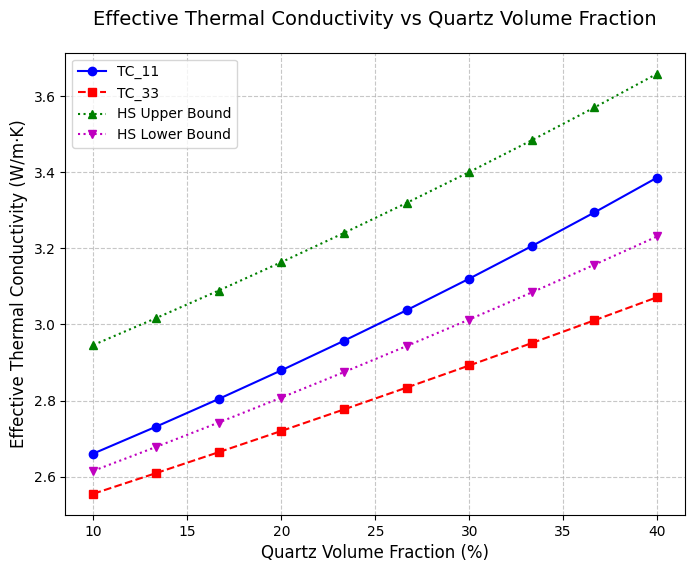

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate effective thermal conductivity of SiO₂ components
def Likhteneker(volume_fractions, thermal_conductivities):
    """
    Calculate the effective thermal conductivity using the Likhteneker model.
    """
    return np.exp(np.sum(volume_fractions * np.log(thermal_conductivities)))


# Input parameters for Step 1
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
thermal_conductivities_sio2 = np.array([7.6, 2.4, 3.2])  # Quartz, Opal, Chalcedony

# Define the range for quartz volume fraction (10% to 40%)
quartz_fractions = np.linspace(0.1, 0.4, 10)  # 10 steps from 10% to 40%

# Calculate effective thermal conductivity for each quartz fraction
effective_tc_sio2_results = []

for quartz_fraction in quartz_fractions:
    # Adjust the volume fractions for opal and chalcedony
    remaining_fraction = 1 - quartz_fraction
    volume_fractions_sio2 = np.array([quartz_fraction, remaining_fraction / 2, remaining_fraction / 2])

    # Calculate the effective thermal conductivity
    effective_tc_sio2 = Likhteneker(volume_fractions_sio2, thermal_conductivities_sio2)
    effective_tc_sio2_results.append(effective_tc_sio2)

# Step 2: Calculate effective thermal conductivity of the rock
initial_volume_illite = 18.1  # Total Illite volume fraction in the rock (%)

# Calculate the total volume
total_volume = initial_volume_sio2 + initial_volume_illite

# Normalize the volumes so their sum is 100%
normalized_sio2 = (initial_volume_sio2 / total_volume)
normalized_illite = (initial_volume_illite / total_volume)

# Print results
print(f"Normalized SiO₂ volume: {normalized_sio2:.2f}")
print(f"Normalized Illite volume: {normalized_illite:.2f}")
print(f"Sum of normalized volumes: {normalized_sio2 + normalized_illite:.2f}")

thermal_conductivities_illite = 2.69  # Illite isotropic
thermal_conductivities_illite_anisotropic = np.full((3, 3), 10**-20)
np.fill_diagonal(thermal_conductivities_illite_anisotropic, 1.8)  # Set the diagonal elements to `a0`

# Lists to store tc_11, tc_33, HS upper, and HS lower values
tc_11_values = []
tc_33_values = []
hs_upper_values = []
hs_lower_values = []

# Loop over each quartz fraction and calculate the effective thermal conductivity of the rock
for i, quartz_fraction in enumerate(quartz_fractions):
    print(f"\nQuartz fraction: {quartz_fraction * 100:.1f}%")

    # Update material1 (effective thermal conductivity of SiO₂ components)
    material1 = effective_tc_sio2_results[i]

    # USER INPUT PARAMETERS (ADJUST THESE FOR DIFFERENT CASES)
    N_COMPONENTS = 2  # Number of components (matrix + inclusions)
    LAMBDA_VALUES = [material1, thermal_conductivities_illite]  # Thermal conductivity for each component
    CONCENTRATIONS = [normalized_sio2, normalized_illite]  # Volume fractions (must sum to 1)
    ALPHA_SHAPES = [
        [1.0, 1.0, 1.0],    # Aspect ratios for component 1 (silica)
        [1000.0, 1000.0, 1.0],    # Aspect ratios for component 2 (clay)
    ]

    # Prepare initial parameters
    lambda_tensors = [np.diagflat([material1] * 3), thermal_conductivities_illite_anisotropic]
    X0 = lambda_tensors[0]

    # Anisotropic calculation
    print("Anisotropic effective conductivity:")
    tc_matrix = effective_conductivity(X0, CONCENTRATIONS, lambda_tensors, ALPHA_SHAPES)
    print(np.round(tc_matrix, 6))

    # Extract tc_11 and tc_33 from the anisotropic tensor
    tc_11 = tc_matrix[0, 0]
    tc_33 = tc_matrix[2, 2]
    tc_11_values.append(tc_11)
    tc_33_values.append(tc_33)

    # Hashin-Shtrikman bounds
    LAMBDA_VALUES = [material1, 2.69]  # Thermal conductivity for each component
    hs_upper = Upper_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES)

    LAMBDA_VALUES = [material1, 1.8]  # Thermal conductivity for each component
    hs_lower = Lower_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES)

    hs_upper_values.append(hs_upper)
    hs_lower_values.append(hs_lower)
    print(f"Hashin-Shtrikman Upper Bound: {hs_upper:.6f}")
    print(f"Hashin-Shtrikman Lower Bound: {hs_lower:.6f}")

# Plot tc_11, tc_33, HS upper, and HS lower vs quartz_fraction
plt.figure(figsize=(8, 6))
plt.plot(quartz_fractions * 100, tc_11_values, marker='o', linestyle='-', color='b', label='TC_11')
plt.plot(quartz_fractions * 100, tc_33_values, marker='s', linestyle='--', color='r', label='TC_33')
plt.plot(quartz_fractions * 100, hs_upper_values, marker='^', linestyle=':', color='g', label='HS Upper Bound')
plt.plot(quartz_fractions * 100, hs_lower_values, marker='v', linestyle=':', color='m', label='HS Lower Bound')
plt.xlabel("Quartz Volume Fraction (%)", fontsize=12)
plt.ylabel("Effective Thermal Conductivity (W/m·K)", fontsize=12)
plt.title("Effective Thermal Conductivity vs Quartz Volume Fraction", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)
plt.show()

Normalized SiO₂ volume: 0.69
Normalized Illite volume: 0.31
Sum of normalized volumes: 1.00

Quartz fraction: 10.0%
Anisotropic effective conductivity:
iteration 3
[[ 2.94842  -0.        0.      ]
 [ 0.        2.94842  -0.      ]
 [ 0.        0.        2.941063]]

Isotropic effective conductivity:
iteration 3
2.945967
Hashin-Shtrikman Upper Bound: 2.946115
Hashin-Shtrikman Lower Bound: 2.945806
Hashin-Shtrikman Average: 2.945960

Quartz fraction: 13.3%
Anisotropic effective conductivity:
iteration 3
[[ 3.020238  0.       -0.      ]
 [ 0.        3.020238 -0.      ]
 [ 0.        0.        3.008352]]

Isotropic effective conductivity:
iteration 3
3.016276
Hashin-Shtrikman Upper Bound: 3.016573
Hashin-Shtrikman Lower Bound: 3.015946
Hashin-Shtrikman Average: 3.016260

Quartz fraction: 16.7%
Anisotropic effective conductivity:
iteration 3
[[ 3.094376  0.        0.      ]
 [ 0.        3.094376 -0.      ]
 [ 0.        0.        3.076746]]

Isotropic effective conductivity:
iteration 3
3.08849

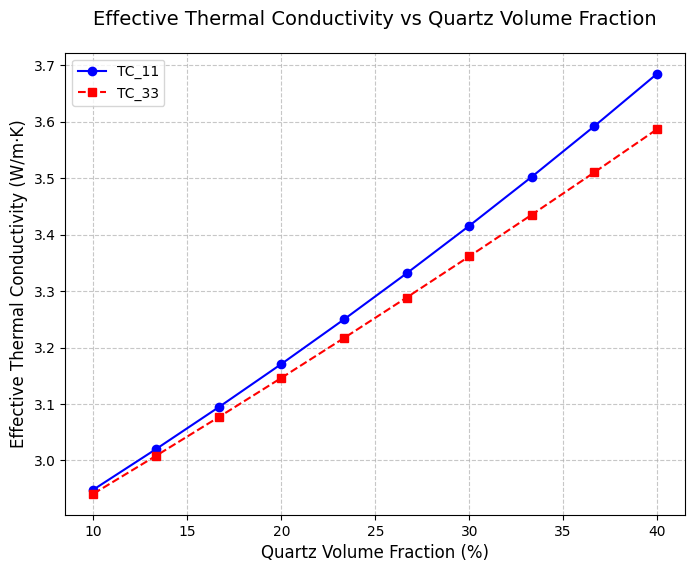

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate effective thermal conductivity of SiO₂ components
def Likhteneker(volume_fractions, thermal_conductivities):
    """
    Calculate the effective thermal conductivity using the Likhteneker model.
    """
    return np.exp(np.sum(volume_fractions * np.log(thermal_conductivities)))


# Input parameters for Step 1
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
thermal_conductivities_sio2 = np.array([7.6, 2.4, 3.2])  # Quartz, Opal, Chalcedony

# Define the range for quartz volume fraction (10% to 40%)
quartz_fractions = np.linspace(0.1, 0.4, 10)  # 10 steps from 10% to 40%

# Calculate effective thermal conductivity for each quartz fraction
effective_tc_sio2_results = []

for quartz_fraction in quartz_fractions:
    # Adjust the volume fractions for opal and chalcedony
    remaining_fraction = 1 - quartz_fraction
    volume_fractions_sio2 = np.array([quartz_fraction, remaining_fraction / 2, remaining_fraction / 2])

    # Calculate the effective thermal conductivity
    effective_tc_sio2 = Likhteneker(volume_fractions_sio2, thermal_conductivities_sio2)
    effective_tc_sio2_results.append(effective_tc_sio2)

# Step 2: Calculate effective thermal conductivity of the rock
initial_volume_illite = 18.1  # Total Illite volume fraction in the rock (%)

# Calculate the total volume
total_volume = initial_volume_sio2 + initial_volume_illite

# Normalize the volumes so their sum is 100%
normalized_sio2 = (initial_volume_sio2 / total_volume)
normalized_illite = (initial_volume_illite / total_volume)

# Print results
print(f"Normalized SiO₂ volume: {normalized_sio2:.2f}")
print(f"Normalized Illite volume: {normalized_illite:.2f}")
print(f"Sum of normalized volumes: {normalized_sio2 + normalized_illite:.2f}")

thermal_conductivities_illite = 2.69  # Illite

# Lists to store tc_11 and tc_33 values
tc_11_values = []
tc_33_values = []

# Loop over each quartz fraction and calculate the effective thermal conductivity of the rock
for i, quartz_fraction in enumerate(quartz_fractions):
    print(f"\nQuartz fraction: {quartz_fraction * 100:.1f}%")

    # Update material1 (effective thermal conductivity of SiO₂ components)
    material1 = effective_tc_sio2_results[i]

    # USER INPUT PARAMETERS (ADJUST THESE FOR DIFFERENT CASES)
    N_COMPONENTS = 2  # Number of components (matrix + inclusions)
    LAMBDA_VALUES = [material1, thermal_conductivities_illite]  # Thermal conductivity for each component
    CONCENTRATIONS = [normalized_sio2, normalized_illite]  # Volume fractions (must sum to 1)
    ALPHA_SHAPES = [
        [1.0, 1.0, 1.0],    # Aspect ratios for component 1 (silica)
        [1000.0, 1000.0, 1.0],    # Aspect ratios for component 2 (clay)
    ]

    # Prepare initial parameters
    lambda_tensors = [np.diagflat([lam] * 3) for lam in LAMBDA_VALUES]
    X0 = sum(c * lam for c, lam in zip(CONCENTRATIONS, lambda_tensors))
    X0 = lambda_tensors[0]

    # Anisotropic calculation
    print("Anisotropic effective conductivity:")
    tc_matrix = effective_conductivity(X0, CONCENTRATIONS, lambda_tensors, ALPHA_SHAPES)
    print(np.round(tc_matrix, 6))

    # Extract tc_11 and tc_33 from the anisotropic tensor
    tc_11 = tc_matrix[0, 0]
    tc_33 = tc_matrix[2, 2]
    tc_11_values.append(tc_11)
    tc_33_values.append(tc_33)

    # Isotropic calculation
    print("\nIsotropic effective conductivity:")
    tc_iso = effective_conductivity(X0, CONCENTRATIONS, lambda_tensors, ALPHA_SHAPES, isotropic=True)
    print(np.round(tc_iso, 6))

    # Hashin-Shtrikman bounds
    hs_upper = Upper_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES)
    hs_lower = Lower_Hashin_Strikman(CONCENTRATIONS, LAMBDA_VALUES)
    hs_avg = Hashin_Strikman_Average(CONCENTRATIONS, LAMBDA_VALUES)
    print(f"Hashin-Shtrikman Upper Bound: {hs_upper:.6f}")
    print(f"Hashin-Shtrikman Lower Bound: {hs_lower:.6f}")
    print(f"Hashin-Shtrikman Average: {hs_avg:.6f}")

# Plot tc_11 and tc_33 vs quartz_fraction
plt.figure(figsize=(8, 6))
plt.plot(quartz_fractions * 100, tc_11_values, marker='o', linestyle='-', color='b', label='TC_11')
plt.plot(quartz_fractions * 100, tc_33_values, marker='s', linestyle='--', color='r', label='TC_33')
plt.xlabel("Quartz Volume Fraction (%)", fontsize=12)
plt.ylabel("Effective Thermal Conductivity (W/m·K)", fontsize=12)
plt.title("Effective Thermal Conductivity vs Quartz Volume Fraction", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)
plt.show()

Дифференциальная схема — это метод расчета эффективной теплопроводности гетерогенных материалов, который учитывает постепенное добавление включений в матрицу. Этот метод особенно полезен для сред с высокой концентрацией включений.

Формула дифференциальной схемы
Для двухкомпонентной системы (матрица и включения) дифференциальная схема описывается следующим дифференциальным уравнением:

d
κ
eff
d
f
=
κ
inc
−
κ
eff
1
−
f
⋅
3
κ
eff
κ
inc
+
2
κ
eff
,
df
dκ
eff
​

​
 =
1−f
κ
inc
​
 −κ
eff
​

​
 ⋅
κ
inc
​
 +2κ
eff
​

3κ
eff
​

​
 ,
где:

κ
eff
κ
eff
​
  — эффективная теплопроводность,

κ
inc
κ
inc
​
  — теплопроводность включений,

κ
mat
κ
mat
​
  — теплопроводность матрицы,

f
f — объемная доля включений.

Начальное условие:

κ
eff
(
0
)
=
κ
mat
.
κ
eff
​
 (0)=κ
mat
​
 .

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

def rotation_matrix(axis, angle):
    """
    Создает матрицу поворота для заданной оси и угла.

    Параметры:
        axis (str): Ось вращения ('x', 'y', или 'z').
        angle (float): Угол поворота в радианах.

    Возвращает:
        np.ndarray: Матрица поворота 3x3.
    """
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    if axis == 'x':
        return np.array([
            [1, 0, 0],
            [0, cos_a, -sin_a],
            [0, sin_a, cos_a]
        ])
    elif axis == 'y':
        return np.array([
            [cos_a, 0, sin_a],
            [0, 1, 0],
            [-sin_a, 0, cos_a]
        ])
    elif axis == 'z':
        return np.array([
            [cos_a, -sin_a, 0],
            [sin_a, cos_a, 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'.")

def rotate_tensor(kappa, axis, angle):
    """
    Поворачивает тензор теплопроводности.

    Параметры:
        kappa (np.ndarray): Тензор теплопроводности 3x3.
        axis (str): Ось вращения ('x', 'y', или 'z').
        angle (float): Угол поворота в радианах.

    Возвращает:
        np.ndarray: Повернутый тензор теплопроводности 3x3.
    """
    R = rotation_matrix(axis, angle)
    return R @ kappa @ R.T

def differential_scheme_anisotropic(f, kappa_eff_flat, kappas, fs, shapes, angles):
    """
    Дифференциальное уравнение для анизотропного случая.

    Параметры:
        f (float): Текущая объемная доля.
        kappa_eff_flat (np.ndarray): Плоский массив эффективного тензора теплопроводности.
        kappas (list): Список тензоров теплопроводности компонентов.
        fs (list): Список объемных долей компонентов.
        shapes (list): Список аспектных соотношений компонентов.
        angles (list): Список углов поворота компонентов.

    Возвращает:
        np.ndarray: Производная эффективного тензора теплопроводности.
    """
    kappa_eff = kappa_eff_flat.reshape(3, 3)
    dkappa_eff = np.zeros((3, 3))

    for i in range(len(kappas)):
        if fs[i] > 0:
            # Поворот тензора теплопроводности
            kappa_rotated = rotate_tensor(kappas[i], 'z', angles[i])
            # Вычисление вклада компонента
            numerator = kappa_rotated - kappa_eff
            denominator = (1 - fs[i]) * (kappa_rotated + 2 * kappa_eff)
            dkappa_eff += numerator / denominator * fs[i]

    return dkappa_eff.flatten()

def calculate_effective_conductivity_anisotropic(kappa_mat, kappas, fs_max, shapes, angles, n_steps=50):
    """
    Расчет эффективной теплопроводности для анизотропного случая.

    Параметры:
        kappa_mat (np.ndarray): Тензор теплопроводности матрицы.
        kappas (list): Список тензоров теплопроводности включений.
        fs_max (list): Список максимальных объемных долей включений.
        shapes (list): Список аспектных соотношений включений.
        angles (list): Список углов поворота включений.
        n_steps (int): Количество шагов интегрирования.

    Возвращает:
        tuple: Массив объемных долей и соответствующих значений эффективной теплопроводности.
    """
    # Начальное условие
    kappa_eff_0 = kappa_mat.flatten()

    # Диапазон объемных долей
    f_values = np.linspace(0, sum(fs_max), n_steps)

    # Решение дифференциального уравнения
    sol = solve_ivp(
        lambda f, kappa_eff_flat: differential_scheme_anisotropic(f, kappa_eff_flat, kappas, fs_max, shapes, angles),
        [0, sum(fs_max)],
        kappa_eff_0,
        t_eval=f_values
    )

    # Преобразование результатов в тензоры
    kappa_eff_tensors = [kappa.reshape(3, 3) for kappa in sol.y.T]
    return sol.t, kappa_eff_tensors

# Пример использования
kappa_mat = np.diag([4.0, 4.0, 4.0])  # Изотропная матрица
kappas = [
    np.diag([0.025, 0.025, 0.025]),  # Анизотропное включение 1
    np.diag([0.025, 0.025, 0.025])     # Анизотропное включение 2
]
fs_max = [0.075, 0.005]  # Максимальные объемные доли включений
shapes = [[1.0, 1.0, 1.0], [10, 10, 1]]  # Форма включений (сферы)
# angles = [np.radians(45), np.radians(30)]  # Углы поворота включений
angles = [np.radians(0), np.radians(0)]  # Углы поворота включений

f_values, kappa_eff_tensors = calculate_effective_conductivity_anisotropic(kappa_mat, kappas, fs_max, shapes, angles)

# Вывод результатов
print("Объемная доля (f) | Эффективная теплопроводность (kappa_eff)")
for f, kappa_eff in zip(f_values, kappa_eff_tensors):
    print(f"{f:.3f} |")
    print(kappa_eff)



<ipython-input-28-198bcb5dcef1>:78: RuntimeWarning: invalid value encountered in divide
  dkappa_eff += numerator / denominator * fs[i]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-198bcb5dcef1>", line 126, in <cell line: 0>
    f_values, kappa_eff_tensors = calculate_effective_conductivity_anisotropic(kappa_mat, kappas, fs_max, shapes, angles)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-28-198bcb5dcef1>", line 104, in calculate_effective_conductivity_anisotropic
    sol = solve_ivp(
          ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/ivp.py", line 655, in solve_ivp
    message = solver.step()
              ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/base.py", line 197, in step
    success, message = self._step_impl()
                       ^^^^^^^^^^^^^^^^^
  File "/usr/

In [ ]:
!pip install porepy

ERROR: Could not find a version that satisfies the requirement porepy (from versions: none)
ERROR: No matching distribution found for porepy


# Example

In [ ]:
# Step 1
initial_volume = 40.5 # Total SiO₂ volume fraction in the rock (%)
# Normalize the SiO₂ components to 100% within the initial_volume
volume_fractions_sio2 = np.array([0.8, 0.2])  # Equal distribution for quartz, opal, chalcedony
thermal_conductivities_sio2 = np.array([7.6, 3.2])  # Quartz, Chalcedony
alpha_shape_sio2 = [1, 1]

# Calculate the effective thermal conductivity of the SiO₂ components
effective_tc_sio2 = calculate_effective_tc(volume_fractions_sio2, alpha_shape_sio2, thermal_conductivities_sio2)

# effective_EMT_tc_sio2 = Likhteneker(volume_fractions_sio2, thermal_conductivities_sio2)

# print(f"Effective thermal conductivity of SiO₂ components by Likhteneker: {effective_tc_sio2:.2f} W/m·K")
print(f"Effective thermal conductivity of SiO₂ components by EMT: {effective_tc_sio2:.2f} W/m·K")


material1 = effective_tc_sio2

Effective thermal conductivity of SiO₂ components by EMT: 6.54 W/m·K


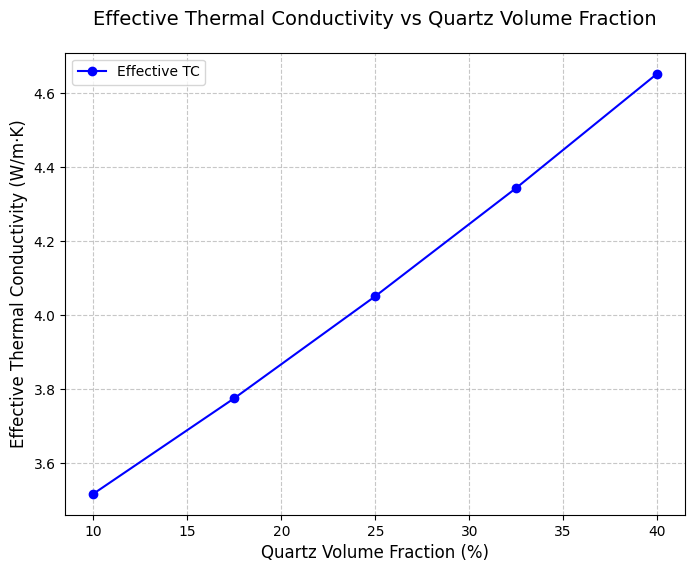

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Input parameters
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
thermal_conductivities_sio2 = np.array([7.6, 3.2])  # Quartz, Chalcedony

# Define the range for quartz volume fraction (10% to 40%)
quartz_fractions = np.linspace(0.1, 0.4, 5)  # 10 steps from 10% to 40%

alpha_shape_sio2 = [1, 1]

# Calculate effective thermal conductivity for each quartz fraction
effective_tc_sio2_results = []

for quartz_fraction in quartz_fractions:
    # Adjust the volume fractions for chalcedony
    remaining_fraction = 1 - quartz_fraction
    volume_fractions_sio2 = np.array([quartz_fraction, remaining_fraction ])


    # Calculate the effective thermal conductivity
    effective_tc_sio2 = calculate_effective_tc(volume_fractions_sio2, alpha_shape_sio2, thermal_conductivities_sio2)
    effective_tc_sio2_results.append(effective_tc_sio2)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(quartz_fractions * 100, effective_tc_sio2_results, marker='o', linestyle='-', color='b', label='Effective TC')
plt.xlabel("Quartz Volume Fraction (%)", fontsize=12)
plt.ylabel("Effective Thermal Conductivity (W/m·K)", fontsize=12)
plt.title("Effective Thermal Conductivity vs Quartz Volume Fraction", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)
plt.show()

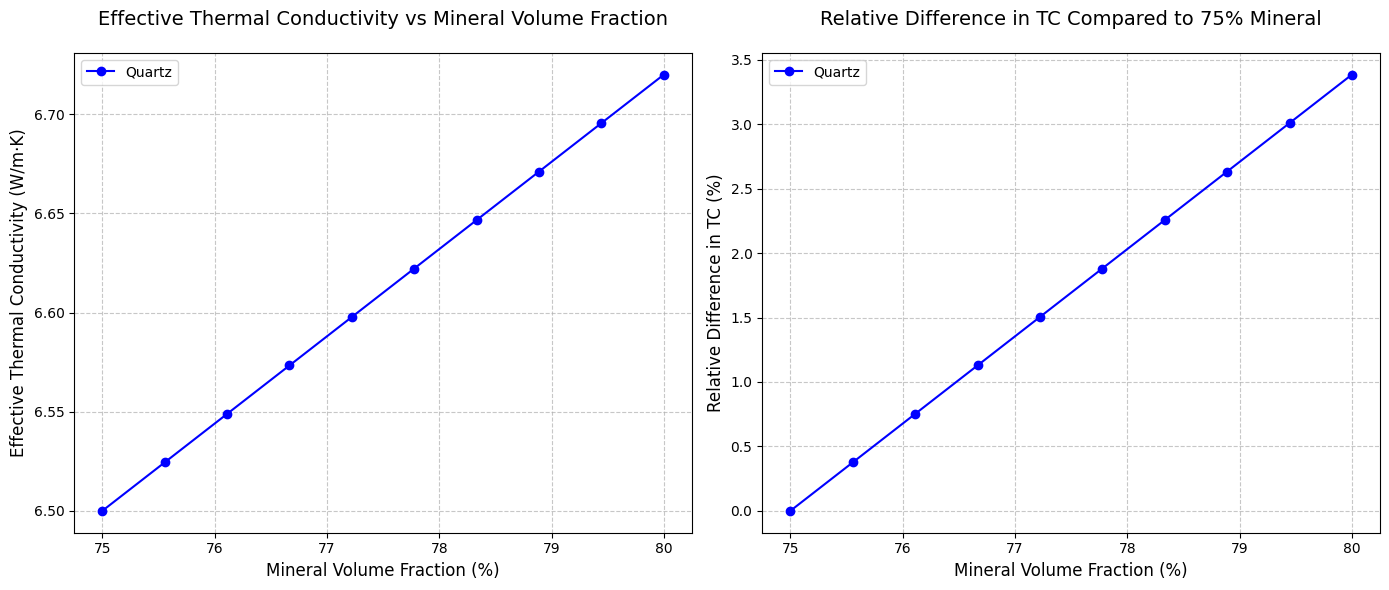

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate effective thermal conductivity
def calculate_effective_tc(volume_fractions, alpha_shape, thermal_conductivities):
    numerator = np.sum(volume_fractions * alpha_shape * thermal_conductivities)
    denominator = np.sum(volume_fractions * alpha_shape)
    effective_tc = numerator / denominator
    return effective_tc

# Input parameters
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
thermal_conductivities_sio2 = np.array([7.6, 3.2])  # Quartz, Opal, Chalcedony

# Define the range for quartz, opal, and chalcedony volume fractions (10% to 40%)
mineral_fractions = np.linspace(0.75, 0.8, 10)  # 10 steps from 10% to 40%

alpha_shape_sio2 = [1, 1]  # Shape factors for Quartz, Opal, Chalcedony

# Calculate effective thermal conductivity for each mineral fraction
effective_tc_quartz_results = []
effective_tc_opal_results = []
effective_tc_chalcedony_results = []

for mineral_fraction in mineral_fractions:
    # Quartz case
    remaining_fraction_quartz = 1 - mineral_fraction
    volume_fractions_quartz = np.array([mineral_fraction, remaining_fraction_quartz])
    effective_tc_quartz = calculate_effective_tc(volume_fractions_quartz, alpha_shape_sio2, thermal_conductivities_sio2)
    effective_tc_quartz_results.append(effective_tc_quartz)


    # Chalcedony case
    remaining_fraction_chalcedony = 1 - mineral_fraction
    volume_fractions_chalcedony = np.array([remaining_fraction_chalcedony, mineral_fraction])
    effective_tc_chalcedony = calculate_effective_tc(volume_fractions_chalcedony, alpha_shape_sio2, thermal_conductivities_sio2)
    effective_tc_chalcedony_results.append(effective_tc_chalcedony)

# Calculate the TC for the baseline case (10% mineral)
baseline_mineral_fraction = 0.75
remaining_fraction_baseline = 1 - baseline_mineral_fraction
baseline_volume_fractions = np.array([baseline_mineral_fraction, remaining_fraction_baseline])
baseline_tc = calculate_effective_tc(baseline_volume_fractions, alpha_shape_sio2, thermal_conductivities_sio2)

# Calculate the relative difference for each mineral fraction
relative_differences_quartz = []
relative_differences_opal = []
relative_differences_chalcedony = []

for tc_quartz, tc_chalcedony in zip(effective_tc_quartz_results, effective_tc_chalcedony_results):
    relative_diff_quartz = ((tc_quartz - baseline_tc) / baseline_tc) * 100  # Relative difference in %
    relative_diff_chalcedony = ((tc_chalcedony - baseline_tc) / baseline_tc) * 100
    relative_differences_quartz.append(relative_diff_quartz)
    relative_differences_chalcedony.append(relative_diff_chalcedony)

# Plot the results
plt.figure(figsize=(14, 6))

# Plot 1: Effective Thermal Conductivity vs Mineral Volume Fraction
plt.subplot(1, 2, 1)
plt.plot(mineral_fractions * 100, effective_tc_quartz_results, marker='o', linestyle='-', color='b', label='Quartz')
# plt.plot(mineral_fractions * 100, effective_tc_chalcedony_results, marker='^', linestyle='-', color='r', label='Chalcedony')
plt.xlabel("Mineral Volume Fraction (%)", fontsize=12)
plt.ylabel("Effective Thermal Conductivity (W/m·K)", fontsize=12)
plt.title("Effective Thermal Conductivity vs Mineral Volume Fraction", fontsize=14, pad=20)
# plt.xlim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)

# Plot 2: Relative Difference in TC Compared to 10% Mineral
plt.subplot(1, 2, 2)
plt.plot(mineral_fractions * 100, relative_differences_quartz, marker='o', linestyle='-', color='b', label='Quartz')
# plt.plot(mineral_fractions * 100, relative_differences_chalcedony, marker='^', linestyle='-', color='r', label='Chalcedony')
plt.xlabel("Mineral Volume Fraction (%)", fontsize=12)
plt.ylabel("Relative Difference in TC (%)", fontsize=12)
plt.title("Relative Difference in TC Compared to 75% Mineral", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.xlim(0, 25)
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Step 1
initial_volume = 40.5 # Total SiO₂ volume fraction in the rock (%)
# Normalize the SiO₂ components to 100% within the initial_volume
volume_fractions_sio2 = np.array([0.8, 0.2])  # Equal distribution for quartz, opal, chalcedony
thermal_conductivities_sio2 = np.array([7.6, 3.2])  # Quartz, Chalcedony
alpha_shape_sio2 = [1, 1]

# Calculate the effective thermal conductivity of the SiO₂ components
effective_tc_sio2 = calculate_effective_tc(volume_fractions_sio2, alpha_shape_sio2, thermal_conductivities_sio2)

# effective_EMT_tc_sio2 = Likhteneker(volume_fractions_sio2, thermal_conductivities_sio2)

# print(f"Effective thermal conductivity of SiO₂ components by Likhteneker: {effective_tc_sio2:.2f} W/m·K")
print(f"Effective thermal conductivity of SiO₂ components by EMT: {effective_tc_sio2:.2f} W/m·K")


material1 = effective_tc_sio2

Effective thermal conductivity of SiO₂ components by EMT: 6.72 W/m·K


In [ ]:
material1

6.720000000000001

### 2.1 Clay effective thermal conductivity

18.1 0.8729281767955801 0.12707182320441987


/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Converged after 1 iterations
[[2.58959215e+00 3.42742542e-22 1.40184730e-22]
 [3.42742542e-22 2.58959215e+00 5.15325030e-23]
 [1.40184730e-22 5.15325030e-23 2.55507572e+00]]
18.1 0.8729281767955801 0.12707182320441987
Converged after 1 iterations
[[ 2.58958741e+00  1.49885000e-22  1.30798432e-22]
 [ 1.49885000e-22  2.58958741e+00 -5.63392188e-23]
 [ 1.72521569e-22 -7.14988360e-23  1.70339425e+00]]
18.1 0.8729281767955801 0.12707182320441987
Converged after 1 iterations
[[ 2.58958341e+00  2.47013542e-22  7.06008936e-23]
 [ 2.47013542e-22  2.58958341e+00  1.76876970e-23]
 [-5.94269970e-22 -2.18060452e-22  1.27755228e+00]]
18.1 0.8729281767955801 0.12707182320441987
Converged after 1 iterations
[[ 2.58957990e+00  8.71996352e-22  7.24933429e-23]
 [ 8.71996352e-22  2.58957990e+00  1.47638737e-22]
 [-1.78265588e-21  1.40805668e-21  1.02204647e+00]]
18.1 0.8729281767955801 0.12707182320441987
Converged after 1 iterations
[[ 2.58957672e+00  2.23333945e-22  1.18941790e-22]
 [ 2.23333945e-22  2.

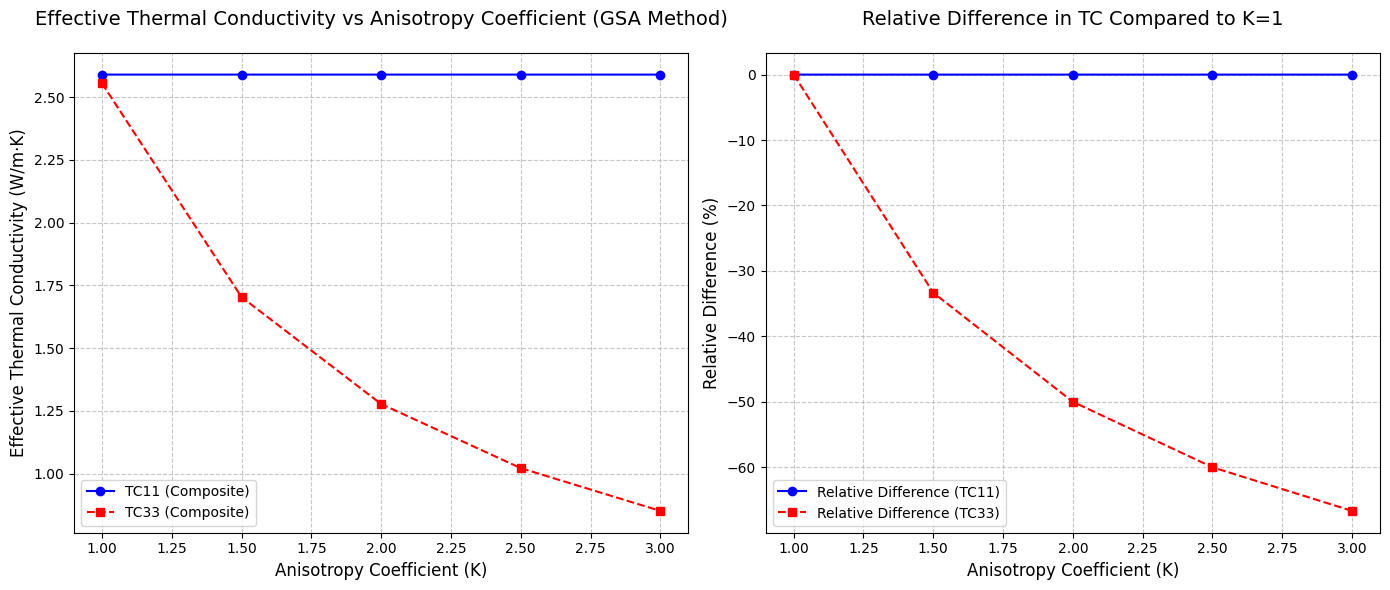

In [ ]:
# Input parameters
initial_volume_illite = 15.8  # Illite volume fraction (%)
initial_volume_kaolinite = 2.3  # Kaolinite volume fraction (%)

# Thermal conductivities (TC11 components)
tc11_illite = 2.69  # TC11 for illite
tc11_kaolinite = 1.90  # TC11 for kaolinite

# Define the range for anisotropy coefficient K
K_values = np.linspace(1, 3, 5)  # K varies from 1 to 2

# Lists to store tc_11 and tc_33 values for the composite material
tc11_composite_values = []
tc33_composite_values = []

# Loop over each K value
for K in K_values:
    # Calculate TC33 for illite and kaolinite
    tc33_illite = tc11_illite / K
    tc33_kaolinite = tc11_kaolinite / K

    # Create thermal conductivity tensors for illite and kaolinite
    lambda_illite = np.diag([tc11_illite, tc11_illite, tc33_illite])
    lambda_kaolinite = np.diag([tc11_kaolinite, tc11_kaolinite, tc33_kaolinite])

    # Volume fractions (normalized to sum to 1)
    total_volume = initial_volume_illite + initial_volume_kaolinite
    normalized_illite = initial_volume_illite / total_volume
    normalized_kaolinite = initial_volume_kaolinite / total_volume

    print(total_volume, normalized_illite , normalized_kaolinite)

    # Aspect ratios (alpha_shapes)
    # Assume illite and kaolinite are anisotropic (flattened ellipsoids)
    alpha_shapes = [
        [1000.0, 1000.0, 1],  # Illite (anisotropic)
        [1000.0, 1000.0, 1],  # Kaolinite (anisotropic)
    ]

    # Calculate effective thermal conductivity using the GSA method
    effective_tensor = gsa_model('Self-consistent',
        [normalized_illite, normalized_kaolinite],
        [lambda_illite, lambda_kaolinite],
        alpha_shapes, isotropic=False
    )



    # print(lambda_illite, [normalized_illite, normalized_kaolinite],
    #     [lambda_illite, lambda_kaolinite],
    #     alpha_shapes)

    print(effective_tensor)

    # Extract TC11 and TC33 from the effective tensor
    tc11_composite = effective_tensor[0, 0]
    tc33_composite = effective_tensor[2, 2]

    # Store the results
    tc11_composite_values.append(tc11_composite)
    tc33_composite_values.append(tc33_composite)

# Calculate relative differences compared to K=1
tc11_reference = tc11_composite_values[0]  # TC11 at K=1
tc33_reference = tc33_composite_values[0]  # TC33 at K=1

relative_diff_tc11 = [(tc - tc11_reference) / tc11_reference * 100 for tc in tc11_composite_values]
relative_diff_tc33 = [(tc - tc33_reference) / tc33_reference * 100 for tc in tc33_composite_values]

# Plot the results
plt.figure(figsize=(14, 6))

# Plot 1: Effective Thermal Conductivity vs Anisotropy Coefficient
plt.subplot(1, 2, 1)
plt.plot(K_values, tc11_composite_values, marker='o', linestyle='-', color='b', label='TC11 (Composite)')
plt.plot(K_values, tc33_composite_values, marker='s', linestyle='--', color='r', label='TC33 (Composite)')
plt.xlabel("Anisotropy Coefficient (K)", fontsize=12)
plt.ylabel("Effective Thermal Conductivity (W/m·K)", fontsize=12)
plt.title("Effective Thermal Conductivity vs Anisotropy Coefficient (GSA Method)", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)

# Plot 2: Relative Difference in TC Compared to K=1
plt.subplot(1, 2, 2)
plt.plot(K_values, relative_diff_tc11, marker='o', linestyle='-', color='b', label='Relative Difference (TC11)')
plt.plot(K_values, relative_diff_tc33, marker='s', linestyle='--', color='r', label='Relative Difference (TC33)')
plt.xlabel("Anisotropy Coefficient (K)", fontsize=12)
plt.ylabel("Relative Difference (%)", fontsize=12)
plt.title("Relative Difference in TC Compared to K=1", fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
tc11_clay = tc11_composite_values
tc33_clay = tc33_composite_values

### Material 3

Converged after 7 iterations
0.26 2.5

Effective tensor for Material:
[[ 3.485511  0.        0.      ]
 [ 0.        3.485511 -0.      ]
 [ 0.        0.        1.302221]]
Converged after 7 iterations
0.26 2.5

Effective tensor for Material:
[[ 3.484197  0.        0.      ]
 [ 0.        3.484197 -0.      ]
 [ 0.        0.        1.274362]]
Converged after 7 iterations
0.26 2.5

Effective tensor for Material:
[[ 3.482937  0.       -0.      ]
 [ 0.        3.482937 -0.      ]
 [ 0.       -0.        1.248037]]
Converged after 7 iterations
0.26 2.5

Effective tensor for Material:
[[ 3.481726  0.       -0.      ]
 [ 0.        3.481726 -0.      ]
 [-0.       -0.        1.223114]]
Converged after 7 iterations
0.26 2.5

Effective tensor for Material:
[[ 3.48056   0.        0.      ]
 [ 0.        3.48056  -0.      ]
 [-0.       -0.        1.199476]]


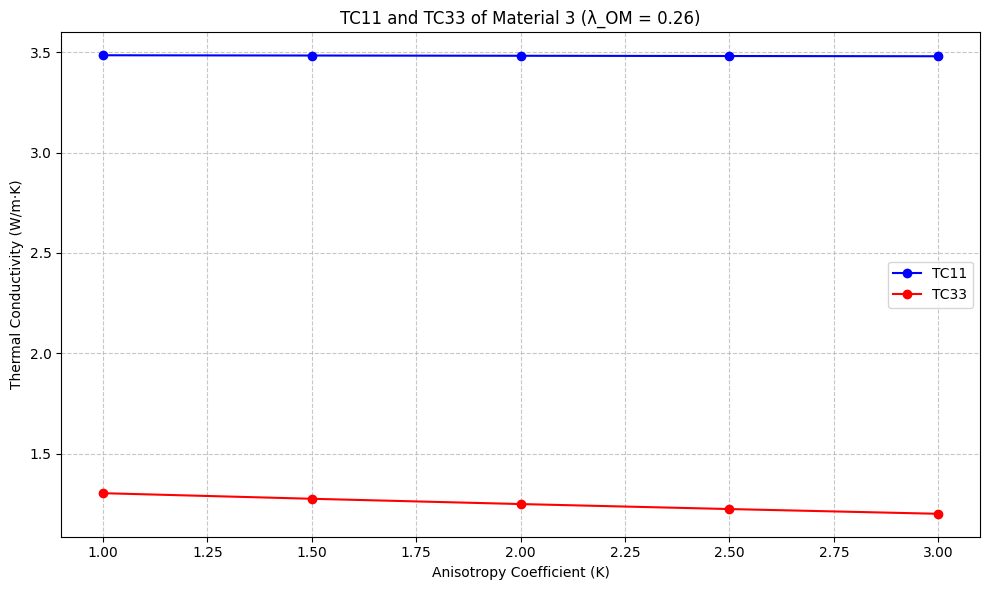

Converged after 7 iterations
0.3175 2.5

Effective tensor for Material:
[[ 3.516857  0.        0.      ]
 [ 0.        3.516857 -0.      ]
 [ 0.        0.        1.461174]]
Converged after 7 iterations
0.3175 2.5

Effective tensor for Material:
[[ 3.515276  0.       -0.      ]
 [ 0.        3.515276 -0.      ]
 [ 0.       -0.        1.423907]]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Input parameters for Material 1 (silica)
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
thermal_conductivities_sio2 = np.array([7.6, 3.2])  # Quartz, Opal, Chalcedony

# Input parameters for Material 2 (clay)
initial_volume_illite = 15.8  # Illite volume fraction (%)
initial_volume_kaolinite = 2.3  # Kaolinite volume fraction (%)
initial_volume_calcite = 32.5  # Calcite volume fraction (%)
initial_volume_sillica = 40.5  # Silica volume fraction (%)
initial_volume_OM = 24.7  # 100% of all OM

tc11_illite = 2.69  # TC11 for illite
tc11_kaolinite = 1.90  # TC11 for kaolinite
tc11_calcite = 3.22  # TC11 for calcite
tc_OM = np.linspace(0.26, 0.49, 5)  # Thermal conductivity of OM


# Main loop for dynamic plotting
for lambda_OM in tc_OM:
    # Arrays to store results for each K value
    tc11_material3 = np.zeros(len(K_values))
    tc33_material3 = np.zeros(len(K_values))

    for j, (c11, c33) in enumerate(zip(tc11_clay, tc33_clay)):
        # Effective thermal conductivity tensor for clay
        effective_tc_clay = np.diag([c11, c11, c33])

        # Volume fractions for Material 3 (silica + clay)
        total_volume_material3 = initial_volume_sio2 + initial_volume_illite + initial_volume_kaolinite + initial_volume_OM
        normalized_sillica = initial_volume_sio2 / total_volume_material3
        normalized_clay = (initial_volume_illite + initial_volume_kaolinite) / total_volume_material3
        normalized_OM = initial_volume_OM / total_volume_material3

        alpha_shapes_material3 = [
            [1.0, 1.0, 1.0],  # Silica (isotropic) Material 1
            [1000.0, 1000.0, 1],  # Clay (anisotropic) Material 2
            [1000.0, 1000.0, 1]  # OM laminated
        ]

        tc_OM_tensor = np.diag([lambda_OM] * 3)

        # Calculate effective thermal conductivity of Material 3
        effective_tensor_material3 = gsa_model(
            'Self-consistent',
            tc_OM_tensor, #Comparison body
            [normalized_sillica, normalized_clay, normalized_OM],
            [np.diag([material1] * 3), effective_tc_clay, tc_OM_tensor],
            alpha_shapes_material3, isotropic=False
        )
        print(lambda_OM, K)
        print(f"\nEffective tensor for Material:")
        print(np.round(effective_tensor_material3, 6))

        # Extract TC11 and TC33 from the effective tensor of Material 3
        tc11_material3[j] = effective_tensor_material3[0, 0]
        tc33_material3[j] = effective_tensor_material3[2, 2]

    plt.figure(figsize=(10, 6))
    plt.plot(K_values, tc11_material3, marker='o', linestyle='-', color='b', label='TC11')
    plt.plot(K_values, tc33_material3, marker='o', linestyle='-', color='r', label='TC33')

    plt.xlabel('Anisotropy Coefficient (K)')
    plt.ylabel('Thermal Conductivity (W/m·K)')
    plt.title(f'TC11 and TC33 of Material 3 (λ_OM = {lambda_OM:.2f})')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Converged after 7 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations


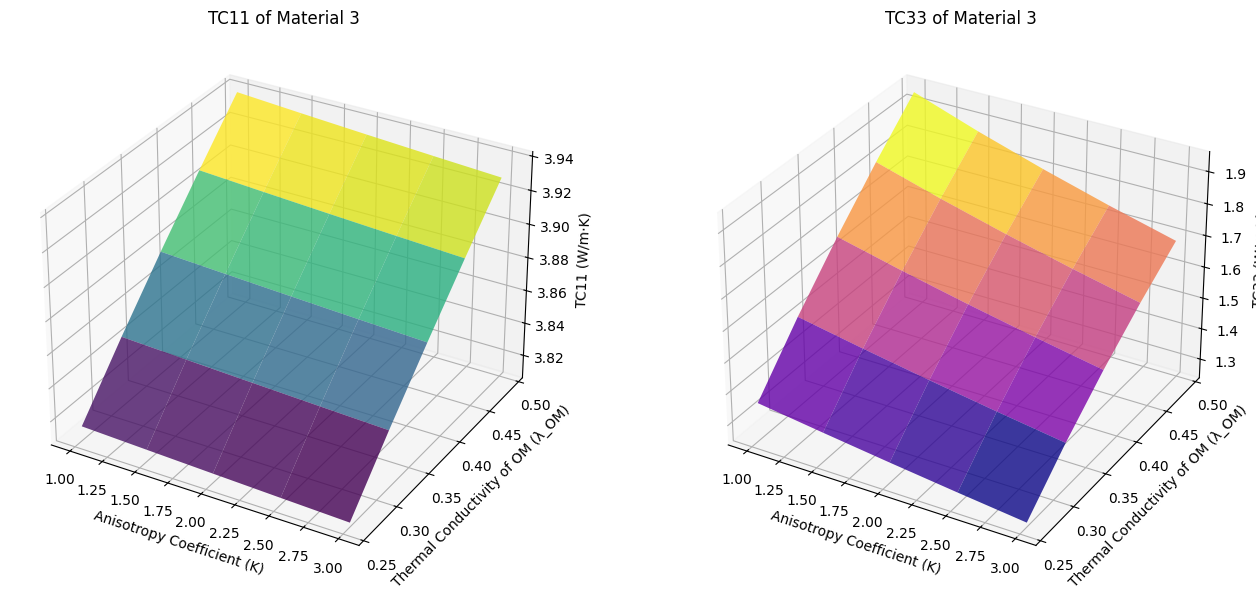

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Input parameters for Material 1 (silica)
initial_volume_sio2 = 40.5  # Total SiO₂ volume fraction in the rock (%)
thermal_conductivities_sio2 = np.array([7.6, 3.2])  # Quartz, Opal, Chalcedony

# Input parameters for Material 2 (clay)
initial_volume_illite = 15.8  # Illite volume fraction (%)
initial_volume_kaolinite = 2.3  # Kaolinite volume fraction (%)
initial_volume_calcite = 32.5  # Calcite volume fraction (%)
initial_volume_sillica = 40.5  # Silica volume fraction (%)
initial_volume_OM = 24.7  # 100% of all OM

tc11_illite = 2.69  # TC11 for illite
tc11_kaolinite = 1.90  # TC11 for kaolinite
tc11_calcite = 3.22  # TC11 for calcite
tc_OM = np.linspace(0.26, 0.49, 5)  # Thermal conductivity of OM

# Arrays to store results for each combination of tc_OM and K_values
tc11_results = np.zeros((len(tc_OM), len(K_values)))
tc33_results = np.zeros((len(tc_OM), len(K_values)))

# Main loop for dynamic plotting
for i, lambda_OM in enumerate(tc_OM):
    for j, (K, c11, c33) in enumerate(zip(K_values, tc11_clay, tc33_clay)):
        # Effective thermal conductivity tensor for clay
        effective_tc_clay = np.diag([c11, c11, c33])

        # Volume fractions for Material 3 (silica + clay)
        total_volume_material3 = initial_volume_sio2 + initial_volume_illite + initial_volume_kaolinite + initial_volume_OM
        normalized_sillica = initial_volume_sio2 / total_volume_material3
        normalized_clay = (initial_volume_illite + initial_volume_kaolinite) / total_volume_material3
        normalized_OM = initial_volume_OM / total_volume_material3

        # Define alpha shapes for Material 3
        alpha_shapes_material3 = [
            [1.0, 1.0, 1.0],  # Silica (isotropic) Material 1
            [1000.0, 1000.0, 1],  # Clay (anisotropic) Material 2
            [1000.0, 1000.0, 1]  # OM laminated
        ]

        # Thermal conductivity tensor for OM
        tc_OM_tensor = np.diag([lambda_OM] * 3)

        # Calculate effective thermal conductivity of Material 3
        effective_tensor_material3 = gsa_model(
            'Self-consistent',
            tc_OM_tensor,  # Comparison body
            [normalized_sillica, normalized_clay, normalized_OM],
            [np.diag([thermal_conductivities_sio2[0]] * 3), effective_tc_clay, tc_OM_tensor],
            alpha_shapes_material3, isotropic=False
        )

        # Store TC11 and TC33 results
        tc11_results[i, j] = effective_tensor_material3[0, 0]
        tc33_results[i, j] = effective_tensor_material3[2, 2]

# Create a meshgrid for 3D plotting
X, Y = np.meshgrid(K_values, tc_OM)

# Plot TC11 in 3D
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, tc11_results, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Anisotropy Coefficient (K)')
ax1.set_ylabel('Thermal Conductivity of OM (λ_OM)')
ax1.set_zlabel('TC11 (W/m·K)')
ax1.set_title('TC11 of Material 3')

# Plot TC33 in 3D
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, tc33_results, cmap='plasma', alpha=0.8)
ax2.set_xlabel('Anisotropy Coefficient (K)')
ax2.set_ylabel('Thermal Conductivity of OM (λ_OM)')
ax2.set_zlabel('TC33 (W/m·K)')
ax2.set_title('TC33 of Material 3')

plt.tight_layout()
plt.show()

In [ ]:
!pip install SALib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.7 MB/s eta 0:00:00


In [ ]:
def my_model(params):
    # Распаковка параметров
    tc11_illite, tc11_kaolinite, tc11_calcite, lambda_OM, K = params

    # Ваши вычисления
    effective_tc_clay = np.diag([tc11_illite, tc11_illite, tc11_illite / K])
    total_volume_material3 = initial_volume_sio2 + initial_volume_illite + initial_volume_kaolinite + initial_volume_OM
    normalized_sillica = initial_volume_sio2 / total_volume_material3
    normalized_clay = (initial_volume_illite + initial_volume_kaolinite) / total_volume_material3
    normalized_OM = initial_volume_OM / total_volume_material3

    alpha_shapes_material3 = [
        [1.0, 1.0, 1.0],  # Silica (isotropic) Material 1
        [1000.0, 1000.0, 1],  # Clay (anisotropic) Material 2
        [1000.0, 1000.0, 1]  # OM laminated
    ]

    tc_OM_tensor = np.diag([lambda_OM] * 3)

    # Вызов вашей функции gsa_model
    effective_tensor_material3 = gsa_model(
        'Self-consistent',
        tc_OM_tensor,
        [normalized_sillica, normalized_clay, normalized_OM],
        [np.diag([thermal_conductivities_sio2[0]] * 3), effective_tc_clay, tc_OM_tensor],
        alpha_shapes_material3, isotropic=False
    )

    # Возвращаем TC11 и TC33
    return effective_tensor_material3[0, 0], effective_tensor_material3[2, 2]

In [ ]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np

# Определение параметров и их диапазонов
problem = {
    'num_vars': 5,
    'names': ['tc11_illite', 'tc11_kaolinite', 'tc11_calcite', 'lambda_OM', 'K'],
    'bounds': [
        [2.0, 3.5],  # tc11_illite
        [1.5, 2.5],  # tc11_kaolinite
        [6.5, 6.7],  # tc11_calcite
        [0.2, 0.5],  # lambda_OM
        [1.0, 3.0]  # K
    ]
}

# Генерация выборки
param_values = saltelli.sample(problem, 100)

# Запуск модели для каждой комбинации параметров
outputs = np.array([my_model(params) for params in param_values])

# Анализ чувствительности для TC11
Si_TC11 = sobol.analyze(problem, outputs[:, 0])
print("Анализ чувствительности для TC11:")
print("Первый порядок (S1):", Si_TC11['S1'])
print("Общая чувствительность (ST):", Si_TC11['ST'])

# Анализ чувствительности для TC33
Si_TC33 = sobol.analyze(problem, outputs[:, 1])
print("\nАнализ чувствительности для TC33:")
print("Первый порядок (S1):", Si_TC33['S1'])
print("Общая чувствительность (ST):", Si_TC33['ST'])

<ipython-input-28-8c23d3d157c5>:19: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 100)
/usr/local/lib/python3.11/dist-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100) is equal to `2^n`.
        
  warnings.warn(msg)


Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged after 7 iterations
Converged afte

In [ ]:
import matplotlib.pyplot as plt

# График для TC11
plt.figure(figsize=(10, 6))
plt.bar(problem['names'], Si_TC11['S1'], label='Первый порядок (S1)')
plt.bar(problem['names'], Si_TC11['ST'], alpha=0.5, label='Общая чувствительность (ST)')
plt.title('Анализ чувствительности для TC11')
plt.xlabel('Параметры')
plt.ylabel('Чувствительность')
plt.legend()
plt.show()

# График для TC33
plt.figure(figsize=(10, 6))
plt.bar(problem['names'], Si_TC33['S1'], label='Первый порядок (S1)')
plt.bar(problem['names'], Si_TC33['ST'], alpha=0.5, label='Общая чувствительность (ST)')
plt.title('Анализ чувствительности для TC33')
plt.xlabel('Параметры')
plt.ylabel('Чувствительность')
plt.legend()
plt.show()